In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [3]:
import sys
sys.path.append("../src")

%load_ext autoreload
%autoreload 2

from resnet_brelu import resnet18 as custom_resnet

### Prepare data

In [4]:
dataset_path = "../data/chest_xray"

In [5]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [6]:
len(dataset)

5856

In [7]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [8]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

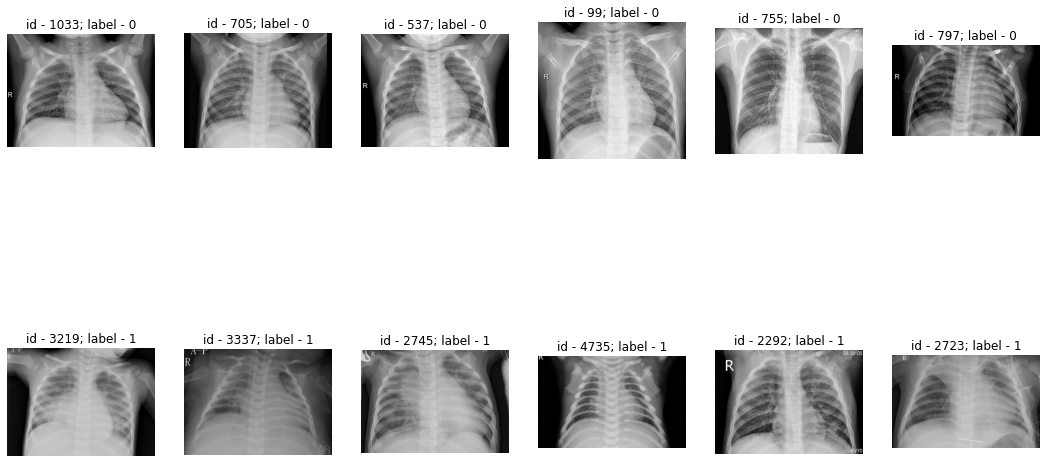

In [9]:
visualize_classes(dataset)

In [10]:
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [11]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

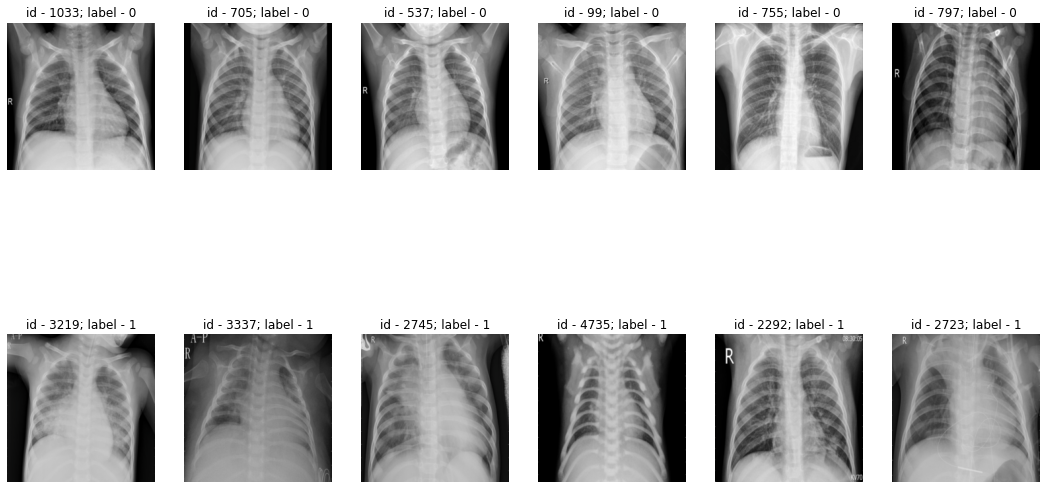

In [12]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [13]:
device = "cuda:0"
# device = "cpu"

In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

### Load model

In [16]:
save_path = "../models/6.3_resnet_brelu_2021-04-13_04:24:38.pt"

In [18]:
model = custom_resnet(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU6(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)

### Analyze results

In [19]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 74/74 [00:07<00:00,  9.96it/s]


In [20]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [21]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [22]:
df["error_type"] = df.apply(error_class, axis=1)

In [23]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,32,32,32
FP,37,37,37
TN,270,270,270
TP,833,833,833


In [24]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9411262798634812
average_precision_score - 0.9493541163683974


In [25]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [26]:
df

,true,pred,prob,error_type
0,0,0,0.268943,TN
1,1,1,0.729606,TP
2,1,1,0.730078,TP
3,1,1,0.730384,TP
4,1,1,0.730388,TP
...,...,...,...,...
1167,1,1,0.730359,TP
1168,1,1,0.730394,TP
1169,1,1,0.730406,TP
1170,1,1,0.730407,TP


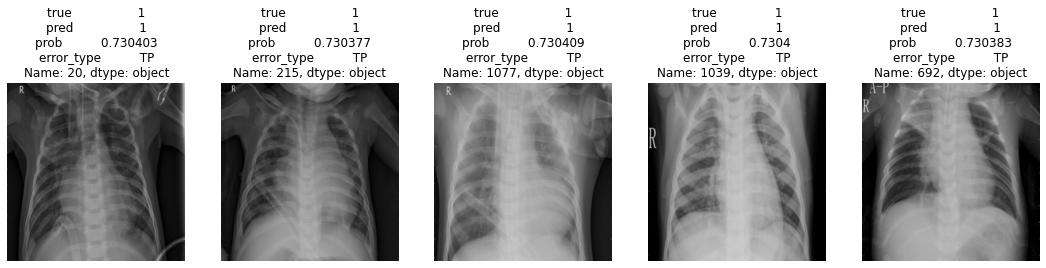

In [27]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

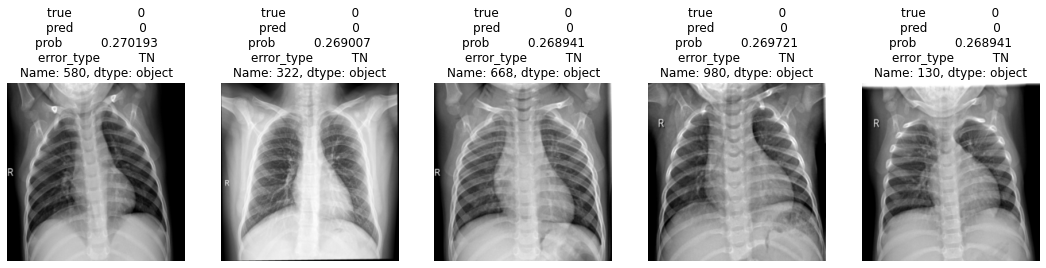

In [28]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

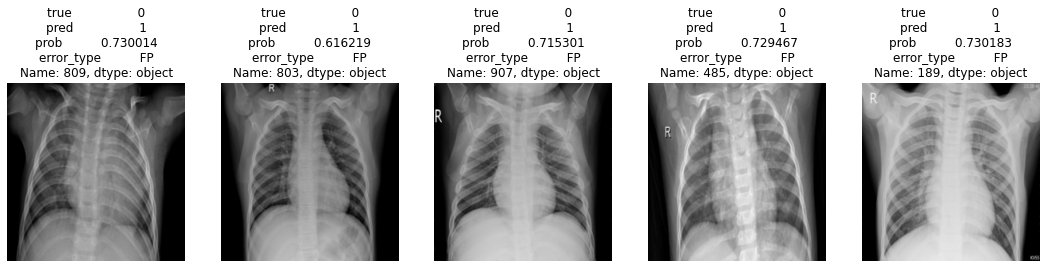

In [29]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

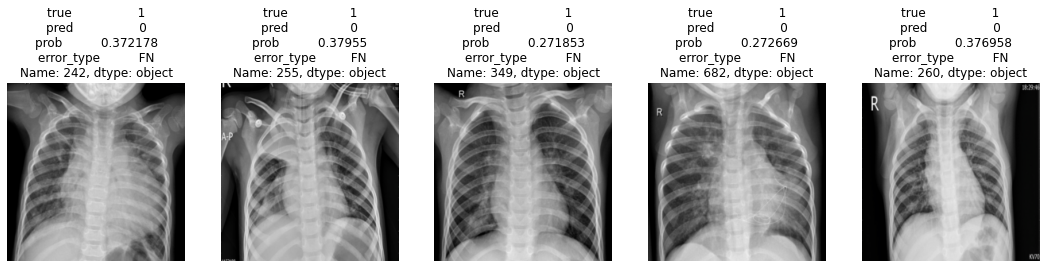

In [30]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [31]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [32]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

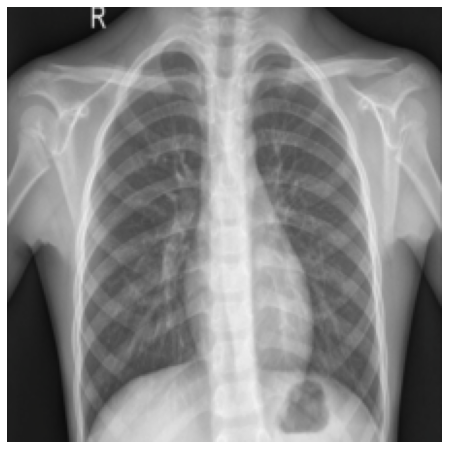

0.2689997

In [33]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [34]:
from art.estimators.classification import PyTorchClassifier

In [35]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [36]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

0.2689997


#### Loss gradient 

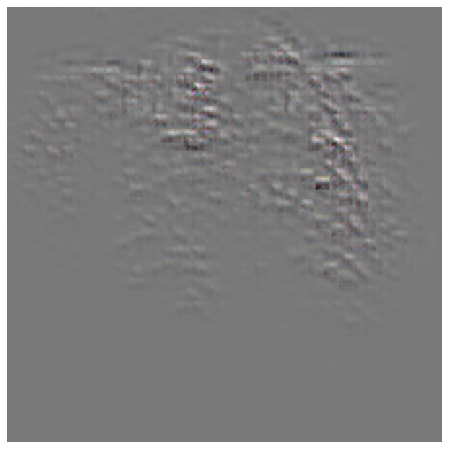

In [37]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [38]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [39]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [40]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [41]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [42]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [43]:
def get_preds(adv = None, batch_size=1, blur=False, max_iter=None):
    prob = []
    pred = []
    true = []
    images = []
    original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    blur_transform = transforms.GaussianBlur(3)
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
        if max_iter is not None:
            original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        if blur:
            for i in range(image.shape[0]):
                image[i] = blur_transform(torch.Tensor(image[i]))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
        images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [44]:
df_orig, orig_images = get_preds()

100%|██████████| 1172/1172 [00:16<00:00, 70.85it/s]


In [45]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

5.887372013651877

In [46]:
df_orig_blur, orig_blur_images = get_preds(blur=True)

100%|██████████| 1172/1172 [00:19<00:00, 59.02it/s]


In [47]:
robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
robustness_to_gaussian_blur

1.0434782608695652

In [48]:
misclassification_rate = get_misclassification_rate(df_orig_blur)
misclassification_rate

6.143344709897611

In [49]:
average_ssim = get_av_ssim(orig_images, orig_blur_images)
average_ssim

100%|██████████| 1172/1172 [00:07<00:00, 164.37it/s]


0.9736261640208451

#### ProjectedGradientDescent

In [50]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [51]:
df_pgd, pgd_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<15:41,  1.24it/s]

  0%|          | 2/1172 [00:01<15:00,  1.30it/s]

  0%|          | 3/1172 [00:02<14:44,  1.32it/s]

  0%|          | 4/1172 [00:02<14:27,  1.35it/s]

  0%|          | 5/1172 [00:03<14:15,  1.36it/s]

  1%|          | 6/1172 [00:04<14:01,  1.39it/s]

  1%|          | 7/1172 [00:05<14:00,  1.39it/s]

  1%|          | 8/1172 [00:05<13:56,  1.39it/s]

  1%|          | 9/1172 [00:06<13:49,  1.40it/s]

  1%|          | 10/1172 [00:07<13:47,  1.40it/s]

  1%|          | 11/1172 [00:07<13:46,  1.41it/s]

  1%|          | 12/1172 [00:08<13:41,  1.41it/s]

  1%|          | 13/1172 [00:09<13:41,  1.41it/s]

  1%|          | 14/1172 [00:10<13:39,  1.41it/s]

  1%|▏         | 15/1172 [00:10<13:42,  1.41it/s]

  1%|▏         | 16/1172 [00:11<13:35,  1.42it/s]

  1%|▏         | 17/1172 [00:12<13:38,  1.41it/s]

  2%|▏         | 18/1172 [00:12<13:30,  1.42it/s]

  2%|▏         | 19/1172 [00:13<13:30,  1.42it/s]

  2%|▏         | 20/1172 [00:14<13:26,  1.43it/s]

  2%|▏         | 21/1172 [00:14<13:28,  1.42it/s]

  2%|▏         | 22/1172 [00:15<13:26,  1.43it/s]

  2%|▏         | 23/1172 [00:16<13:27,  1.42it/s]

  2%|▏         | 24/1172 [00:17<13:32,  1.41it/s]

  2%|▏         | 25/1172 [00:17<13:29,  1.42it/s]

  2%|▏         | 26/1172 [00:18<13:28,  1.42it/s]

  2%|▏         | 27/1172 [00:19<13:27,  1.42it/s]

  2%|▏         | 28/1172 [00:19<13:30,  1.41it/s]

  2%|▏         | 29/1172 [00:20<13:24,  1.42it/s]

  3%|▎         | 30/1172 [00:21<13:22,  1.42it/s]

  3%|▎         | 31/1172 [00:21<13:20,  1.43it/s]

  3%|▎         | 32/1172 [00:22<13:25,  1.42it/s]

  3%|▎         | 33/1172 [00:23<13:29,  1.41it/s]

  3%|▎         | 34/1172 [00:24<13:30,  1.40it/s]

  3%|▎         | 35/1172 [00:24<13:28,  1.41it/s]

  3%|▎         | 36/1172 [00:25<13:22,  1.41it/s]

  3%|▎         | 37/1172 [00:26<13:17,  1.42it/s]

  3%|▎         | 38/1172 [00:26<13:17,  1.42it/s]

  3%|▎         | 39/1172 [00:27<13:13,  1.43it/s]

  3%|▎         | 40/1172 [00:28<13:12,  1.43it/s]

  3%|▎         | 41/1172 [00:29<13:13,  1.43it/s]

  4%|▎         | 42/1172 [00:29<13:14,  1.42it/s]

  4%|▎         | 43/1172 [00:30<13:09,  1.43it/s]

  4%|▍         | 44/1172 [00:31<13:08,  1.43it/s]

  4%|▍         | 45/1172 [00:31<13:07,  1.43it/s]

  4%|▍         | 46/1172 [00:32<13:11,  1.42it/s]

  4%|▍         | 47/1172 [00:33<13:16,  1.41it/s]

  4%|▍         | 48/1172 [00:33<13:16,  1.41it/s]

  4%|▍         | 49/1172 [00:34<13:16,  1.41it/s]

  4%|▍         | 50/1172 [00:35<13:13,  1.41it/s]

  4%|▍         | 51/1172 [00:36<13:11,  1.42it/s]

  4%|▍         | 52/1172 [00:36<13:10,  1.42it/s]

  5%|▍         | 53/1172 [00:37<13:19,  1.40it/s]

  5%|▍         | 54/1172 [00:38<13:16,  1.40it/s]

  5%|▍         | 55/1172 [00:38<13:19,  1.40it/s]

  5%|▍         | 56/1172 [00:39<13:20,  1.39it/s]

  5%|▍         | 57/1172 [00:40<13:12,  1.41it/s]

  5%|▍         | 58/1172 [00:41<13:11,  1.41it/s]

  5%|▌         | 59/1172 [00:41<13:14,  1.40it/s]

  5%|▌         | 60/1172 [00:42<13:13,  1.40it/s]

  5%|▌         | 61/1172 [00:43<13:23,  1.38it/s]

  5%|▌         | 62/1172 [00:43<13:14,  1.40it/s]

  5%|▌         | 63/1172 [00:44<13:08,  1.41it/s]

  5%|▌         | 64/1172 [00:45<13:02,  1.42it/s]

  6%|▌         | 65/1172 [00:46<13:06,  1.41it/s]

  6%|▌         | 66/1172 [00:46<13:06,  1.41it/s]

  6%|▌         | 67/1172 [00:47<13:06,  1.41it/s]

  6%|▌         | 68/1172 [00:48<13:02,  1.41it/s]

  6%|▌         | 69/1172 [00:48<13:02,  1.41it/s]

  6%|▌         | 70/1172 [00:49<12:56,  1.42it/s]

  6%|▌         | 71/1172 [00:50<12:57,  1.42it/s]

  6%|▌         | 72/1172 [00:51<12:55,  1.42it/s]

  6%|▌         | 73/1172 [00:51<12:57,  1.41it/s]

  6%|▋         | 74/1172 [00:52<12:52,  1.42it/s]

  6%|▋         | 75/1172 [00:53<12:50,  1.42it/s]

  6%|▋         | 76/1172 [00:53<12:51,  1.42it/s]

  7%|▋         | 77/1172 [00:54<12:46,  1.43it/s]

  7%|▋         | 78/1172 [00:55<12:51,  1.42it/s]

  7%|▋         | 79/1172 [00:55<12:53,  1.41it/s]

  7%|▋         | 80/1172 [00:56<12:54,  1.41it/s]

  7%|▋         | 81/1172 [00:57<12:52,  1.41it/s]

  7%|▋         | 82/1172 [00:58<12:51,  1.41it/s]

  7%|▋         | 83/1172 [00:58<12:48,  1.42it/s]

  7%|▋         | 84/1172 [00:59<12:48,  1.42it/s]

  7%|▋         | 85/1172 [01:00<12:46,  1.42it/s]

  7%|▋         | 86/1172 [01:00<12:46,  1.42it/s]

  7%|▋         | 87/1172 [01:01<12:44,  1.42it/s]

  8%|▊         | 88/1172 [01:02<12:47,  1.41it/s]

  8%|▊         | 89/1172 [01:03<12:44,  1.42it/s]

  8%|▊         | 90/1172 [01:03<12:47,  1.41it/s]

  8%|▊         | 91/1172 [01:04<12:45,  1.41it/s]

  8%|▊         | 92/1172 [01:05<12:51,  1.40it/s]

  8%|▊         | 93/1172 [01:05<12:48,  1.40it/s]

  8%|▊         | 94/1172 [01:06<12:47,  1.40it/s]

  8%|▊         | 95/1172 [01:07<12:44,  1.41it/s]

  8%|▊         | 96/1172 [01:08<12:47,  1.40it/s]

  8%|▊         | 97/1172 [01:08<12:42,  1.41it/s]

  8%|▊         | 98/1172 [01:09<12:44,  1.41it/s]

  8%|▊         | 99/1172 [01:10<12:42,  1.41it/s]

  9%|▊         | 100/1172 [01:10<12:42,  1.41it/s]

  9%|▊         | 101/1172 [01:11<12:40,  1.41it/s]

  9%|▊         | 102/1172 [01:12<12:43,  1.40it/s]

  9%|▉         | 103/1172 [01:12<12:37,  1.41it/s]

  9%|▉         | 104/1172 [01:13<12:35,  1.41it/s]

  9%|▉         | 105/1172 [01:14<12:35,  1.41it/s]

  9%|▉         | 106/1172 [01:15<12:35,  1.41it/s]

  9%|▉         | 107/1172 [01:15<12:33,  1.41it/s]

  9%|▉         | 108/1172 [01:16<12:34,  1.41it/s]

  9%|▉         | 109/1172 [01:17<12:36,  1.40it/s]

  9%|▉         | 110/1172 [01:17<12:34,  1.41it/s]

  9%|▉         | 111/1172 [01:18<12:36,  1.40it/s]

 10%|▉         | 112/1172 [01:19<12:34,  1.40it/s]

 10%|▉         | 113/1172 [01:20<12:37,  1.40it/s]

 10%|▉         | 114/1172 [01:20<12:37,  1.40it/s]

 10%|▉         | 115/1172 [01:21<12:32,  1.40it/s]

 10%|▉         | 116/1172 [01:22<12:30,  1.41it/s]

 10%|▉         | 117/1172 [01:22<12:26,  1.41it/s]

 10%|█         | 118/1172 [01:23<12:23,  1.42it/s]

 10%|█         | 119/1172 [01:24<12:24,  1.41it/s]

 10%|█         | 120/1172 [01:25<12:24,  1.41it/s]

 10%|█         | 121/1172 [01:25<12:28,  1.40it/s]

 10%|█         | 122/1172 [01:26<12:25,  1.41it/s]

 10%|█         | 123/1172 [01:27<12:24,  1.41it/s]

 11%|█         | 124/1172 [01:27<12:25,  1.41it/s]

 11%|█         | 125/1172 [01:28<12:25,  1.40it/s]

 11%|█         | 126/1172 [01:29<12:20,  1.41it/s]

 11%|█         | 127/1172 [01:30<12:20,  1.41it/s]

 11%|█         | 128/1172 [01:30<12:18,  1.41it/s]

 11%|█         | 129/1172 [01:31<12:21,  1.41it/s]

 11%|█         | 130/1172 [01:32<12:17,  1.41it/s]

 11%|█         | 131/1172 [01:32<12:16,  1.41it/s]

 11%|█▏        | 132/1172 [01:33<12:15,  1.41it/s]

 11%|█▏        | 133/1172 [01:34<12:13,  1.42it/s]

 11%|█▏        | 134/1172 [01:34<12:13,  1.42it/s]

 12%|█▏        | 135/1172 [01:35<12:13,  1.41it/s]

 12%|█▏        | 136/1172 [01:36<12:09,  1.42it/s]

 12%|█▏        | 137/1172 [01:37<12:14,  1.41it/s]

 12%|█▏        | 138/1172 [01:37<12:11,  1.41it/s]

 12%|█▏        | 139/1172 [01:38<12:16,  1.40it/s]

 12%|█▏        | 140/1172 [01:39<12:16,  1.40it/s]

 12%|█▏        | 141/1172 [01:39<12:17,  1.40it/s]

 12%|█▏        | 142/1172 [01:40<12:25,  1.38it/s]

 12%|█▏        | 143/1172 [01:41<12:19,  1.39it/s]

 12%|█▏        | 144/1172 [01:42<12:45,  1.34it/s]

 12%|█▏        | 145/1172 [01:42<12:31,  1.37it/s]

 12%|█▏        | 146/1172 [01:43<12:28,  1.37it/s]

 13%|█▎        | 147/1172 [01:44<12:18,  1.39it/s]

 13%|█▎        | 148/1172 [01:45<12:22,  1.38it/s]

 13%|█▎        | 149/1172 [01:45<12:14,  1.39it/s]

 13%|█▎        | 150/1172 [01:46<12:10,  1.40it/s]

 13%|█▎        | 151/1172 [01:47<12:02,  1.41it/s]

 13%|█▎        | 152/1172 [01:47<12:04,  1.41it/s]

 13%|█▎        | 153/1172 [01:48<11:59,  1.42it/s]

 13%|█▎        | 154/1172 [01:49<12:02,  1.41it/s]

 13%|█▎        | 155/1172 [01:50<12:01,  1.41it/s]

 13%|█▎        | 156/1172 [01:50<12:03,  1.40it/s]

 13%|█▎        | 157/1172 [01:51<12:01,  1.41it/s]

 13%|█▎        | 158/1172 [01:52<12:02,  1.40it/s]

 14%|█▎        | 159/1172 [01:52<11:57,  1.41it/s]

 14%|█▎        | 160/1172 [01:53<11:59,  1.41it/s]

 14%|█▎        | 161/1172 [01:54<11:56,  1.41it/s]

 14%|█▍        | 162/1172 [01:54<11:54,  1.41it/s]

 14%|█▍        | 163/1172 [01:55<11:53,  1.41it/s]

 14%|█▍        | 164/1172 [01:56<11:52,  1.42it/s]

 14%|█▍        | 165/1172 [01:57<11:54,  1.41it/s]

 14%|█▍        | 166/1172 [01:57<11:56,  1.40it/s]

 14%|█▍        | 167/1172 [01:58<11:53,  1.41it/s]

 14%|█▍        | 168/1172 [01:59<11:55,  1.40it/s]

 14%|█▍        | 169/1172 [01:59<11:49,  1.41it/s]

 15%|█▍        | 170/1172 [02:00<11:48,  1.41it/s]

 15%|█▍        | 171/1172 [02:01<11:50,  1.41it/s]

 15%|█▍        | 172/1172 [02:02<11:50,  1.41it/s]

 15%|█▍        | 173/1172 [02:02<11:47,  1.41it/s]

 15%|█▍        | 174/1172 [02:03<11:46,  1.41it/s]

 15%|█▍        | 175/1172 [02:04<11:47,  1.41it/s]

 15%|█▌        | 176/1172 [02:04<11:47,  1.41it/s]

 15%|█▌        | 177/1172 [02:05<11:47,  1.41it/s]

 15%|█▌        | 178/1172 [02:06<11:43,  1.41it/s]

 15%|█▌        | 179/1172 [02:07<11:50,  1.40it/s]

 15%|█▌        | 180/1172 [02:07<11:44,  1.41it/s]

 15%|█▌        | 181/1172 [02:08<11:47,  1.40it/s]

 16%|█▌        | 182/1172 [02:09<11:42,  1.41it/s]

 16%|█▌        | 183/1172 [02:09<11:41,  1.41it/s]

 16%|█▌        | 184/1172 [02:10<11:37,  1.42it/s]

 16%|█▌        | 185/1172 [02:11<11:36,  1.42it/s]

 16%|█▌        | 186/1172 [02:12<11:40,  1.41it/s]

 16%|█▌        | 187/1172 [02:12<11:41,  1.40it/s]

 16%|█▌        | 188/1172 [02:13<11:38,  1.41it/s]

 16%|█▌        | 189/1172 [02:14<11:37,  1.41it/s]

 16%|█▌        | 190/1172 [02:14<11:32,  1.42it/s]

 16%|█▋        | 191/1172 [02:15<11:34,  1.41it/s]

 16%|█▋        | 192/1172 [02:16<11:33,  1.41it/s]

 16%|█▋        | 193/1172 [02:16<11:37,  1.40it/s]

 17%|█▋        | 194/1172 [02:17<11:31,  1.41it/s]

 17%|█▋        | 195/1172 [02:18<11:30,  1.42it/s]

 17%|█▋        | 196/1172 [02:19<11:29,  1.41it/s]

 17%|█▋        | 197/1172 [02:19<11:31,  1.41it/s]

 17%|█▋        | 198/1172 [02:20<11:28,  1.41it/s]

 17%|█▋        | 199/1172 [02:21<11:33,  1.40it/s]

 17%|█▋        | 200/1172 [02:21<11:27,  1.41it/s]

 17%|█▋        | 201/1172 [02:22<11:28,  1.41it/s]

 17%|█▋        | 202/1172 [02:23<11:25,  1.42it/s]

 17%|█▋        | 203/1172 [02:24<11:25,  1.41it/s]

 17%|█▋        | 204/1172 [02:24<11:22,  1.42it/s]

 17%|█▋        | 205/1172 [02:25<11:27,  1.41it/s]

 18%|█▊        | 206/1172 [02:26<11:27,  1.40it/s]

 18%|█▊        | 207/1172 [02:26<11:26,  1.40it/s]

 18%|█▊        | 208/1172 [02:27<11:22,  1.41it/s]

 18%|█▊        | 209/1172 [02:28<11:19,  1.42it/s]

 18%|█▊        | 210/1172 [02:29<11:21,  1.41it/s]

 18%|█▊        | 211/1172 [02:29<11:17,  1.42it/s]

 18%|█▊        | 212/1172 [02:30<11:24,  1.40it/s]

 18%|█▊        | 213/1172 [02:31<11:21,  1.41it/s]

 18%|█▊        | 214/1172 [02:31<11:22,  1.40it/s]

 18%|█▊        | 215/1172 [02:32<11:19,  1.41it/s]

 18%|█▊        | 216/1172 [02:33<11:22,  1.40it/s]

 19%|█▊        | 217/1172 [02:33<11:15,  1.41it/s]

 19%|█▊        | 218/1172 [02:34<11:17,  1.41it/s]

 19%|█▊        | 219/1172 [02:35<11:16,  1.41it/s]

 19%|█▉        | 220/1172 [02:36<11:17,  1.41it/s]

 19%|█▉        | 221/1172 [02:36<11:13,  1.41it/s]

 19%|█▉        | 222/1172 [02:37<11:15,  1.41it/s]

 19%|█▉        | 223/1172 [02:38<11:17,  1.40it/s]

 19%|█▉        | 224/1172 [02:38<11:15,  1.40it/s]

 19%|█▉        | 225/1172 [02:39<11:06,  1.42it/s]

 19%|█▉        | 226/1172 [02:40<11:10,  1.41it/s]

 19%|█▉        | 227/1172 [02:41<11:09,  1.41it/s]

 19%|█▉        | 228/1172 [02:41<11:09,  1.41it/s]

 20%|█▉        | 229/1172 [02:42<11:10,  1.41it/s]

 20%|█▉        | 230/1172 [02:43<11:11,  1.40it/s]

 20%|█▉        | 231/1172 [02:43<11:10,  1.40it/s]

 20%|█▉        | 232/1172 [02:44<11:08,  1.41it/s]

 20%|█▉        | 233/1172 [02:45<11:12,  1.40it/s]

 20%|█▉        | 234/1172 [02:46<11:10,  1.40it/s]

 20%|██        | 235/1172 [02:46<11:10,  1.40it/s]

 20%|██        | 236/1172 [02:47<11:08,  1.40it/s]

 20%|██        | 237/1172 [02:48<11:06,  1.40it/s]

 20%|██        | 238/1172 [02:48<11:09,  1.40it/s]

 20%|██        | 239/1172 [02:49<11:08,  1.40it/s]

 20%|██        | 240/1172 [02:50<11:04,  1.40it/s]

 21%|██        | 241/1172 [02:51<11:06,  1.40it/s]

 21%|██        | 242/1172 [02:51<11:00,  1.41it/s]

 21%|██        | 243/1172 [02:52<11:02,  1.40it/s]

 21%|██        | 244/1172 [02:53<11:00,  1.40it/s]

 21%|██        | 245/1172 [02:53<11:00,  1.40it/s]

 21%|██        | 246/1172 [02:54<10:56,  1.41it/s]

 21%|██        | 247/1172 [02:55<10:56,  1.41it/s]

 21%|██        | 248/1172 [02:56<10:50,  1.42it/s]

 21%|██        | 249/1172 [02:56<10:49,  1.42it/s]

 21%|██▏       | 250/1172 [02:57<10:47,  1.42it/s]

 21%|██▏       | 251/1172 [02:58<10:54,  1.41it/s]

 22%|██▏       | 252/1172 [02:58<10:56,  1.40it/s]

 22%|██▏       | 253/1172 [02:59<10:55,  1.40it/s]

 22%|██▏       | 254/1172 [03:00<10:53,  1.40it/s]

 22%|██▏       | 255/1172 [03:01<10:49,  1.41it/s]

 22%|██▏       | 256/1172 [03:01<10:50,  1.41it/s]

 22%|██▏       | 257/1172 [03:02<10:54,  1.40it/s]

 22%|██▏       | 258/1172 [03:03<10:54,  1.40it/s]

 22%|██▏       | 259/1172 [03:03<10:51,  1.40it/s]

 22%|██▏       | 260/1172 [03:04<10:40,  1.42it/s]

 22%|██▏       | 261/1172 [03:05<10:47,  1.41it/s]

 22%|██▏       | 262/1172 [03:05<10:42,  1.42it/s]

 22%|██▏       | 263/1172 [03:06<10:42,  1.41it/s]

 23%|██▎       | 264/1172 [03:07<10:38,  1.42it/s]

 23%|██▎       | 265/1172 [03:08<10:38,  1.42it/s]

 23%|██▎       | 266/1172 [03:08<10:34,  1.43it/s]

 23%|██▎       | 267/1172 [03:09<10:34,  1.43it/s]

 23%|██▎       | 268/1172 [03:10<10:37,  1.42it/s]

 23%|██▎       | 269/1172 [03:10<10:38,  1.41it/s]

 23%|██▎       | 270/1172 [03:11<10:42,  1.40it/s]

 23%|██▎       | 271/1172 [03:12<10:41,  1.40it/s]

 23%|██▎       | 272/1172 [03:13<10:36,  1.41it/s]

 23%|██▎       | 273/1172 [03:13<10:38,  1.41it/s]

 23%|██▎       | 274/1172 [03:14<10:38,  1.41it/s]

 23%|██▎       | 275/1172 [03:15<10:36,  1.41it/s]

 24%|██▎       | 276/1172 [03:15<10:39,  1.40it/s]

 24%|██▎       | 277/1172 [03:16<10:36,  1.41it/s]

 24%|██▎       | 278/1172 [03:17<10:41,  1.39it/s]

 24%|██▍       | 279/1172 [03:18<10:34,  1.41it/s]

 24%|██▍       | 280/1172 [03:18<10:32,  1.41it/s]

 24%|██▍       | 281/1172 [03:19<10:28,  1.42it/s]

 24%|██▍       | 282/1172 [03:20<10:30,  1.41it/s]

 24%|██▍       | 283/1172 [03:20<10:29,  1.41it/s]

 24%|██▍       | 284/1172 [03:21<10:34,  1.40it/s]

 24%|██▍       | 285/1172 [03:22<10:40,  1.38it/s]

 24%|██▍       | 286/1172 [03:23<10:36,  1.39it/s]

 24%|██▍       | 287/1172 [03:23<10:33,  1.40it/s]

 25%|██▍       | 288/1172 [03:24<10:31,  1.40it/s]

 25%|██▍       | 289/1172 [03:25<10:22,  1.42it/s]

 25%|██▍       | 290/1172 [03:25<10:23,  1.41it/s]

 25%|██▍       | 291/1172 [03:26<10:13,  1.43it/s]

 25%|██▍       | 292/1172 [03:27<10:10,  1.44it/s]

 25%|██▌       | 293/1172 [03:27<10:10,  1.44it/s]

 25%|██▌       | 294/1172 [03:28<10:17,  1.42it/s]

 25%|██▌       | 295/1172 [03:29<10:16,  1.42it/s]

 25%|██▌       | 296/1172 [03:30<10:19,  1.41it/s]

 25%|██▌       | 297/1172 [03:30<10:20,  1.41it/s]

 25%|██▌       | 298/1172 [03:31<10:23,  1.40it/s]

 26%|██▌       | 299/1172 [03:32<10:26,  1.39it/s]

 26%|██▌       | 300/1172 [03:32<10:22,  1.40it/s]

 26%|██▌       | 301/1172 [03:33<10:20,  1.40it/s]

 26%|██▌       | 302/1172 [03:34<10:22,  1.40it/s]

 26%|██▌       | 303/1172 [03:35<10:20,  1.40it/s]

 26%|██▌       | 304/1172 [03:35<10:20,  1.40it/s]

 26%|██▌       | 305/1172 [03:36<10:15,  1.41it/s]

 26%|██▌       | 306/1172 [03:37<10:15,  1.41it/s]

 26%|██▌       | 307/1172 [03:37<10:19,  1.40it/s]

 26%|██▋       | 308/1172 [03:38<10:20,  1.39it/s]

 26%|██▋       | 309/1172 [03:39<10:17,  1.40it/s]

 26%|██▋       | 310/1172 [03:40<10:15,  1.40it/s]

 27%|██▋       | 311/1172 [03:40<10:15,  1.40it/s]

 27%|██▋       | 312/1172 [03:41<10:12,  1.40it/s]

 27%|██▋       | 313/1172 [03:42<10:14,  1.40it/s]

 27%|██▋       | 314/1172 [03:42<10:15,  1.39it/s]

 27%|██▋       | 315/1172 [03:43<10:18,  1.38it/s]

 27%|██▋       | 316/1172 [03:44<10:10,  1.40it/s]

 27%|██▋       | 317/1172 [03:45<10:13,  1.39it/s]

 27%|██▋       | 318/1172 [03:45<10:06,  1.41it/s]

 27%|██▋       | 319/1172 [03:46<10:05,  1.41it/s]

 27%|██▋       | 320/1172 [03:47<10:08,  1.40it/s]

 27%|██▋       | 321/1172 [03:47<10:12,  1.39it/s]

 27%|██▋       | 322/1172 [03:48<10:10,  1.39it/s]

 28%|██▊       | 323/1172 [03:49<10:08,  1.40it/s]

 28%|██▊       | 324/1172 [03:50<10:09,  1.39it/s]

 28%|██▊       | 325/1172 [03:50<10:06,  1.40it/s]

 28%|██▊       | 326/1172 [03:51<09:56,  1.42it/s]

 28%|██▊       | 327/1172 [03:52<09:58,  1.41it/s]

 28%|██▊       | 328/1172 [03:52<09:57,  1.41it/s]

 28%|██▊       | 329/1172 [03:53<09:56,  1.41it/s]

 28%|██▊       | 330/1172 [03:54<09:57,  1.41it/s]

 28%|██▊       | 331/1172 [03:55<09:59,  1.40it/s]

 28%|██▊       | 332/1172 [03:55<09:56,  1.41it/s]

 28%|██▊       | 333/1172 [03:56<09:55,  1.41it/s]

 28%|██▊       | 334/1172 [03:57<09:52,  1.41it/s]

 29%|██▊       | 335/1172 [03:57<09:54,  1.41it/s]

 29%|██▊       | 336/1172 [03:58<09:55,  1.40it/s]

 29%|██▉       | 337/1172 [03:59<09:53,  1.41it/s]

 29%|██▉       | 338/1172 [04:00<10:02,  1.38it/s]

 29%|██▉       | 339/1172 [04:00<09:58,  1.39it/s]

 29%|██▉       | 340/1172 [04:01<09:58,  1.39it/s]

 29%|██▉       | 341/1172 [04:02<09:53,  1.40it/s]

 29%|██▉       | 342/1172 [04:02<09:56,  1.39it/s]

 29%|██▉       | 343/1172 [04:03<09:53,  1.40it/s]

 29%|██▉       | 344/1172 [04:04<09:52,  1.40it/s]

 29%|██▉       | 345/1172 [04:05<09:46,  1.41it/s]

 30%|██▉       | 346/1172 [04:05<09:49,  1.40it/s]

 30%|██▉       | 347/1172 [04:06<09:49,  1.40it/s]

 30%|██▉       | 348/1172 [04:07<09:50,  1.40it/s]

 30%|██▉       | 349/1172 [04:07<09:45,  1.40it/s]

 30%|██▉       | 350/1172 [04:08<09:44,  1.41it/s]

 30%|██▉       | 351/1172 [04:09<09:43,  1.41it/s]

 30%|███       | 352/1172 [04:10<09:44,  1.40it/s]

 30%|███       | 353/1172 [04:10<09:39,  1.41it/s]

 30%|███       | 354/1172 [04:11<09:38,  1.41it/s]

 30%|███       | 355/1172 [04:12<09:35,  1.42it/s]

 30%|███       | 356/1172 [04:12<09:36,  1.42it/s]

 30%|███       | 357/1172 [04:13<09:36,  1.41it/s]

 31%|███       | 358/1172 [04:14<09:38,  1.41it/s]

 31%|███       | 359/1172 [04:14<09:33,  1.42it/s]

 31%|███       | 360/1172 [04:15<09:34,  1.41it/s]

 31%|███       | 361/1172 [04:16<09:34,  1.41it/s]

 31%|███       | 362/1172 [04:17<09:34,  1.41it/s]

 31%|███       | 363/1172 [04:17<09:32,  1.41it/s]

 31%|███       | 364/1172 [04:18<09:31,  1.41it/s]

 31%|███       | 365/1172 [04:19<09:29,  1.42it/s]

 31%|███       | 366/1172 [04:19<09:31,  1.41it/s]

 31%|███▏      | 367/1172 [04:20<09:29,  1.41it/s]

 31%|███▏      | 368/1172 [04:21<09:33,  1.40it/s]

 31%|███▏      | 369/1172 [04:22<09:31,  1.41it/s]

 32%|███▏      | 370/1172 [04:22<09:30,  1.41it/s]

 32%|███▏      | 371/1172 [04:23<09:28,  1.41it/s]

 32%|███▏      | 372/1172 [04:24<09:23,  1.42it/s]

 32%|███▏      | 373/1172 [04:24<09:29,  1.40it/s]

 32%|███▏      | 374/1172 [04:25<09:25,  1.41it/s]

 32%|███▏      | 375/1172 [04:26<09:26,  1.41it/s]

 32%|███▏      | 376/1172 [04:27<09:25,  1.41it/s]

 32%|███▏      | 377/1172 [04:27<09:30,  1.39it/s]

 32%|███▏      | 378/1172 [04:28<09:29,  1.40it/s]

 32%|███▏      | 379/1172 [04:29<09:31,  1.39it/s]

 32%|███▏      | 380/1172 [04:29<09:27,  1.40it/s]

 33%|███▎      | 381/1172 [04:30<09:25,  1.40it/s]

 33%|███▎      | 382/1172 [04:31<09:25,  1.40it/s]

 33%|███▎      | 383/1172 [04:32<09:22,  1.40it/s]

 33%|███▎      | 384/1172 [04:32<09:20,  1.40it/s]

 33%|███▎      | 385/1172 [04:33<09:18,  1.41it/s]

 33%|███▎      | 386/1172 [04:34<09:14,  1.42it/s]

 33%|███▎      | 387/1172 [04:34<09:14,  1.41it/s]

 33%|███▎      | 388/1172 [04:35<09:13,  1.42it/s]

 33%|███▎      | 389/1172 [04:36<09:16,  1.41it/s]

 33%|███▎      | 390/1172 [04:36<09:13,  1.41it/s]

 33%|███▎      | 391/1172 [04:37<09:13,  1.41it/s]

 33%|███▎      | 392/1172 [04:38<09:14,  1.41it/s]

 34%|███▎      | 393/1172 [04:39<09:12,  1.41it/s]

 34%|███▎      | 394/1172 [04:39<09:08,  1.42it/s]

 34%|███▎      | 395/1172 [04:40<09:09,  1.41it/s]

 34%|███▍      | 396/1172 [04:41<09:10,  1.41it/s]

 34%|███▍      | 397/1172 [04:41<09:09,  1.41it/s]

 34%|███▍      | 398/1172 [04:42<09:12,  1.40it/s]

 34%|███▍      | 399/1172 [04:43<09:11,  1.40it/s]

 34%|███▍      | 400/1172 [04:44<09:08,  1.41it/s]

 34%|███▍      | 401/1172 [04:44<09:08,  1.41it/s]

 34%|███▍      | 402/1172 [04:45<09:09,  1.40it/s]

 34%|███▍      | 403/1172 [04:46<09:07,  1.40it/s]

 34%|███▍      | 404/1172 [04:46<09:13,  1.39it/s]

 35%|███▍      | 405/1172 [04:47<09:11,  1.39it/s]

 35%|███▍      | 406/1172 [04:48<09:09,  1.39it/s]

 35%|███▍      | 407/1172 [04:49<09:06,  1.40it/s]

 35%|███▍      | 408/1172 [04:49<09:07,  1.39it/s]

 35%|███▍      | 409/1172 [04:50<08:57,  1.42it/s]

 35%|███▍      | 410/1172 [04:51<09:00,  1.41it/s]

 35%|███▌      | 411/1172 [04:51<09:05,  1.40it/s]

 35%|███▌      | 412/1172 [04:52<09:01,  1.40it/s]

 35%|███▌      | 413/1172 [04:53<08:58,  1.41it/s]

 35%|███▌      | 414/1172 [04:54<08:58,  1.41it/s]

 35%|███▌      | 415/1172 [04:54<08:57,  1.41it/s]

 35%|███▌      | 416/1172 [04:55<08:58,  1.40it/s]

 36%|███▌      | 417/1172 [04:56<08:57,  1.41it/s]

 36%|███▌      | 418/1172 [04:56<08:57,  1.40it/s]

 36%|███▌      | 419/1172 [04:57<08:55,  1.40it/s]

 36%|███▌      | 420/1172 [04:58<08:54,  1.41it/s]

 36%|███▌      | 421/1172 [04:59<08:51,  1.41it/s]

 36%|███▌      | 422/1172 [04:59<08:51,  1.41it/s]

 36%|███▌      | 423/1172 [05:00<08:47,  1.42it/s]

 36%|███▌      | 424/1172 [05:01<08:49,  1.41it/s]

 36%|███▋      | 425/1172 [05:01<08:47,  1.41it/s]

 36%|███▋      | 426/1172 [05:02<08:47,  1.41it/s]

 36%|███▋      | 427/1172 [05:03<08:44,  1.42it/s]

 37%|███▋      | 428/1172 [05:03<08:43,  1.42it/s]

 37%|███▋      | 429/1172 [05:04<08:43,  1.42it/s]

 37%|███▋      | 430/1172 [05:05<08:46,  1.41it/s]

 37%|███▋      | 431/1172 [05:06<08:45,  1.41it/s]

 37%|███▋      | 432/1172 [05:06<08:45,  1.41it/s]

 37%|███▋      | 433/1172 [05:07<08:46,  1.40it/s]

 37%|███▋      | 434/1172 [05:08<08:47,  1.40it/s]

 37%|███▋      | 435/1172 [05:08<08:45,  1.40it/s]

 37%|███▋      | 436/1172 [05:09<08:43,  1.41it/s]

 37%|███▋      | 437/1172 [05:10<08:44,  1.40it/s]

 37%|███▋      | 438/1172 [05:11<08:43,  1.40it/s]

 37%|███▋      | 439/1172 [05:11<08:47,  1.39it/s]

 38%|███▊      | 440/1172 [05:12<08:43,  1.40it/s]

 38%|███▊      | 441/1172 [05:13<08:43,  1.40it/s]

 38%|███▊      | 442/1172 [05:13<08:40,  1.40it/s]

 38%|███▊      | 443/1172 [05:14<08:38,  1.41it/s]

 38%|███▊      | 444/1172 [05:15<08:36,  1.41it/s]

 38%|███▊      | 445/1172 [05:16<08:36,  1.41it/s]

 38%|███▊      | 446/1172 [05:16<08:37,  1.40it/s]

 38%|███▊      | 447/1172 [05:17<08:37,  1.40it/s]

 38%|███▊      | 448/1172 [05:18<08:43,  1.38it/s]

 38%|███▊      | 449/1172 [05:18<08:40,  1.39it/s]

 38%|███▊      | 450/1172 [05:19<08:38,  1.39it/s]

 38%|███▊      | 451/1172 [05:20<08:35,  1.40it/s]

 39%|███▊      | 452/1172 [05:21<08:36,  1.39it/s]

 39%|███▊      | 453/1172 [05:21<08:32,  1.40it/s]

 39%|███▊      | 454/1172 [05:22<08:29,  1.41it/s]

 39%|███▉      | 455/1172 [05:23<08:28,  1.41it/s]

 39%|███▉      | 456/1172 [05:23<08:28,  1.41it/s]

 39%|███▉      | 457/1172 [05:24<08:30,  1.40it/s]

 39%|███▉      | 458/1172 [05:25<08:28,  1.40it/s]

 39%|███▉      | 459/1172 [05:26<08:26,  1.41it/s]

 39%|███▉      | 460/1172 [05:26<08:24,  1.41it/s]

 39%|███▉      | 461/1172 [05:27<08:23,  1.41it/s]

 39%|███▉      | 462/1172 [05:28<08:21,  1.42it/s]

 40%|███▉      | 463/1172 [05:28<08:22,  1.41it/s]

 40%|███▉      | 464/1172 [05:29<08:25,  1.40it/s]

 40%|███▉      | 465/1172 [05:30<08:25,  1.40it/s]

 40%|███▉      | 466/1172 [05:31<08:33,  1.38it/s]

 40%|███▉      | 467/1172 [05:31<08:29,  1.38it/s]

 40%|███▉      | 468/1172 [05:32<08:24,  1.40it/s]

 40%|████      | 469/1172 [05:33<08:20,  1.41it/s]

 40%|████      | 470/1172 [05:33<08:18,  1.41it/s]

 40%|████      | 471/1172 [05:34<08:15,  1.42it/s]

 40%|████      | 472/1172 [05:35<08:23,  1.39it/s]

 40%|████      | 473/1172 [05:36<08:28,  1.37it/s]

 40%|████      | 474/1172 [05:36<08:24,  1.38it/s]

 41%|████      | 475/1172 [05:37<08:27,  1.37it/s]

 41%|████      | 476/1172 [05:38<08:23,  1.38it/s]

 41%|████      | 477/1172 [05:39<08:26,  1.37it/s]

 41%|████      | 478/1172 [05:39<08:22,  1.38it/s]

 41%|████      | 479/1172 [05:40<08:15,  1.40it/s]

 41%|████      | 480/1172 [05:41<08:16,  1.39it/s]

 41%|████      | 481/1172 [05:41<08:15,  1.39it/s]

 41%|████      | 482/1172 [05:42<08:14,  1.39it/s]

 41%|████      | 483/1172 [05:43<08:14,  1.39it/s]

 41%|████▏     | 484/1172 [05:44<08:15,  1.39it/s]

 41%|████▏     | 485/1172 [05:44<08:13,  1.39it/s]

 41%|████▏     | 486/1172 [05:45<08:11,  1.40it/s]

 42%|████▏     | 487/1172 [05:46<08:07,  1.40it/s]

 42%|████▏     | 488/1172 [05:46<08:07,  1.40it/s]

 42%|████▏     | 489/1172 [05:47<08:00,  1.42it/s]

 42%|████▏     | 490/1172 [05:48<08:03,  1.41it/s]

 42%|████▏     | 491/1172 [05:49<08:02,  1.41it/s]

 42%|████▏     | 492/1172 [05:49<08:01,  1.41it/s]

 42%|████▏     | 493/1172 [05:50<08:01,  1.41it/s]

 42%|████▏     | 494/1172 [05:51<08:01,  1.41it/s]

 42%|████▏     | 495/1172 [05:51<08:05,  1.39it/s]

 42%|████▏     | 496/1172 [05:52<08:01,  1.40it/s]

 42%|████▏     | 497/1172 [05:53<08:02,  1.40it/s]

 42%|████▏     | 498/1172 [05:54<08:04,  1.39it/s]

 43%|████▎     | 499/1172 [05:54<08:07,  1.38it/s]

 43%|████▎     | 500/1172 [05:55<08:03,  1.39it/s]

 43%|████▎     | 501/1172 [05:56<08:01,  1.39it/s]

 43%|████▎     | 502/1172 [05:56<07:59,  1.40it/s]

 43%|████▎     | 503/1172 [05:57<07:59,  1.40it/s]

 43%|████▎     | 504/1172 [05:58<07:57,  1.40it/s]

 43%|████▎     | 505/1172 [05:59<07:57,  1.40it/s]

 43%|████▎     | 506/1172 [05:59<07:56,  1.40it/s]

 43%|████▎     | 507/1172 [06:00<07:55,  1.40it/s]

 43%|████▎     | 508/1172 [06:01<07:54,  1.40it/s]

 43%|████▎     | 509/1172 [06:01<07:54,  1.40it/s]

 44%|████▎     | 510/1172 [06:02<07:56,  1.39it/s]

 44%|████▎     | 511/1172 [06:03<07:52,  1.40it/s]

 44%|████▎     | 512/1172 [06:04<07:49,  1.41it/s]

 44%|████▍     | 513/1172 [06:04<07:47,  1.41it/s]

 44%|████▍     | 514/1172 [06:05<07:47,  1.41it/s]

 44%|████▍     | 515/1172 [06:06<07:46,  1.41it/s]

 44%|████▍     | 516/1172 [06:06<07:44,  1.41it/s]

 44%|████▍     | 517/1172 [06:07<07:47,  1.40it/s]

 44%|████▍     | 518/1172 [06:08<07:45,  1.41it/s]

 44%|████▍     | 519/1172 [06:09<07:45,  1.40it/s]

 44%|████▍     | 520/1172 [06:09<07:44,  1.40it/s]

 44%|████▍     | 521/1172 [06:10<07:42,  1.41it/s]

 45%|████▍     | 522/1172 [06:11<07:49,  1.39it/s]

 45%|████▍     | 523/1172 [06:11<07:39,  1.41it/s]

 45%|████▍     | 524/1172 [06:12<07:36,  1.42it/s]

 45%|████▍     | 525/1172 [06:13<07:35,  1.42it/s]

 45%|████▍     | 526/1172 [06:14<07:41,  1.40it/s]

 45%|████▍     | 527/1172 [06:14<07:41,  1.40it/s]

 45%|████▌     | 528/1172 [06:15<07:39,  1.40it/s]

 45%|████▌     | 529/1172 [06:16<07:38,  1.40it/s]

 45%|████▌     | 530/1172 [06:16<07:49,  1.37it/s]

 45%|████▌     | 531/1172 [06:17<07:41,  1.39it/s]

 45%|████▌     | 532/1172 [06:18<07:39,  1.39it/s]

 45%|████▌     | 533/1172 [06:19<07:37,  1.40it/s]

 46%|████▌     | 534/1172 [06:19<07:36,  1.40it/s]

 46%|████▌     | 535/1172 [06:20<07:34,  1.40it/s]

 46%|████▌     | 536/1172 [06:21<07:31,  1.41it/s]

 46%|████▌     | 537/1172 [06:21<07:31,  1.41it/s]

 46%|████▌     | 538/1172 [06:22<07:30,  1.41it/s]

 46%|████▌     | 539/1172 [06:23<07:29,  1.41it/s]

 46%|████▌     | 540/1172 [06:24<07:31,  1.40it/s]

 46%|████▌     | 541/1172 [06:24<07:27,  1.41it/s]

 46%|████▌     | 542/1172 [06:25<07:26,  1.41it/s]

 46%|████▋     | 543/1172 [06:26<07:27,  1.40it/s]

 46%|████▋     | 544/1172 [06:26<07:30,  1.39it/s]

 47%|████▋     | 545/1172 [06:27<07:31,  1.39it/s]

 47%|████▋     | 546/1172 [06:28<07:27,  1.40it/s]

 47%|████▋     | 547/1172 [06:29<07:29,  1.39it/s]

 47%|████▋     | 548/1172 [06:29<07:26,  1.40it/s]

 47%|████▋     | 549/1172 [06:30<07:29,  1.38it/s]

 47%|████▋     | 550/1172 [06:31<07:34,  1.37it/s]

 47%|████▋     | 551/1172 [06:31<07:29,  1.38it/s]

 47%|████▋     | 552/1172 [06:32<07:25,  1.39it/s]

 47%|████▋     | 553/1172 [06:33<07:25,  1.39it/s]

 47%|████▋     | 554/1172 [06:34<07:21,  1.40it/s]

 47%|████▋     | 555/1172 [06:34<07:20,  1.40it/s]

 47%|████▋     | 556/1172 [06:35<07:19,  1.40it/s]

 48%|████▊     | 557/1172 [06:36<07:18,  1.40it/s]

 48%|████▊     | 558/1172 [06:36<07:16,  1.41it/s]

 48%|████▊     | 559/1172 [06:37<07:20,  1.39it/s]

 48%|████▊     | 560/1172 [06:38<07:20,  1.39it/s]

 48%|████▊     | 561/1172 [06:39<07:18,  1.39it/s]

 48%|████▊     | 562/1172 [06:39<07:15,  1.40it/s]

 48%|████▊     | 563/1172 [06:40<07:15,  1.40it/s]

 48%|████▊     | 564/1172 [06:41<07:13,  1.40it/s]

 48%|████▊     | 565/1172 [06:41<07:12,  1.40it/s]

 48%|████▊     | 566/1172 [06:42<07:13,  1.40it/s]

 48%|████▊     | 567/1172 [06:43<07:11,  1.40it/s]

 48%|████▊     | 568/1172 [06:44<07:09,  1.41it/s]

 49%|████▊     | 569/1172 [06:44<07:08,  1.41it/s]

 49%|████▊     | 570/1172 [06:45<07:09,  1.40it/s]

 49%|████▊     | 571/1172 [06:46<07:08,  1.40it/s]

 49%|████▉     | 572/1172 [06:46<07:05,  1.41it/s]

 49%|████▉     | 573/1172 [06:47<07:04,  1.41it/s]

 49%|████▉     | 574/1172 [06:48<07:07,  1.40it/s]

 49%|████▉     | 575/1172 [06:49<07:10,  1.39it/s]

 49%|████▉     | 576/1172 [06:49<07:09,  1.39it/s]

 49%|████▉     | 577/1172 [06:50<07:04,  1.40it/s]

 49%|████▉     | 578/1172 [06:51<07:01,  1.41it/s]

 49%|████▉     | 579/1172 [06:51<07:00,  1.41it/s]

 49%|████▉     | 580/1172 [06:52<07:01,  1.40it/s]

 50%|████▉     | 581/1172 [06:53<06:58,  1.41it/s]

 50%|████▉     | 582/1172 [06:54<07:00,  1.40it/s]

 50%|████▉     | 583/1172 [06:54<07:02,  1.39it/s]

 50%|████▉     | 584/1172 [06:55<07:03,  1.39it/s]

 50%|████▉     | 585/1172 [06:56<06:58,  1.40it/s]

 50%|█████     | 586/1172 [06:56<06:56,  1.41it/s]

 50%|█████     | 587/1172 [06:57<06:53,  1.41it/s]

 50%|█████     | 588/1172 [06:58<06:54,  1.41it/s]

 50%|█████     | 589/1172 [06:59<06:53,  1.41it/s]

 50%|█████     | 590/1172 [06:59<06:50,  1.42it/s]

 50%|█████     | 591/1172 [07:00<06:51,  1.41it/s]

 51%|█████     | 592/1172 [07:01<06:55,  1.40it/s]

 51%|█████     | 593/1172 [07:01<06:53,  1.40it/s]

 51%|█████     | 594/1172 [07:02<06:54,  1.40it/s]

 51%|█████     | 595/1172 [07:03<06:50,  1.40it/s]

 51%|█████     | 596/1172 [07:03<06:48,  1.41it/s]

 51%|█████     | 597/1172 [07:04<06:47,  1.41it/s]

 51%|█████     | 598/1172 [07:05<06:48,  1.40it/s]

 51%|█████     | 599/1172 [07:06<06:49,  1.40it/s]

 51%|█████     | 600/1172 [07:06<06:47,  1.40it/s]

 51%|█████▏    | 601/1172 [07:07<06:49,  1.39it/s]

 51%|█████▏    | 602/1172 [07:08<06:50,  1.39it/s]

 51%|█████▏    | 603/1172 [07:09<06:47,  1.39it/s]

 52%|█████▏    | 604/1172 [07:09<06:47,  1.39it/s]

 52%|█████▏    | 605/1172 [07:10<06:44,  1.40it/s]

 52%|█████▏    | 606/1172 [07:11<06:43,  1.40it/s]

 52%|█████▏    | 607/1172 [07:11<06:48,  1.38it/s]

 52%|█████▏    | 608/1172 [07:12<06:46,  1.39it/s]

 52%|█████▏    | 609/1172 [07:13<06:48,  1.38it/s]

 52%|█████▏    | 610/1172 [07:14<06:43,  1.39it/s]

 52%|█████▏    | 611/1172 [07:14<06:44,  1.39it/s]

 52%|█████▏    | 612/1172 [07:15<06:44,  1.39it/s]

 52%|█████▏    | 613/1172 [07:16<06:42,  1.39it/s]

 52%|█████▏    | 614/1172 [07:16<06:39,  1.40it/s]

 52%|█████▏    | 615/1172 [07:17<06:36,  1.40it/s]

 53%|█████▎    | 616/1172 [07:18<06:39,  1.39it/s]

 53%|█████▎    | 617/1172 [07:19<06:39,  1.39it/s]

 53%|█████▎    | 618/1172 [07:19<06:36,  1.40it/s]

 53%|█████▎    | 619/1172 [07:20<06:35,  1.40it/s]

 53%|█████▎    | 620/1172 [07:21<06:32,  1.40it/s]

 53%|█████▎    | 621/1172 [07:21<06:33,  1.40it/s]

 53%|█████▎    | 622/1172 [07:22<06:31,  1.41it/s]

 53%|█████▎    | 623/1172 [07:23<06:30,  1.41it/s]

 53%|█████▎    | 624/1172 [07:24<06:29,  1.41it/s]

 53%|█████▎    | 625/1172 [07:24<06:29,  1.40it/s]

 53%|█████▎    | 626/1172 [07:25<06:33,  1.39it/s]

 53%|█████▎    | 627/1172 [07:26<06:32,  1.39it/s]

 54%|█████▎    | 628/1172 [07:26<06:33,  1.38it/s]

 54%|█████▎    | 629/1172 [07:27<06:32,  1.38it/s]

 54%|█████▍    | 630/1172 [07:28<06:31,  1.38it/s]

 54%|█████▍    | 631/1172 [07:29<06:27,  1.40it/s]

 54%|█████▍    | 632/1172 [07:29<06:24,  1.40it/s]

 54%|█████▍    | 633/1172 [07:30<06:24,  1.40it/s]

 54%|█████▍    | 634/1172 [07:31<06:30,  1.38it/s]

 54%|█████▍    | 635/1172 [07:31<06:26,  1.39it/s]

 54%|█████▍    | 636/1172 [07:32<06:24,  1.39it/s]

 54%|█████▍    | 637/1172 [07:33<06:27,  1.38it/s]

 54%|█████▍    | 638/1172 [07:34<06:23,  1.39it/s]

 55%|█████▍    | 639/1172 [07:34<06:22,  1.39it/s]

 55%|█████▍    | 640/1172 [07:35<06:20,  1.40it/s]

 55%|█████▍    | 641/1172 [07:36<06:15,  1.41it/s]

 55%|█████▍    | 642/1172 [07:36<06:19,  1.40it/s]

 55%|█████▍    | 643/1172 [07:37<06:19,  1.39it/s]

 55%|█████▍    | 644/1172 [07:38<06:20,  1.39it/s]

 55%|█████▌    | 645/1172 [07:39<06:19,  1.39it/s]

 55%|█████▌    | 646/1172 [07:39<06:19,  1.39it/s]

 55%|█████▌    | 647/1172 [07:40<06:14,  1.40it/s]

 55%|█████▌    | 648/1172 [07:41<06:13,  1.40it/s]

 55%|█████▌    | 649/1172 [07:41<06:12,  1.41it/s]

 55%|█████▌    | 650/1172 [07:42<06:12,  1.40it/s]

 56%|█████▌    | 651/1172 [07:43<06:11,  1.40it/s]

 56%|█████▌    | 652/1172 [07:44<06:10,  1.40it/s]

 56%|█████▌    | 653/1172 [07:44<06:13,  1.39it/s]

 56%|█████▌    | 654/1172 [07:45<06:10,  1.40it/s]

 56%|█████▌    | 655/1172 [07:46<06:10,  1.40it/s]

 56%|█████▌    | 656/1172 [07:47<06:09,  1.40it/s]

 56%|█████▌    | 657/1172 [07:47<06:10,  1.39it/s]

 56%|█████▌    | 658/1172 [07:48<06:08,  1.40it/s]

 56%|█████▌    | 659/1172 [07:49<06:10,  1.39it/s]

 56%|█████▋    | 660/1172 [07:49<06:06,  1.40it/s]

 56%|█████▋    | 661/1172 [07:50<06:08,  1.39it/s]

 56%|█████▋    | 662/1172 [07:51<06:03,  1.40it/s]

 57%|█████▋    | 663/1172 [07:52<05:58,  1.42it/s]

 57%|█████▋    | 664/1172 [07:52<05:58,  1.42it/s]

 57%|█████▋    | 665/1172 [07:53<06:03,  1.40it/s]

 57%|█████▋    | 666/1172 [07:54<06:02,  1.40it/s]

 57%|█████▋    | 667/1172 [07:54<06:00,  1.40it/s]

 57%|█████▋    | 668/1172 [07:55<05:59,  1.40it/s]

 57%|█████▋    | 669/1172 [07:56<05:57,  1.41it/s]

 57%|█████▋    | 670/1172 [07:56<05:52,  1.42it/s]

 57%|█████▋    | 671/1172 [07:57<05:51,  1.43it/s]

 57%|█████▋    | 672/1172 [07:58<05:52,  1.42it/s]

 57%|█████▋    | 673/1172 [07:59<05:53,  1.41it/s]

 58%|█████▊    | 674/1172 [07:59<05:53,  1.41it/s]

 58%|█████▊    | 675/1172 [08:00<05:52,  1.41it/s]

 58%|█████▊    | 676/1172 [08:01<05:51,  1.41it/s]

 58%|█████▊    | 677/1172 [08:01<05:52,  1.41it/s]

 58%|█████▊    | 678/1172 [08:02<05:51,  1.41it/s]

 58%|█████▊    | 679/1172 [08:03<05:50,  1.41it/s]

 58%|█████▊    | 680/1172 [08:04<05:52,  1.40it/s]

 58%|█████▊    | 681/1172 [08:04<05:54,  1.39it/s]

 58%|█████▊    | 682/1172 [08:05<05:52,  1.39it/s]

 58%|█████▊    | 683/1172 [08:06<05:52,  1.39it/s]

 58%|█████▊    | 684/1172 [08:07<05:54,  1.38it/s]

 58%|█████▊    | 685/1172 [08:07<05:53,  1.38it/s]

 59%|█████▊    | 686/1172 [08:08<05:55,  1.37it/s]

 59%|█████▊    | 687/1172 [08:09<05:51,  1.38it/s]

 59%|█████▊    | 688/1172 [08:09<05:46,  1.40it/s]

 59%|█████▉    | 689/1172 [08:10<05:45,  1.40it/s]

 59%|█████▉    | 690/1172 [08:11<05:41,  1.41it/s]

 59%|█████▉    | 691/1172 [08:11<05:36,  1.43it/s]

 59%|█████▉    | 692/1172 [08:12<05:41,  1.41it/s]

 59%|█████▉    | 693/1172 [08:13<05:38,  1.41it/s]

 59%|█████▉    | 694/1172 [08:14<05:37,  1.42it/s]

 59%|█████▉    | 695/1172 [08:14<05:37,  1.41it/s]

 59%|█████▉    | 696/1172 [08:15<05:37,  1.41it/s]

 59%|█████▉    | 697/1172 [08:16<05:35,  1.41it/s]

 60%|█████▉    | 698/1172 [08:16<05:37,  1.40it/s]

 60%|█████▉    | 699/1172 [08:17<05:36,  1.40it/s]

 60%|█████▉    | 700/1172 [08:18<05:36,  1.40it/s]

 60%|█████▉    | 701/1172 [08:19<05:33,  1.41it/s]

 60%|█████▉    | 702/1172 [08:19<05:35,  1.40it/s]

 60%|█████▉    | 703/1172 [08:20<05:34,  1.40it/s]

 60%|██████    | 704/1172 [08:21<05:37,  1.39it/s]

 60%|██████    | 705/1172 [08:21<05:35,  1.39it/s]

 60%|██████    | 706/1172 [08:22<05:34,  1.39it/s]

 60%|██████    | 707/1172 [08:23<05:30,  1.41it/s]

 60%|██████    | 708/1172 [08:24<05:29,  1.41it/s]

 60%|██████    | 709/1172 [08:24<05:25,  1.42it/s]

 61%|██████    | 710/1172 [08:25<05:26,  1.42it/s]

 61%|██████    | 711/1172 [08:26<05:25,  1.41it/s]

 61%|██████    | 712/1172 [08:26<05:26,  1.41it/s]

 61%|██████    | 713/1172 [08:27<05:25,  1.41it/s]

 61%|██████    | 714/1172 [08:28<05:25,  1.41it/s]

 61%|██████    | 715/1172 [08:29<05:23,  1.41it/s]

 61%|██████    | 716/1172 [08:29<05:23,  1.41it/s]

 61%|██████    | 717/1172 [08:30<05:22,  1.41it/s]

 61%|██████▏   | 718/1172 [08:31<05:22,  1.41it/s]

 61%|██████▏   | 719/1172 [08:31<05:21,  1.41it/s]

 61%|██████▏   | 720/1172 [08:32<05:19,  1.41it/s]

 62%|██████▏   | 721/1172 [08:33<05:21,  1.40it/s]

 62%|██████▏   | 722/1172 [08:34<05:18,  1.41it/s]

 62%|██████▏   | 723/1172 [08:34<05:19,  1.41it/s]

 62%|██████▏   | 724/1172 [08:35<05:16,  1.42it/s]

 62%|██████▏   | 725/1172 [08:36<05:17,  1.41it/s]

 62%|██████▏   | 726/1172 [08:36<05:15,  1.41it/s]

 62%|██████▏   | 727/1172 [08:37<05:15,  1.41it/s]

 62%|██████▏   | 728/1172 [08:38<05:14,  1.41it/s]

 62%|██████▏   | 729/1172 [08:38<05:13,  1.42it/s]

 62%|██████▏   | 730/1172 [08:39<05:13,  1.41it/s]

 62%|██████▏   | 731/1172 [08:40<05:13,  1.41it/s]

 62%|██████▏   | 732/1172 [08:41<05:13,  1.40it/s]

 63%|██████▎   | 733/1172 [08:41<05:12,  1.41it/s]

 63%|██████▎   | 734/1172 [08:42<05:11,  1.41it/s]

 63%|██████▎   | 735/1172 [08:43<05:10,  1.41it/s]

 63%|██████▎   | 736/1172 [08:43<05:07,  1.42it/s]

 63%|██████▎   | 737/1172 [08:44<05:09,  1.40it/s]

 63%|██████▎   | 738/1172 [08:45<05:08,  1.41it/s]

 63%|██████▎   | 739/1172 [08:46<05:07,  1.41it/s]

 63%|██████▎   | 740/1172 [08:46<05:06,  1.41it/s]

 63%|██████▎   | 741/1172 [08:47<05:05,  1.41it/s]

 63%|██████▎   | 742/1172 [08:48<05:05,  1.41it/s]

 63%|██████▎   | 743/1172 [08:48<05:05,  1.40it/s]

 63%|██████▎   | 744/1172 [08:49<05:06,  1.40it/s]

 64%|██████▎   | 745/1172 [08:50<05:04,  1.40it/s]

 64%|██████▎   | 746/1172 [08:51<05:03,  1.40it/s]

 64%|██████▎   | 747/1172 [08:51<05:03,  1.40it/s]

 64%|██████▍   | 748/1172 [08:52<04:59,  1.42it/s]

 64%|██████▍   | 749/1172 [08:53<05:00,  1.41it/s]

 64%|██████▍   | 750/1172 [08:53<04:56,  1.42it/s]

 64%|██████▍   | 751/1172 [08:54<04:58,  1.41it/s]

 64%|██████▍   | 752/1172 [08:55<05:00,  1.40it/s]

 64%|██████▍   | 753/1172 [08:56<04:57,  1.41it/s]

 64%|██████▍   | 754/1172 [08:56<04:59,  1.40it/s]

 64%|██████▍   | 755/1172 [08:57<04:58,  1.40it/s]

 65%|██████▍   | 756/1172 [08:58<04:58,  1.39it/s]

 65%|██████▍   | 757/1172 [08:58<04:57,  1.39it/s]

 65%|██████▍   | 758/1172 [08:59<04:54,  1.40it/s]

 65%|██████▍   | 759/1172 [09:00<04:55,  1.40it/s]

 65%|██████▍   | 760/1172 [09:01<04:54,  1.40it/s]

 65%|██████▍   | 761/1172 [09:01<04:53,  1.40it/s]

 65%|██████▌   | 762/1172 [09:02<04:52,  1.40it/s]

 65%|██████▌   | 763/1172 [09:03<04:50,  1.41it/s]

 65%|██████▌   | 764/1172 [09:03<04:50,  1.40it/s]

 65%|██████▌   | 765/1172 [09:04<04:48,  1.41it/s]

 65%|██████▌   | 766/1172 [09:05<04:47,  1.41it/s]

 65%|██████▌   | 767/1172 [09:06<04:47,  1.41it/s]

 66%|██████▌   | 768/1172 [09:06<04:46,  1.41it/s]

 66%|██████▌   | 769/1172 [09:07<04:42,  1.42it/s]

 66%|██████▌   | 770/1172 [09:08<04:43,  1.42it/s]

 66%|██████▌   | 771/1172 [09:08<04:45,  1.41it/s]

 66%|██████▌   | 772/1172 [09:09<04:44,  1.41it/s]

 66%|██████▌   | 773/1172 [09:10<04:45,  1.40it/s]

 66%|██████▌   | 774/1172 [09:10<04:44,  1.40it/s]

 66%|██████▌   | 775/1172 [09:11<04:41,  1.41it/s]

 66%|██████▌   | 776/1172 [09:12<04:40,  1.41it/s]

 66%|██████▋   | 777/1172 [09:13<04:38,  1.42it/s]

 66%|██████▋   | 778/1172 [09:13<04:39,  1.41it/s]

 66%|██████▋   | 779/1172 [09:14<04:39,  1.41it/s]

 67%|██████▋   | 780/1172 [09:15<04:37,  1.41it/s]

 67%|██████▋   | 781/1172 [09:15<04:37,  1.41it/s]

 67%|██████▋   | 782/1172 [09:16<04:36,  1.41it/s]

 67%|██████▋   | 783/1172 [09:17<04:35,  1.41it/s]

 67%|██████▋   | 784/1172 [09:18<04:34,  1.41it/s]

 67%|██████▋   | 785/1172 [09:18<04:37,  1.39it/s]

 67%|██████▋   | 786/1172 [09:19<04:36,  1.40it/s]

 67%|██████▋   | 787/1172 [09:20<04:36,  1.39it/s]

 67%|██████▋   | 788/1172 [09:20<04:36,  1.39it/s]

 67%|██████▋   | 789/1172 [09:21<04:34,  1.39it/s]

 67%|██████▋   | 790/1172 [09:22<04:33,  1.40it/s]

 67%|██████▋   | 791/1172 [09:23<04:32,  1.40it/s]

 68%|██████▊   | 792/1172 [09:23<04:33,  1.39it/s]

 68%|██████▊   | 793/1172 [09:24<04:32,  1.39it/s]

 68%|██████▊   | 794/1172 [09:25<04:33,  1.38it/s]

 68%|██████▊   | 795/1172 [09:26<04:34,  1.37it/s]

 68%|██████▊   | 796/1172 [09:26<04:35,  1.37it/s]

 68%|██████▊   | 797/1172 [09:27<04:32,  1.38it/s]

 68%|██████▊   | 798/1172 [09:28<04:29,  1.39it/s]

 68%|██████▊   | 799/1172 [09:28<04:29,  1.39it/s]

 68%|██████▊   | 800/1172 [09:29<04:28,  1.39it/s]

 68%|██████▊   | 801/1172 [09:30<04:25,  1.40it/s]

 68%|██████▊   | 802/1172 [09:31<04:22,  1.41it/s]

 69%|██████▊   | 803/1172 [09:31<04:22,  1.40it/s]

 69%|██████▊   | 804/1172 [09:32<04:22,  1.40it/s]

 69%|██████▊   | 805/1172 [09:33<04:21,  1.40it/s]

 69%|██████▉   | 806/1172 [09:33<04:21,  1.40it/s]

 69%|██████▉   | 807/1172 [09:34<04:18,  1.41it/s]

 69%|██████▉   | 808/1172 [09:35<04:17,  1.41it/s]

 69%|██████▉   | 809/1172 [09:36<04:17,  1.41it/s]

 69%|██████▉   | 810/1172 [09:36<04:18,  1.40it/s]

 69%|██████▉   | 811/1172 [09:37<04:17,  1.40it/s]

 69%|██████▉   | 812/1172 [09:38<04:18,  1.39it/s]

 69%|██████▉   | 813/1172 [09:38<04:16,  1.40it/s]

 69%|██████▉   | 814/1172 [09:39<04:15,  1.40it/s]

 70%|██████▉   | 815/1172 [09:40<04:15,  1.40it/s]

 70%|██████▉   | 816/1172 [09:41<04:14,  1.40it/s]

 70%|██████▉   | 817/1172 [09:41<04:13,  1.40it/s]

 70%|██████▉   | 818/1172 [09:42<04:13,  1.40it/s]

 70%|██████▉   | 819/1172 [09:43<04:11,  1.40it/s]

 70%|██████▉   | 820/1172 [09:43<04:11,  1.40it/s]

 70%|███████   | 821/1172 [09:44<04:11,  1.40it/s]

 70%|███████   | 822/1172 [09:45<04:10,  1.40it/s]

 70%|███████   | 823/1172 [09:45<04:06,  1.41it/s]

 70%|███████   | 824/1172 [09:46<04:07,  1.41it/s]

 70%|███████   | 825/1172 [09:47<04:05,  1.41it/s]

 70%|███████   | 826/1172 [09:48<04:04,  1.42it/s]

 71%|███████   | 827/1172 [09:48<04:02,  1.42it/s]

 71%|███████   | 828/1172 [09:49<04:04,  1.41it/s]

 71%|███████   | 829/1172 [09:50<04:04,  1.40it/s]

 71%|███████   | 830/1172 [09:50<04:02,  1.41it/s]

 71%|███████   | 831/1172 [09:51<04:01,  1.41it/s]

 71%|███████   | 832/1172 [09:52<04:02,  1.40it/s]

 71%|███████   | 833/1172 [09:53<04:01,  1.40it/s]

 71%|███████   | 834/1172 [09:53<04:00,  1.41it/s]

 71%|███████   | 835/1172 [09:54<04:00,  1.40it/s]

 71%|███████▏  | 836/1172 [09:55<03:58,  1.41it/s]

 71%|███████▏  | 837/1172 [09:55<04:00,  1.39it/s]

 72%|███████▏  | 838/1172 [09:56<03:58,  1.40it/s]

 72%|███████▏  | 839/1172 [09:57<03:57,  1.40it/s]

 72%|███████▏  | 840/1172 [09:58<03:56,  1.40it/s]

 72%|███████▏  | 841/1172 [09:58<03:56,  1.40it/s]

 72%|███████▏  | 842/1172 [09:59<03:55,  1.40it/s]

 72%|███████▏  | 843/1172 [10:00<03:57,  1.39it/s]

 72%|███████▏  | 844/1172 [10:00<03:54,  1.40it/s]

 72%|███████▏  | 845/1172 [10:01<03:54,  1.39it/s]

 72%|███████▏  | 846/1172 [10:02<03:52,  1.40it/s]

 72%|███████▏  | 847/1172 [10:03<03:51,  1.40it/s]

 72%|███████▏  | 848/1172 [10:03<03:52,  1.40it/s]

 72%|███████▏  | 849/1172 [10:04<03:51,  1.40it/s]

 73%|███████▎  | 850/1172 [10:05<03:48,  1.41it/s]

 73%|███████▎  | 851/1172 [10:05<03:47,  1.41it/s]

 73%|███████▎  | 852/1172 [10:06<03:45,  1.42it/s]

 73%|███████▎  | 853/1172 [10:07<03:45,  1.41it/s]

 73%|███████▎  | 854/1172 [10:08<03:46,  1.41it/s]

 73%|███████▎  | 855/1172 [10:08<03:45,  1.40it/s]

 73%|███████▎  | 856/1172 [10:09<03:45,  1.40it/s]

 73%|███████▎  | 857/1172 [10:10<03:44,  1.40it/s]

 73%|███████▎  | 858/1172 [10:10<03:43,  1.41it/s]

 73%|███████▎  | 859/1172 [10:11<03:43,  1.40it/s]

 73%|███████▎  | 860/1172 [10:12<03:43,  1.39it/s]

 73%|███████▎  | 861/1172 [10:13<03:44,  1.39it/s]

 74%|███████▎  | 862/1172 [10:13<03:42,  1.39it/s]

 74%|███████▎  | 863/1172 [10:14<03:42,  1.39it/s]

 74%|███████▎  | 864/1172 [10:15<03:41,  1.39it/s]

 74%|███████▍  | 865/1172 [10:15<03:39,  1.40it/s]

 74%|███████▍  | 866/1172 [10:16<03:38,  1.40it/s]

 74%|███████▍  | 867/1172 [10:17<03:37,  1.40it/s]

 74%|███████▍  | 868/1172 [10:18<03:35,  1.41it/s]

 74%|███████▍  | 869/1172 [10:18<03:36,  1.40it/s]

 74%|███████▍  | 870/1172 [10:19<03:34,  1.41it/s]

 74%|███████▍  | 871/1172 [10:20<03:34,  1.40it/s]

 74%|███████▍  | 872/1172 [10:20<03:34,  1.40it/s]

 74%|███████▍  | 873/1172 [10:21<03:33,  1.40it/s]

 75%|███████▍  | 874/1172 [10:22<03:34,  1.39it/s]

 75%|███████▍  | 875/1172 [10:23<03:31,  1.41it/s]

 75%|███████▍  | 876/1172 [10:23<03:31,  1.40it/s]

 75%|███████▍  | 877/1172 [10:24<03:30,  1.40it/s]

 75%|███████▍  | 878/1172 [10:25<03:30,  1.39it/s]

 75%|███████▌  | 879/1172 [10:25<03:29,  1.40it/s]

 75%|███████▌  | 880/1172 [10:26<03:27,  1.41it/s]

 75%|███████▌  | 881/1172 [10:27<03:26,  1.41it/s]

 75%|███████▌  | 882/1172 [10:28<03:26,  1.40it/s]

 75%|███████▌  | 883/1172 [10:28<03:25,  1.41it/s]

 75%|███████▌  | 884/1172 [10:29<03:23,  1.41it/s]

 76%|███████▌  | 885/1172 [10:30<03:22,  1.42it/s]

 76%|███████▌  | 886/1172 [10:30<03:23,  1.41it/s]

 76%|███████▌  | 887/1172 [10:31<03:23,  1.40it/s]

 76%|███████▌  | 888/1172 [10:32<03:22,  1.40it/s]

 76%|███████▌  | 889/1172 [10:33<03:24,  1.38it/s]

 76%|███████▌  | 890/1172 [10:33<03:23,  1.39it/s]

 76%|███████▌  | 891/1172 [10:34<03:22,  1.39it/s]

 76%|███████▌  | 892/1172 [10:35<03:20,  1.40it/s]

 76%|███████▌  | 893/1172 [10:35<03:20,  1.39it/s]

 76%|███████▋  | 894/1172 [10:36<03:18,  1.40it/s]

 76%|███████▋  | 895/1172 [10:37<03:16,  1.41it/s]

 76%|███████▋  | 896/1172 [10:38<03:16,  1.40it/s]

 77%|███████▋  | 897/1172 [10:38<03:16,  1.40it/s]

 77%|███████▋  | 898/1172 [10:39<03:15,  1.40it/s]

 77%|███████▋  | 899/1172 [10:40<03:16,  1.39it/s]

 77%|███████▋  | 900/1172 [10:40<03:14,  1.40it/s]

 77%|███████▋  | 901/1172 [10:41<03:14,  1.40it/s]

 77%|███████▋  | 902/1172 [10:42<03:12,  1.40it/s]

 77%|███████▋  | 903/1172 [10:43<03:11,  1.40it/s]

 77%|███████▋  | 904/1172 [10:43<03:09,  1.41it/s]

 77%|███████▋  | 905/1172 [10:44<03:10,  1.40it/s]

 77%|███████▋  | 906/1172 [10:45<03:08,  1.41it/s]

 77%|███████▋  | 907/1172 [10:45<03:08,  1.40it/s]

 77%|███████▋  | 908/1172 [10:46<03:07,  1.41it/s]

 78%|███████▊  | 909/1172 [10:47<03:06,  1.41it/s]

 78%|███████▊  | 910/1172 [10:48<03:08,  1.39it/s]

 78%|███████▊  | 911/1172 [10:48<03:07,  1.40it/s]

 78%|███████▊  | 912/1172 [10:49<03:05,  1.40it/s]

 78%|███████▊  | 913/1172 [10:50<03:04,  1.40it/s]

 78%|███████▊  | 914/1172 [10:50<03:02,  1.41it/s]

 78%|███████▊  | 915/1172 [10:51<03:02,  1.41it/s]

 78%|███████▊  | 916/1172 [10:52<03:01,  1.41it/s]

 78%|███████▊  | 917/1172 [10:53<03:01,  1.40it/s]

 78%|███████▊  | 918/1172 [10:53<03:01,  1.40it/s]

 78%|███████▊  | 919/1172 [10:54<03:01,  1.40it/s]

 78%|███████▊  | 920/1172 [10:55<02:57,  1.42it/s]

 79%|███████▊  | 921/1172 [10:55<02:58,  1.40it/s]

 79%|███████▊  | 922/1172 [10:56<02:58,  1.40it/s]

 79%|███████▉  | 923/1172 [10:57<02:57,  1.40it/s]

 79%|███████▉  | 924/1172 [10:58<02:57,  1.40it/s]

 79%|███████▉  | 925/1172 [10:58<02:59,  1.38it/s]

 79%|███████▉  | 926/1172 [10:59<02:58,  1.38it/s]

 79%|███████▉  | 927/1172 [11:00<02:57,  1.38it/s]

 79%|███████▉  | 928/1172 [11:00<02:54,  1.40it/s]

 79%|███████▉  | 929/1172 [11:01<02:53,  1.40it/s]

 79%|███████▉  | 930/1172 [11:02<02:53,  1.40it/s]

 79%|███████▉  | 931/1172 [11:03<02:52,  1.40it/s]

 80%|███████▉  | 932/1172 [11:03<02:51,  1.40it/s]

 80%|███████▉  | 933/1172 [11:04<02:51,  1.39it/s]

 80%|███████▉  | 934/1172 [11:05<02:50,  1.40it/s]

 80%|███████▉  | 935/1172 [11:05<02:49,  1.40it/s]

 80%|███████▉  | 936/1172 [11:06<02:49,  1.39it/s]

 80%|███████▉  | 937/1172 [11:07<02:47,  1.40it/s]

 80%|████████  | 938/1172 [11:08<02:47,  1.40it/s]

 80%|████████  | 939/1172 [11:08<02:46,  1.40it/s]

 80%|████████  | 940/1172 [11:09<02:45,  1.40it/s]

 80%|████████  | 941/1172 [11:10<02:44,  1.40it/s]

 80%|████████  | 942/1172 [11:10<02:44,  1.40it/s]

 80%|████████  | 943/1172 [11:11<02:42,  1.41it/s]

 81%|████████  | 944/1172 [11:12<02:42,  1.40it/s]

 81%|████████  | 945/1172 [11:13<02:40,  1.42it/s]

 81%|████████  | 946/1172 [11:13<02:39,  1.42it/s]

 81%|████████  | 947/1172 [11:14<02:38,  1.42it/s]

 81%|████████  | 948/1172 [11:15<02:38,  1.42it/s]

 81%|████████  | 949/1172 [11:15<02:38,  1.41it/s]

 81%|████████  | 950/1172 [11:16<02:37,  1.41it/s]

 81%|████████  | 951/1172 [11:17<02:36,  1.41it/s]

 81%|████████  | 952/1172 [11:18<02:35,  1.41it/s]

 81%|████████▏ | 953/1172 [11:18<02:35,  1.41it/s]

 81%|████████▏ | 954/1172 [11:19<02:35,  1.40it/s]

 81%|████████▏ | 955/1172 [11:20<02:33,  1.41it/s]

 82%|████████▏ | 956/1172 [11:20<02:33,  1.40it/s]

 82%|████████▏ | 957/1172 [11:21<02:33,  1.40it/s]

 82%|████████▏ | 958/1172 [11:22<02:32,  1.40it/s]

 82%|████████▏ | 959/1172 [11:23<02:32,  1.39it/s]

 82%|████████▏ | 960/1172 [11:23<02:32,  1.39it/s]

 82%|████████▏ | 961/1172 [11:24<02:31,  1.39it/s]

 82%|████████▏ | 962/1172 [11:25<02:30,  1.39it/s]

 82%|████████▏ | 963/1172 [11:25<02:29,  1.40it/s]

 82%|████████▏ | 964/1172 [11:26<02:28,  1.40it/s]

 82%|████████▏ | 965/1172 [11:27<02:27,  1.40it/s]

 82%|████████▏ | 966/1172 [11:28<02:27,  1.40it/s]

 83%|████████▎ | 967/1172 [11:28<02:28,  1.38it/s]

 83%|████████▎ | 968/1172 [11:29<02:26,  1.40it/s]

 83%|████████▎ | 969/1172 [11:30<02:27,  1.38it/s]

 83%|████████▎ | 970/1172 [11:30<02:25,  1.39it/s]

 83%|████████▎ | 971/1172 [11:31<02:24,  1.39it/s]

 83%|████████▎ | 972/1172 [11:32<02:22,  1.40it/s]

 83%|████████▎ | 973/1172 [11:33<02:22,  1.40it/s]

 83%|████████▎ | 974/1172 [11:33<02:20,  1.41it/s]

 83%|████████▎ | 975/1172 [11:34<02:20,  1.40it/s]

 83%|████████▎ | 976/1172 [11:35<02:19,  1.40it/s]

 83%|████████▎ | 977/1172 [11:35<02:18,  1.40it/s]

 83%|████████▎ | 978/1172 [11:36<02:17,  1.41it/s]

 84%|████████▎ | 979/1172 [11:37<02:16,  1.41it/s]

 84%|████████▎ | 980/1172 [11:38<02:15,  1.41it/s]

 84%|████████▎ | 981/1172 [11:38<02:15,  1.41it/s]

 84%|████████▍ | 982/1172 [11:39<02:14,  1.41it/s]

 84%|████████▍ | 983/1172 [11:40<02:14,  1.40it/s]

 84%|████████▍ | 984/1172 [11:40<02:14,  1.40it/s]

 84%|████████▍ | 985/1172 [11:41<02:13,  1.40it/s]

 84%|████████▍ | 986/1172 [11:42<02:17,  1.35it/s]

 84%|████████▍ | 987/1172 [11:43<02:15,  1.36it/s]

 84%|████████▍ | 988/1172 [11:43<02:13,  1.38it/s]

 84%|████████▍ | 989/1172 [11:44<02:12,  1.38it/s]

 84%|████████▍ | 990/1172 [11:45<02:11,  1.39it/s]

 85%|████████▍ | 991/1172 [11:45<02:09,  1.39it/s]

 85%|████████▍ | 992/1172 [11:46<02:08,  1.40it/s]

 85%|████████▍ | 993/1172 [11:47<02:07,  1.41it/s]

 85%|████████▍ | 994/1172 [11:48<02:06,  1.41it/s]

 85%|████████▍ | 995/1172 [11:48<02:05,  1.41it/s]

 85%|████████▍ | 996/1172 [11:49<02:07,  1.38it/s]

 85%|████████▌ | 997/1172 [11:50<02:05,  1.40it/s]

 85%|████████▌ | 998/1172 [11:50<02:04,  1.40it/s]

 85%|████████▌ | 999/1172 [11:51<02:04,  1.39it/s]

 85%|████████▌ | 1000/1172 [11:52<02:03,  1.40it/s]

 85%|████████▌ | 1001/1172 [11:53<02:01,  1.41it/s]

 85%|████████▌ | 1002/1172 [11:53<02:01,  1.40it/s]

 86%|████████▌ | 1003/1172 [11:54<02:00,  1.40it/s]

 86%|████████▌ | 1004/1172 [11:55<02:00,  1.40it/s]

 86%|████████▌ | 1005/1172 [11:55<02:00,  1.38it/s]

 86%|████████▌ | 1006/1172 [11:56<02:00,  1.38it/s]

 86%|████████▌ | 1007/1172 [11:57<01:59,  1.38it/s]

 86%|████████▌ | 1008/1172 [11:58<01:58,  1.39it/s]

 86%|████████▌ | 1009/1172 [11:58<01:56,  1.39it/s]

 86%|████████▌ | 1010/1172 [11:59<01:55,  1.40it/s]

 86%|████████▋ | 1011/1172 [12:00<01:55,  1.40it/s]

 86%|████████▋ | 1012/1172 [12:01<01:54,  1.40it/s]

 86%|████████▋ | 1013/1172 [12:01<01:53,  1.40it/s]

 87%|████████▋ | 1014/1172 [12:02<01:52,  1.40it/s]

 87%|████████▋ | 1015/1172 [12:03<01:51,  1.41it/s]

 87%|████████▋ | 1016/1172 [12:03<01:51,  1.41it/s]

 87%|████████▋ | 1017/1172 [12:04<01:50,  1.40it/s]

 87%|████████▋ | 1018/1172 [12:05<01:49,  1.41it/s]

 87%|████████▋ | 1019/1172 [12:05<01:48,  1.41it/s]

 87%|████████▋ | 1020/1172 [12:06<01:47,  1.41it/s]

 87%|████████▋ | 1021/1172 [12:07<01:47,  1.41it/s]

 87%|████████▋ | 1022/1172 [12:08<01:46,  1.41it/s]

 87%|████████▋ | 1023/1172 [12:08<01:46,  1.41it/s]

 87%|████████▋ | 1024/1172 [12:09<01:44,  1.42it/s]

 87%|████████▋ | 1025/1172 [12:10<01:44,  1.41it/s]

 88%|████████▊ | 1026/1172 [12:10<01:39,  1.47it/s]

 88%|████████▊ | 1027/1172 [12:11<01:32,  1.57it/s]

 88%|████████▊ | 1028/1172 [12:11<01:26,  1.66it/s]

 88%|████████▊ | 1029/1172 [12:12<01:22,  1.73it/s]

 88%|████████▊ | 1030/1172 [12:12<01:19,  1.79it/s]

 88%|████████▊ | 1031/1172 [12:13<01:17,  1.83it/s]

 88%|████████▊ | 1032/1172 [12:14<01:17,  1.82it/s]

 88%|████████▊ | 1033/1172 [12:14<01:23,  1.67it/s]

 88%|████████▊ | 1034/1172 [12:15<01:27,  1.59it/s]

 88%|████████▊ | 1035/1172 [12:16<01:30,  1.51it/s]

 88%|████████▊ | 1036/1172 [12:16<01:31,  1.48it/s]

 88%|████████▊ | 1037/1172 [12:17<01:33,  1.45it/s]

 89%|████████▊ | 1038/1172 [12:18<01:32,  1.44it/s]

 89%|████████▊ | 1039/1172 [12:19<01:33,  1.43it/s]

 89%|████████▊ | 1040/1172 [12:19<01:32,  1.42it/s]

 89%|████████▉ | 1041/1172 [12:20<01:33,  1.40it/s]

 89%|████████▉ | 1042/1172 [12:21<01:32,  1.41it/s]

 89%|████████▉ | 1043/1172 [12:21<01:31,  1.41it/s]

 89%|████████▉ | 1044/1172 [12:22<01:31,  1.40it/s]

 89%|████████▉ | 1045/1172 [12:23<01:30,  1.40it/s]

 89%|████████▉ | 1046/1172 [12:24<01:30,  1.39it/s]

 89%|████████▉ | 1047/1172 [12:24<01:29,  1.39it/s]

 89%|████████▉ | 1048/1172 [12:25<01:28,  1.41it/s]

 90%|████████▉ | 1049/1172 [12:26<01:27,  1.41it/s]

 90%|████████▉ | 1050/1172 [12:26<01:29,  1.37it/s]

 90%|████████▉ | 1051/1172 [12:27<01:28,  1.37it/s]

 90%|████████▉ | 1052/1172 [12:28<01:27,  1.37it/s]

 90%|████████▉ | 1053/1172 [12:29<01:26,  1.37it/s]

 90%|████████▉ | 1054/1172 [12:29<01:26,  1.37it/s]

 90%|█████████ | 1055/1172 [12:30<01:25,  1.38it/s]

 90%|█████████ | 1056/1172 [12:31<01:24,  1.38it/s]

 90%|█████████ | 1057/1172 [12:32<01:22,  1.39it/s]

 90%|█████████ | 1058/1172 [12:32<01:21,  1.39it/s]

 90%|█████████ | 1059/1172 [12:33<01:20,  1.40it/s]

 90%|█████████ | 1060/1172 [12:34<01:20,  1.40it/s]

 91%|█████████ | 1061/1172 [12:34<01:19,  1.40it/s]

 91%|█████████ | 1062/1172 [12:35<01:19,  1.39it/s]

 91%|█████████ | 1063/1172 [12:36<01:18,  1.39it/s]

 91%|█████████ | 1064/1172 [12:37<01:17,  1.39it/s]

 91%|█████████ | 1065/1172 [12:37<01:17,  1.38it/s]

 91%|█████████ | 1066/1172 [12:38<01:16,  1.38it/s]

 91%|█████████ | 1067/1172 [12:39<01:15,  1.39it/s]

 91%|█████████ | 1068/1172 [12:39<01:15,  1.38it/s]

 91%|█████████ | 1069/1172 [12:40<01:13,  1.40it/s]

 91%|█████████▏| 1070/1172 [12:41<01:12,  1.40it/s]

 91%|█████████▏| 1071/1172 [12:42<01:13,  1.38it/s]

 91%|█████████▏| 1072/1172 [12:42<01:11,  1.40it/s]

 92%|█████████▏| 1073/1172 [12:43<01:10,  1.40it/s]

 92%|█████████▏| 1074/1172 [12:44<01:09,  1.41it/s]

 92%|█████████▏| 1075/1172 [12:44<01:09,  1.40it/s]

 92%|█████████▏| 1076/1172 [12:45<01:08,  1.41it/s]

 92%|█████████▏| 1077/1172 [12:46<01:08,  1.39it/s]

 92%|█████████▏| 1078/1172 [12:47<01:07,  1.40it/s]

 92%|█████████▏| 1079/1172 [12:47<01:07,  1.39it/s]

 92%|█████████▏| 1080/1172 [12:48<01:05,  1.40it/s]

 92%|█████████▏| 1081/1172 [12:49<01:05,  1.39it/s]

 92%|█████████▏| 1082/1172 [12:49<01:03,  1.41it/s]

 92%|█████████▏| 1083/1172 [12:50<01:03,  1.39it/s]

 92%|█████████▏| 1084/1172 [12:51<01:02,  1.41it/s]

 93%|█████████▎| 1085/1172 [12:52<01:02,  1.40it/s]

 93%|█████████▎| 1086/1172 [12:52<01:01,  1.40it/s]

 93%|█████████▎| 1087/1172 [12:53<01:00,  1.41it/s]

 93%|█████████▎| 1088/1172 [12:54<00:59,  1.40it/s]

 93%|█████████▎| 1089/1172 [12:54<00:59,  1.40it/s]

 93%|█████████▎| 1090/1172 [12:55<00:58,  1.41it/s]

 93%|█████████▎| 1091/1172 [12:56<00:57,  1.41it/s]

 93%|█████████▎| 1092/1172 [12:57<00:56,  1.42it/s]

 93%|█████████▎| 1093/1172 [12:57<00:56,  1.41it/s]

 93%|█████████▎| 1094/1172 [12:58<00:56,  1.39it/s]

 93%|█████████▎| 1095/1172 [12:59<00:55,  1.39it/s]

 94%|█████████▎| 1096/1172 [12:59<00:54,  1.40it/s]

 94%|█████████▎| 1097/1172 [13:00<00:53,  1.40it/s]

 94%|█████████▎| 1098/1172 [13:01<00:53,  1.39it/s]

 94%|█████████▍| 1099/1172 [13:02<00:52,  1.39it/s]

 94%|█████████▍| 1100/1172 [13:02<00:51,  1.40it/s]

 94%|█████████▍| 1101/1172 [13:03<00:51,  1.39it/s]

 94%|█████████▍| 1102/1172 [13:04<00:49,  1.40it/s]

 94%|█████████▍| 1103/1172 [13:04<00:49,  1.40it/s]

 94%|█████████▍| 1104/1172 [13:05<00:48,  1.41it/s]

 94%|█████████▍| 1105/1172 [13:06<00:47,  1.41it/s]

 94%|█████████▍| 1106/1172 [13:07<00:46,  1.41it/s]

 94%|█████████▍| 1107/1172 [13:07<00:45,  1.41it/s]

 95%|█████████▍| 1108/1172 [13:08<00:45,  1.39it/s]

 95%|█████████▍| 1109/1172 [13:09<00:44,  1.40it/s]

 95%|█████████▍| 1110/1172 [13:09<00:44,  1.40it/s]

 95%|█████████▍| 1111/1172 [13:10<00:43,  1.40it/s]

 95%|█████████▍| 1112/1172 [13:11<00:43,  1.39it/s]

 95%|█████████▍| 1113/1172 [13:12<00:42,  1.39it/s]

 95%|█████████▌| 1114/1172 [13:12<00:41,  1.39it/s]

 95%|█████████▌| 1115/1172 [13:13<00:40,  1.40it/s]

 95%|█████████▌| 1116/1172 [13:14<00:40,  1.39it/s]

 95%|█████████▌| 1117/1172 [13:14<00:39,  1.40it/s]

 95%|█████████▌| 1118/1172 [13:15<00:38,  1.41it/s]

 95%|█████████▌| 1119/1172 [13:16<00:37,  1.41it/s]

 96%|█████████▌| 1120/1172 [13:17<00:37,  1.40it/s]

 96%|█████████▌| 1121/1172 [13:17<00:36,  1.41it/s]

 96%|█████████▌| 1122/1172 [13:18<00:35,  1.40it/s]

 96%|█████████▌| 1123/1172 [13:19<00:35,  1.39it/s]

 96%|█████████▌| 1124/1172 [13:19<00:35,  1.37it/s]

 96%|█████████▌| 1125/1172 [13:20<00:34,  1.38it/s]

 96%|█████████▌| 1126/1172 [13:21<00:33,  1.39it/s]

 96%|█████████▌| 1127/1172 [13:22<00:32,  1.37it/s]

 96%|█████████▌| 1128/1172 [13:22<00:31,  1.38it/s]

 96%|█████████▋| 1129/1172 [13:23<00:31,  1.37it/s]

 96%|█████████▋| 1130/1172 [13:24<00:30,  1.38it/s]

 97%|█████████▋| 1131/1172 [13:25<00:29,  1.39it/s]

 97%|█████████▋| 1132/1172 [13:25<00:28,  1.39it/s]

 97%|█████████▋| 1133/1172 [13:26<00:27,  1.40it/s]

 97%|█████████▋| 1134/1172 [13:27<00:27,  1.40it/s]

 97%|█████████▋| 1135/1172 [13:27<00:26,  1.40it/s]

 97%|█████████▋| 1136/1172 [13:28<00:25,  1.40it/s]

 97%|█████████▋| 1137/1172 [13:29<00:24,  1.40it/s]

 97%|█████████▋| 1138/1172 [13:30<00:24,  1.40it/s]

 97%|█████████▋| 1139/1172 [13:30<00:23,  1.38it/s]

 97%|█████████▋| 1140/1172 [13:31<00:22,  1.39it/s]

 97%|█████████▋| 1141/1172 [13:32<00:22,  1.39it/s]

 97%|█████████▋| 1142/1172 [13:32<00:21,  1.39it/s]

 98%|█████████▊| 1143/1172 [13:33<00:20,  1.39it/s]

 98%|█████████▊| 1144/1172 [13:34<00:19,  1.41it/s]

 98%|█████████▊| 1145/1172 [13:35<00:19,  1.40it/s]

 98%|█████████▊| 1146/1172 [13:35<00:18,  1.40it/s]

 98%|█████████▊| 1147/1172 [13:36<00:17,  1.40it/s]

 98%|█████████▊| 1148/1172 [13:37<00:17,  1.40it/s]

 98%|█████████▊| 1149/1172 [13:37<00:16,  1.39it/s]

 98%|█████████▊| 1150/1172 [13:38<00:15,  1.39it/s]

 98%|█████████▊| 1151/1172 [13:39<00:15,  1.39it/s]

 98%|█████████▊| 1152/1172 [13:40<00:14,  1.39it/s]

 98%|█████████▊| 1153/1172 [13:40<00:13,  1.40it/s]

 98%|█████████▊| 1154/1172 [13:41<00:12,  1.41it/s]

 99%|█████████▊| 1155/1172 [13:42<00:12,  1.41it/s]

 99%|█████████▊| 1156/1172 [13:42<00:11,  1.40it/s]

 99%|█████████▊| 1157/1172 [13:43<00:10,  1.40it/s]

 99%|█████████▉| 1158/1172 [13:44<00:10,  1.39it/s]

 99%|█████████▉| 1159/1172 [13:45<00:09,  1.40it/s]

 99%|█████████▉| 1160/1172 [13:45<00:08,  1.39it/s]

 99%|█████████▉| 1161/1172 [13:46<00:07,  1.40it/s]

 99%|█████████▉| 1162/1172 [13:47<00:07,  1.38it/s]

 99%|█████████▉| 1163/1172 [13:47<00:06,  1.38it/s]

 99%|█████████▉| 1164/1172 [13:48<00:05,  1.40it/s]

 99%|█████████▉| 1165/1172 [13:49<00:04,  1.40it/s]

 99%|█████████▉| 1166/1172 [13:50<00:04,  1.41it/s]

100%|█████████▉| 1167/1172 [13:50<00:03,  1.40it/s]

100%|█████████▉| 1168/1172 [13:51<00:02,  1.38it/s]

100%|█████████▉| 1169/1172 [13:52<00:02,  1.39it/s]

100%|█████████▉| 1170/1172 [13:52<00:01,  1.39it/s]

100%|█████████▉| 1171/1172 [13:53<00:00,  1.40it/s]

100%|██████████| 1172/1172 [13:54<00:00,  1.40it/s]


In [52]:
df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<16:26,  1.19it/s]

  0%|          | 2/1172 [00:01<15:36,  1.25it/s]

  0%|          | 3/1172 [00:02<15:05,  1.29it/s]

  0%|          | 4/1172 [00:02<14:48,  1.32it/s]

  0%|          | 5/1172 [00:03<14:37,  1.33it/s]

  1%|          | 6/1172 [00:04<14:29,  1.34it/s]

  1%|          | 7/1172 [00:05<14:18,  1.36it/s]

  1%|          | 8/1172 [00:05<14:06,  1.38it/s]

  1%|          | 9/1172 [00:06<14:10,  1.37it/s]

  1%|          | 10/1172 [00:07<14:04,  1.38it/s]

  1%|          | 11/1172 [00:08<13:58,  1.39it/s]

  1%|          | 12/1172 [00:08<13:55,  1.39it/s]

  1%|          | 13/1172 [00:09<13:58,  1.38it/s]

  1%|          | 14/1172 [00:10<13:55,  1.39it/s]

  1%|▏         | 15/1172 [00:10<13:51,  1.39it/s]

  1%|▏         | 16/1172 [00:11<13:42,  1.41it/s]

  1%|▏         | 17/1172 [00:12<13:45,  1.40it/s]

  2%|▏         | 18/1172 [00:13<13:39,  1.41it/s]

  2%|▏         | 19/1172 [00:13<13:36,  1.41it/s]

  2%|▏         | 20/1172 [00:14<13:35,  1.41it/s]

  2%|▏         | 21/1172 [00:15<13:40,  1.40it/s]

  2%|▏         | 22/1172 [00:15<13:45,  1.39it/s]

  2%|▏         | 23/1172 [00:16<13:43,  1.40it/s]

  2%|▏         | 24/1172 [00:17<13:59,  1.37it/s]

  2%|▏         | 25/1172 [00:18<13:56,  1.37it/s]

  2%|▏         | 26/1172 [00:18<13:58,  1.37it/s]

  2%|▏         | 27/1172 [00:19<14:03,  1.36it/s]

  2%|▏         | 28/1172 [00:20<14:10,  1.34it/s]

  2%|▏         | 29/1172 [00:21<13:57,  1.36it/s]

  3%|▎         | 30/1172 [00:21<13:57,  1.36it/s]

  3%|▎         | 31/1172 [00:22<13:55,  1.37it/s]

  3%|▎         | 32/1172 [00:23<13:56,  1.36it/s]

  3%|▎         | 33/1172 [00:23<13:45,  1.38it/s]

  3%|▎         | 34/1172 [00:24<13:49,  1.37it/s]

  3%|▎         | 35/1172 [00:25<13:40,  1.39it/s]

  3%|▎         | 36/1172 [00:26<13:34,  1.39it/s]

  3%|▎         | 37/1172 [00:26<13:40,  1.38it/s]

  3%|▎         | 38/1172 [00:27<13:36,  1.39it/s]

  3%|▎         | 39/1172 [00:28<13:38,  1.38it/s]

  3%|▎         | 40/1172 [00:29<13:38,  1.38it/s]

  3%|▎         | 41/1172 [00:29<13:32,  1.39it/s]

  4%|▎         | 42/1172 [00:30<13:30,  1.39it/s]

  4%|▎         | 43/1172 [00:31<13:30,  1.39it/s]

  4%|▍         | 44/1172 [00:31<13:28,  1.40it/s]

  4%|▍         | 45/1172 [00:32<13:34,  1.38it/s]

  4%|▍         | 46/1172 [00:33<13:32,  1.39it/s]

  4%|▍         | 47/1172 [00:34<13:23,  1.40it/s]

  4%|▍         | 48/1172 [00:34<13:25,  1.40it/s]

  4%|▍         | 49/1172 [00:35<13:27,  1.39it/s]

  4%|▍         | 50/1172 [00:36<13:22,  1.40it/s]

  4%|▍         | 51/1172 [00:36<13:18,  1.40it/s]

  4%|▍         | 52/1172 [00:37<13:16,  1.41it/s]

  5%|▍         | 53/1172 [00:38<13:21,  1.40it/s]

  5%|▍         | 54/1172 [00:39<13:21,  1.40it/s]

  5%|▍         | 55/1172 [00:39<13:15,  1.40it/s]

  5%|▍         | 56/1172 [00:40<13:11,  1.41it/s]

  5%|▍         | 57/1172 [00:41<13:13,  1.40it/s]

  5%|▍         | 58/1172 [00:41<13:13,  1.40it/s]

  5%|▌         | 59/1172 [00:42<13:12,  1.40it/s]

  5%|▌         | 60/1172 [00:43<13:09,  1.41it/s]

  5%|▌         | 61/1172 [00:43<13:08,  1.41it/s]

  5%|▌         | 62/1172 [00:44<13:07,  1.41it/s]

  5%|▌         | 63/1172 [00:45<13:06,  1.41it/s]

  5%|▌         | 64/1172 [00:46<13:08,  1.41it/s]

  6%|▌         | 65/1172 [00:46<13:08,  1.40it/s]

  6%|▌         | 66/1172 [00:47<13:01,  1.42it/s]

  6%|▌         | 67/1172 [00:48<13:05,  1.41it/s]

  6%|▌         | 68/1172 [00:48<13:06,  1.40it/s]

  6%|▌         | 69/1172 [00:49<13:06,  1.40it/s]

  6%|▌         | 70/1172 [00:50<13:08,  1.40it/s]

  6%|▌         | 71/1172 [00:51<13:09,  1.39it/s]

  6%|▌         | 72/1172 [00:51<13:05,  1.40it/s]

  6%|▌         | 73/1172 [00:52<13:03,  1.40it/s]

  6%|▋         | 74/1172 [00:53<13:00,  1.41it/s]

  6%|▋         | 75/1172 [00:53<13:01,  1.40it/s]

  6%|▋         | 76/1172 [00:54<12:55,  1.41it/s]

  7%|▋         | 77/1172 [00:55<12:58,  1.41it/s]

  7%|▋         | 78/1172 [00:56<12:57,  1.41it/s]

  7%|▋         | 79/1172 [00:56<12:57,  1.41it/s]

  7%|▋         | 80/1172 [00:57<13:15,  1.37it/s]

  7%|▋         | 81/1172 [00:58<13:11,  1.38it/s]

  7%|▋         | 82/1172 [00:59<13:12,  1.38it/s]

  7%|▋         | 83/1172 [00:59<13:03,  1.39it/s]

  7%|▋         | 84/1172 [01:00<13:07,  1.38it/s]

  7%|▋         | 85/1172 [01:01<13:01,  1.39it/s]

  7%|▋         | 86/1172 [01:01<13:10,  1.37it/s]

  7%|▋         | 87/1172 [01:02<13:05,  1.38it/s]

  8%|▊         | 88/1172 [01:03<13:02,  1.39it/s]

  8%|▊         | 89/1172 [01:04<13:06,  1.38it/s]

  8%|▊         | 90/1172 [01:04<13:02,  1.38it/s]

  8%|▊         | 91/1172 [01:05<13:00,  1.38it/s]

  8%|▊         | 92/1172 [01:06<12:58,  1.39it/s]

  8%|▊         | 93/1172 [01:06<13:02,  1.38it/s]

  8%|▊         | 94/1172 [01:07<12:58,  1.39it/s]

  8%|▊         | 95/1172 [01:08<12:59,  1.38it/s]

  8%|▊         | 96/1172 [01:09<13:01,  1.38it/s]

  8%|▊         | 97/1172 [01:09<12:59,  1.38it/s]

  8%|▊         | 98/1172 [01:10<13:02,  1.37it/s]

  8%|▊         | 99/1172 [01:11<12:56,  1.38it/s]

  9%|▊         | 100/1172 [01:12<12:59,  1.38it/s]

  9%|▊         | 101/1172 [01:12<13:11,  1.35it/s]

  9%|▊         | 102/1172 [01:13<13:03,  1.36it/s]

  9%|▉         | 103/1172 [01:14<13:00,  1.37it/s]

  9%|▉         | 104/1172 [01:14<12:53,  1.38it/s]

  9%|▉         | 105/1172 [01:15<12:49,  1.39it/s]

  9%|▉         | 106/1172 [01:16<12:42,  1.40it/s]

  9%|▉         | 107/1172 [01:17<12:41,  1.40it/s]

  9%|▉         | 108/1172 [01:17<12:36,  1.41it/s]

  9%|▉         | 109/1172 [01:18<12:43,  1.39it/s]

  9%|▉         | 110/1172 [01:19<12:40,  1.40it/s]

  9%|▉         | 111/1172 [01:19<12:44,  1.39it/s]

 10%|▉         | 112/1172 [01:20<12:39,  1.40it/s]

 10%|▉         | 113/1172 [01:21<12:39,  1.39it/s]

 10%|▉         | 114/1172 [01:22<12:41,  1.39it/s]

 10%|▉         | 115/1172 [01:22<12:38,  1.39it/s]

 10%|▉         | 116/1172 [01:23<12:38,  1.39it/s]

 10%|▉         | 117/1172 [01:24<12:43,  1.38it/s]

 10%|█         | 118/1172 [01:25<12:39,  1.39it/s]

 10%|█         | 119/1172 [01:25<12:36,  1.39it/s]

 10%|█         | 120/1172 [01:26<12:36,  1.39it/s]

 10%|█         | 121/1172 [01:27<12:31,  1.40it/s]

 10%|█         | 122/1172 [01:27<12:28,  1.40it/s]

 10%|█         | 123/1172 [01:28<12:29,  1.40it/s]

 11%|█         | 124/1172 [01:29<12:23,  1.41it/s]

 11%|█         | 125/1172 [01:29<12:24,  1.41it/s]

 11%|█         | 126/1172 [01:30<12:23,  1.41it/s]

 11%|█         | 127/1172 [01:31<12:23,  1.41it/s]

 11%|█         | 128/1172 [01:32<12:24,  1.40it/s]

 11%|█         | 129/1172 [01:32<12:32,  1.39it/s]

 11%|█         | 130/1172 [01:33<12:39,  1.37it/s]

 11%|█         | 131/1172 [01:34<12:34,  1.38it/s]

 11%|█▏        | 132/1172 [01:35<12:35,  1.38it/s]

 11%|█▏        | 133/1172 [01:35<12:25,  1.39it/s]

 11%|█▏        | 134/1172 [01:36<12:26,  1.39it/s]

 12%|█▏        | 135/1172 [01:37<12:22,  1.40it/s]

 12%|█▏        | 136/1172 [01:37<12:21,  1.40it/s]

 12%|█▏        | 137/1172 [01:38<12:16,  1.41it/s]

 12%|█▏        | 138/1172 [01:39<12:21,  1.40it/s]

 12%|█▏        | 139/1172 [01:40<12:26,  1.38it/s]

 12%|█▏        | 140/1172 [01:40<12:27,  1.38it/s]

 12%|█▏        | 141/1172 [01:41<12:22,  1.39it/s]

 12%|█▏        | 142/1172 [01:42<12:23,  1.38it/s]

 12%|█▏        | 143/1172 [01:42<12:19,  1.39it/s]

 12%|█▏        | 144/1172 [01:43<12:16,  1.40it/s]

 12%|█▏        | 145/1172 [01:44<12:19,  1.39it/s]

 12%|█▏        | 146/1172 [01:45<12:16,  1.39it/s]

 13%|█▎        | 147/1172 [01:45<12:18,  1.39it/s]

 13%|█▎        | 148/1172 [01:46<12:26,  1.37it/s]

 13%|█▎        | 149/1172 [01:47<12:23,  1.38it/s]

 13%|█▎        | 150/1172 [01:48<12:18,  1.38it/s]

 13%|█▎        | 151/1172 [01:48<12:17,  1.38it/s]

 13%|█▎        | 152/1172 [01:49<12:14,  1.39it/s]

 13%|█▎        | 153/1172 [01:50<12:12,  1.39it/s]

 13%|█▎        | 154/1172 [01:50<12:10,  1.39it/s]

 13%|█▎        | 155/1172 [01:51<12:08,  1.40it/s]

 13%|█▎        | 156/1172 [01:52<12:08,  1.39it/s]

 13%|█▎        | 157/1172 [01:53<12:07,  1.39it/s]

 13%|█▎        | 158/1172 [01:53<12:04,  1.40it/s]

 14%|█▎        | 159/1172 [01:54<12:10,  1.39it/s]

 14%|█▎        | 160/1172 [01:55<12:08,  1.39it/s]

 14%|█▎        | 161/1172 [01:55<12:22,  1.36it/s]

 14%|█▍        | 162/1172 [01:56<12:15,  1.37it/s]

 14%|█▍        | 163/1172 [01:57<12:10,  1.38it/s]

 14%|█▍        | 164/1172 [01:58<12:04,  1.39it/s]

 14%|█▍        | 165/1172 [01:58<12:01,  1.40it/s]

 14%|█▍        | 166/1172 [01:59<11:55,  1.41it/s]

 14%|█▍        | 167/1172 [02:00<11:58,  1.40it/s]

 14%|█▍        | 168/1172 [02:00<12:01,  1.39it/s]

 14%|█▍        | 169/1172 [02:01<11:58,  1.40it/s]

 15%|█▍        | 170/1172 [02:02<11:59,  1.39it/s]

 15%|█▍        | 171/1172 [02:03<11:56,  1.40it/s]

 15%|█▍        | 172/1172 [02:03<11:59,  1.39it/s]

 15%|█▍        | 173/1172 [02:04<11:56,  1.39it/s]

 15%|█▍        | 174/1172 [02:05<11:52,  1.40it/s]

 15%|█▍        | 175/1172 [02:05<11:56,  1.39it/s]

 15%|█▌        | 176/1172 [02:06<12:04,  1.38it/s]

 15%|█▌        | 177/1172 [02:07<11:58,  1.38it/s]

 15%|█▌        | 178/1172 [02:08<11:59,  1.38it/s]

 15%|█▌        | 179/1172 [02:08<12:04,  1.37it/s]

 15%|█▌        | 180/1172 [02:09<12:02,  1.37it/s]

 15%|█▌        | 181/1172 [02:10<11:54,  1.39it/s]

 16%|█▌        | 182/1172 [02:11<11:56,  1.38it/s]

 16%|█▌        | 183/1172 [02:11<11:54,  1.38it/s]

 16%|█▌        | 184/1172 [02:12<11:52,  1.39it/s]

 16%|█▌        | 185/1172 [02:13<11:47,  1.40it/s]

 16%|█▌        | 186/1172 [02:13<11:47,  1.39it/s]

 16%|█▌        | 187/1172 [02:14<11:45,  1.40it/s]

 16%|█▌        | 188/1172 [02:15<11:44,  1.40it/s]

 16%|█▌        | 189/1172 [02:16<11:43,  1.40it/s]

 16%|█▌        | 190/1172 [02:16<11:44,  1.39it/s]

 16%|█▋        | 191/1172 [02:17<11:44,  1.39it/s]

 16%|█▋        | 192/1172 [02:18<11:42,  1.39it/s]

 16%|█▋        | 193/1172 [02:18<11:40,  1.40it/s]

 17%|█▋        | 194/1172 [02:19<11:39,  1.40it/s]

 17%|█▋        | 195/1172 [02:20<11:40,  1.40it/s]

 17%|█▋        | 196/1172 [02:21<11:39,  1.40it/s]

 17%|█▋        | 197/1172 [02:21<11:54,  1.37it/s]

 17%|█▋        | 198/1172 [02:22<11:49,  1.37it/s]

 17%|█▋        | 199/1172 [02:23<11:41,  1.39it/s]

 17%|█▋        | 200/1172 [02:24<11:39,  1.39it/s]

 17%|█▋        | 201/1172 [02:24<11:48,  1.37it/s]

 17%|█▋        | 202/1172 [02:25<11:41,  1.38it/s]

 17%|█▋        | 203/1172 [02:26<11:40,  1.38it/s]

 17%|█▋        | 204/1172 [02:26<11:37,  1.39it/s]

 17%|█▋        | 205/1172 [02:27<11:38,  1.38it/s]

 18%|█▊        | 206/1172 [02:28<11:42,  1.38it/s]

 18%|█▊        | 207/1172 [02:29<11:41,  1.38it/s]

 18%|█▊        | 208/1172 [02:29<11:38,  1.38it/s]

 18%|█▊        | 209/1172 [02:30<11:44,  1.37it/s]

 18%|█▊        | 210/1172 [02:31<11:41,  1.37it/s]

 18%|█▊        | 211/1172 [02:31<11:36,  1.38it/s]

 18%|█▊        | 212/1172 [02:32<11:36,  1.38it/s]

 18%|█▊        | 213/1172 [02:33<11:33,  1.38it/s]

 18%|█▊        | 214/1172 [02:34<11:27,  1.39it/s]

 18%|█▊        | 215/1172 [02:34<11:31,  1.38it/s]

 18%|█▊        | 216/1172 [02:35<11:30,  1.39it/s]

 19%|█▊        | 217/1172 [02:36<11:26,  1.39it/s]

 19%|█▊        | 218/1172 [02:37<11:21,  1.40it/s]

 19%|█▊        | 219/1172 [02:37<11:22,  1.40it/s]

 19%|█▉        | 220/1172 [02:38<11:10,  1.42it/s]

 19%|█▉        | 221/1172 [02:39<11:14,  1.41it/s]

 19%|█▉        | 222/1172 [02:39<11:16,  1.40it/s]

 19%|█▉        | 223/1172 [02:40<11:17,  1.40it/s]

 19%|█▉        | 224/1172 [02:41<11:16,  1.40it/s]

 19%|█▉        | 225/1172 [02:42<11:17,  1.40it/s]

 19%|█▉        | 226/1172 [02:42<11:15,  1.40it/s]

 19%|█▉        | 227/1172 [02:43<11:14,  1.40it/s]

 19%|█▉        | 228/1172 [02:44<11:10,  1.41it/s]

 20%|█▉        | 229/1172 [02:44<11:08,  1.41it/s]

 20%|█▉        | 230/1172 [02:45<11:13,  1.40it/s]

 20%|█▉        | 231/1172 [02:46<11:14,  1.40it/s]

 20%|█▉        | 232/1172 [02:46<11:12,  1.40it/s]

 20%|█▉        | 233/1172 [02:47<11:11,  1.40it/s]

 20%|█▉        | 234/1172 [02:48<11:12,  1.39it/s]

 20%|██        | 235/1172 [02:49<11:09,  1.40it/s]

 20%|██        | 236/1172 [02:49<11:15,  1.39it/s]

 20%|██        | 237/1172 [02:50<11:11,  1.39it/s]

 20%|██        | 238/1172 [02:51<11:10,  1.39it/s]

 20%|██        | 239/1172 [02:52<11:07,  1.40it/s]

 20%|██        | 240/1172 [02:52<11:09,  1.39it/s]

 21%|██        | 241/1172 [02:53<11:06,  1.40it/s]

 21%|██        | 242/1172 [02:54<11:07,  1.39it/s]

 21%|██        | 243/1172 [02:54<11:06,  1.39it/s]

 21%|██        | 244/1172 [02:55<11:08,  1.39it/s]

 21%|██        | 245/1172 [02:56<11:04,  1.39it/s]

 21%|██        | 246/1172 [02:57<11:04,  1.39it/s]

 21%|██        | 247/1172 [02:57<11:05,  1.39it/s]

 21%|██        | 248/1172 [02:58<11:10,  1.38it/s]

 21%|██        | 249/1172 [02:59<11:05,  1.39it/s]

 21%|██▏       | 250/1172 [02:59<11:13,  1.37it/s]

 21%|██▏       | 251/1172 [03:00<11:18,  1.36it/s]

 22%|██▏       | 252/1172 [03:01<11:13,  1.37it/s]

 22%|██▏       | 253/1172 [03:02<11:01,  1.39it/s]

 22%|██▏       | 254/1172 [03:02<11:00,  1.39it/s]

 22%|██▏       | 255/1172 [03:03<11:05,  1.38it/s]

 22%|██▏       | 256/1172 [03:04<10:59,  1.39it/s]

 22%|██▏       | 257/1172 [03:05<11:04,  1.38it/s]

 22%|██▏       | 258/1172 [03:05<10:55,  1.39it/s]

 22%|██▏       | 259/1172 [03:06<10:55,  1.39it/s]

 22%|██▏       | 260/1172 [03:07<11:00,  1.38it/s]

 22%|██▏       | 261/1172 [03:07<10:59,  1.38it/s]

 22%|██▏       | 262/1172 [03:08<10:58,  1.38it/s]

 22%|██▏       | 263/1172 [03:09<11:01,  1.37it/s]

 23%|██▎       | 264/1172 [03:10<10:54,  1.39it/s]

 23%|██▎       | 265/1172 [03:10<10:52,  1.39it/s]

 23%|██▎       | 266/1172 [03:11<10:44,  1.41it/s]

 23%|██▎       | 267/1172 [03:12<10:40,  1.41it/s]

 23%|██▎       | 268/1172 [03:12<10:42,  1.41it/s]

 23%|██▎       | 269/1172 [03:13<10:47,  1.40it/s]

 23%|██▎       | 270/1172 [03:14<10:50,  1.39it/s]

 23%|██▎       | 271/1172 [03:15<10:48,  1.39it/s]

 23%|██▎       | 272/1172 [03:15<10:49,  1.39it/s]

 23%|██▎       | 273/1172 [03:16<10:49,  1.39it/s]

 23%|██▎       | 274/1172 [03:17<10:49,  1.38it/s]

 23%|██▎       | 275/1172 [03:18<10:58,  1.36it/s]

 24%|██▎       | 276/1172 [03:18<11:10,  1.34it/s]

 24%|██▎       | 277/1172 [03:19<11:03,  1.35it/s]

 24%|██▎       | 278/1172 [03:20<10:54,  1.37it/s]

 24%|██▍       | 279/1172 [03:20<10:49,  1.37it/s]

 24%|██▍       | 280/1172 [03:21<10:43,  1.39it/s]

 24%|██▍       | 281/1172 [03:22<10:40,  1.39it/s]

 24%|██▍       | 282/1172 [03:23<10:52,  1.36it/s]

 24%|██▍       | 283/1172 [03:23<10:47,  1.37it/s]

 24%|██▍       | 284/1172 [03:24<10:51,  1.36it/s]

 24%|██▍       | 285/1172 [03:25<10:41,  1.38it/s]

 24%|██▍       | 286/1172 [03:26<10:42,  1.38it/s]

 24%|██▍       | 287/1172 [03:26<10:41,  1.38it/s]

 25%|██▍       | 288/1172 [03:27<10:38,  1.38it/s]

 25%|██▍       | 289/1172 [03:28<10:37,  1.39it/s]

 25%|██▍       | 290/1172 [03:28<10:35,  1.39it/s]

 25%|██▍       | 291/1172 [03:29<10:36,  1.38it/s]

 25%|██▍       | 292/1172 [03:30<10:35,  1.38it/s]

 25%|██▌       | 293/1172 [03:31<10:34,  1.39it/s]

 25%|██▌       | 294/1172 [03:31<10:32,  1.39it/s]

 25%|██▌       | 295/1172 [03:32<10:31,  1.39it/s]

 25%|██▌       | 296/1172 [03:33<10:29,  1.39it/s]

 25%|██▌       | 297/1172 [03:33<10:26,  1.40it/s]

 25%|██▌       | 298/1172 [03:34<10:24,  1.40it/s]

 26%|██▌       | 299/1172 [03:35<10:20,  1.41it/s]

 26%|██▌       | 300/1172 [03:36<10:21,  1.40it/s]

 26%|██▌       | 301/1172 [03:36<10:24,  1.39it/s]

 26%|██▌       | 302/1172 [03:37<10:28,  1.38it/s]

 26%|██▌       | 303/1172 [03:38<10:33,  1.37it/s]

 26%|██▌       | 304/1172 [03:38<10:28,  1.38it/s]

 26%|██▌       | 305/1172 [03:39<10:32,  1.37it/s]

 26%|██▌       | 306/1172 [03:40<10:25,  1.38it/s]

 26%|██▌       | 307/1172 [03:41<10:27,  1.38it/s]

 26%|██▋       | 308/1172 [03:41<10:25,  1.38it/s]

 26%|██▋       | 309/1172 [03:42<10:29,  1.37it/s]

 26%|██▋       | 310/1172 [03:43<10:23,  1.38it/s]

 27%|██▋       | 311/1172 [03:44<10:22,  1.38it/s]

 27%|██▋       | 312/1172 [03:44<10:16,  1.39it/s]

 27%|██▋       | 313/1172 [03:45<10:23,  1.38it/s]

 27%|██▋       | 314/1172 [03:46<10:31,  1.36it/s]

 27%|██▋       | 315/1172 [03:46<10:25,  1.37it/s]

 27%|██▋       | 316/1172 [03:47<10:17,  1.39it/s]

 27%|██▋       | 317/1172 [03:48<10:22,  1.37it/s]

 27%|██▋       | 318/1172 [03:49<10:23,  1.37it/s]

 27%|██▋       | 319/1172 [03:49<10:23,  1.37it/s]

 27%|██▋       | 320/1172 [03:50<10:27,  1.36it/s]

 27%|██▋       | 321/1172 [03:51<10:23,  1.36it/s]

 27%|██▋       | 322/1172 [03:52<10:17,  1.38it/s]

 28%|██▊       | 323/1172 [03:52<10:15,  1.38it/s]

 28%|██▊       | 324/1172 [03:53<10:12,  1.38it/s]

 28%|██▊       | 325/1172 [03:54<10:10,  1.39it/s]

 28%|██▊       | 326/1172 [03:54<10:05,  1.40it/s]

 28%|██▊       | 327/1172 [03:55<10:07,  1.39it/s]

 28%|██▊       | 328/1172 [03:56<10:02,  1.40it/s]

 28%|██▊       | 329/1172 [03:57<10:03,  1.40it/s]

 28%|██▊       | 330/1172 [03:57<10:08,  1.38it/s]

 28%|██▊       | 331/1172 [03:58<10:05,  1.39it/s]

 28%|██▊       | 332/1172 [03:59<10:05,  1.39it/s]

 28%|██▊       | 333/1172 [04:00<10:05,  1.39it/s]

 28%|██▊       | 334/1172 [04:00<10:03,  1.39it/s]

 29%|██▊       | 335/1172 [04:01<10:00,  1.39it/s]

 29%|██▊       | 336/1172 [04:02<10:03,  1.38it/s]

 29%|██▉       | 337/1172 [04:02<10:05,  1.38it/s]

 29%|██▉       | 338/1172 [04:03<10:06,  1.37it/s]

 29%|██▉       | 339/1172 [04:04<10:01,  1.38it/s]

 29%|██▉       | 340/1172 [04:05<10:02,  1.38it/s]

 29%|██▉       | 341/1172 [04:05<10:04,  1.38it/s]

 29%|██▉       | 342/1172 [04:06<10:00,  1.38it/s]

 29%|██▉       | 343/1172 [04:07<09:57,  1.39it/s]

 29%|██▉       | 344/1172 [04:07<09:56,  1.39it/s]

 29%|██▉       | 345/1172 [04:08<09:52,  1.40it/s]

 30%|██▉       | 346/1172 [04:09<09:53,  1.39it/s]

 30%|██▉       | 347/1172 [04:10<09:56,  1.38it/s]

 30%|██▉       | 348/1172 [04:10<09:57,  1.38it/s]

 30%|██▉       | 349/1172 [04:11<09:57,  1.38it/s]

 30%|██▉       | 350/1172 [04:12<09:53,  1.39it/s]

 30%|██▉       | 351/1172 [04:12<09:50,  1.39it/s]

 30%|███       | 352/1172 [04:13<09:48,  1.39it/s]

 30%|███       | 353/1172 [04:14<09:45,  1.40it/s]

 30%|███       | 354/1172 [04:15<09:45,  1.40it/s]

 30%|███       | 355/1172 [04:15<09:41,  1.40it/s]

 30%|███       | 356/1172 [04:16<09:39,  1.41it/s]

 30%|███       | 357/1172 [04:17<09:40,  1.40it/s]

 31%|███       | 358/1172 [04:17<09:38,  1.41it/s]

 31%|███       | 359/1172 [04:18<09:40,  1.40it/s]

 31%|███       | 360/1172 [04:19<09:38,  1.40it/s]

 31%|███       | 361/1172 [04:20<09:41,  1.40it/s]

 31%|███       | 362/1172 [04:20<09:40,  1.39it/s]

 31%|███       | 363/1172 [04:21<09:42,  1.39it/s]

 31%|███       | 364/1172 [04:22<09:41,  1.39it/s]

 31%|███       | 365/1172 [04:23<09:38,  1.39it/s]

 31%|███       | 366/1172 [04:23<09:36,  1.40it/s]

 31%|███▏      | 367/1172 [04:24<09:35,  1.40it/s]

 31%|███▏      | 368/1172 [04:25<09:31,  1.41it/s]

 31%|███▏      | 369/1172 [04:25<09:33,  1.40it/s]

 32%|███▏      | 370/1172 [04:26<09:28,  1.41it/s]

 32%|███▏      | 371/1172 [04:27<09:33,  1.40it/s]

 32%|███▏      | 372/1172 [04:27<09:33,  1.40it/s]

 32%|███▏      | 373/1172 [04:28<09:35,  1.39it/s]

 32%|███▏      | 374/1172 [04:29<09:31,  1.40it/s]

 32%|███▏      | 375/1172 [04:30<09:30,  1.40it/s]

 32%|███▏      | 376/1172 [04:30<09:32,  1.39it/s]

 32%|███▏      | 377/1172 [04:31<09:33,  1.39it/s]

 32%|███▏      | 378/1172 [04:32<09:33,  1.38it/s]

 32%|███▏      | 379/1172 [04:33<09:32,  1.38it/s]

 32%|███▏      | 380/1172 [04:33<09:25,  1.40it/s]

 33%|███▎      | 381/1172 [04:34<09:27,  1.39it/s]

 33%|███▎      | 382/1172 [04:35<09:31,  1.38it/s]

 33%|███▎      | 383/1172 [04:35<09:36,  1.37it/s]

 33%|███▎      | 384/1172 [04:36<09:32,  1.38it/s]

 33%|███▎      | 385/1172 [04:37<09:28,  1.39it/s]

 33%|███▎      | 386/1172 [04:38<09:21,  1.40it/s]

 33%|███▎      | 387/1172 [04:38<09:20,  1.40it/s]

 33%|███▎      | 388/1172 [04:39<09:24,  1.39it/s]

 33%|███▎      | 389/1172 [04:40<09:23,  1.39it/s]

 33%|███▎      | 390/1172 [04:40<09:24,  1.39it/s]

 33%|███▎      | 391/1172 [04:41<09:21,  1.39it/s]

 33%|███▎      | 392/1172 [04:42<09:23,  1.38it/s]

 34%|███▎      | 393/1172 [04:43<09:21,  1.39it/s]

 34%|███▎      | 394/1172 [04:43<09:24,  1.38it/s]

 34%|███▎      | 395/1172 [04:44<09:20,  1.39it/s]

 34%|███▍      | 396/1172 [04:45<09:19,  1.39it/s]

 34%|███▍      | 397/1172 [04:46<09:19,  1.39it/s]

 34%|███▍      | 398/1172 [04:46<09:16,  1.39it/s]

 34%|███▍      | 399/1172 [04:47<09:18,  1.38it/s]

 34%|███▍      | 400/1172 [04:48<09:19,  1.38it/s]

 34%|███▍      | 401/1172 [04:48<09:18,  1.38it/s]

 34%|███▍      | 402/1172 [04:49<09:20,  1.37it/s]

 34%|███▍      | 403/1172 [04:50<09:15,  1.38it/s]

 34%|███▍      | 404/1172 [04:51<09:13,  1.39it/s]

 35%|███▍      | 405/1172 [04:51<09:17,  1.38it/s]

 35%|███▍      | 406/1172 [04:52<09:17,  1.38it/s]

 35%|███▍      | 407/1172 [04:53<09:09,  1.39it/s]

 35%|███▍      | 408/1172 [04:53<09:08,  1.39it/s]

 35%|███▍      | 409/1172 [04:54<09:48,  1.30it/s]

 35%|███▍      | 410/1172 [04:55<09:33,  1.33it/s]

 35%|███▌      | 411/1172 [04:56<09:31,  1.33it/s]

 35%|███▌      | 412/1172 [04:57<09:22,  1.35it/s]

 35%|███▌      | 413/1172 [04:57<09:19,  1.36it/s]

 35%|███▌      | 414/1172 [04:58<09:16,  1.36it/s]

 35%|███▌      | 415/1172 [04:59<09:19,  1.35it/s]

 35%|███▌      | 416/1172 [04:59<09:16,  1.36it/s]

 36%|███▌      | 417/1172 [05:00<09:14,  1.36it/s]

 36%|███▌      | 418/1172 [05:01<09:09,  1.37it/s]

 36%|███▌      | 419/1172 [05:02<09:05,  1.38it/s]

 36%|███▌      | 420/1172 [05:02<09:03,  1.38it/s]

 36%|███▌      | 421/1172 [05:03<09:03,  1.38it/s]

 36%|███▌      | 422/1172 [05:04<09:03,  1.38it/s]

 36%|███▌      | 423/1172 [05:05<09:01,  1.38it/s]

 36%|███▌      | 424/1172 [05:05<09:00,  1.38it/s]

 36%|███▋      | 425/1172 [05:06<09:01,  1.38it/s]

 36%|███▋      | 426/1172 [05:07<08:57,  1.39it/s]

 36%|███▋      | 427/1172 [05:07<08:53,  1.40it/s]

 37%|███▋      | 428/1172 [05:08<08:57,  1.38it/s]

 37%|███▋      | 429/1172 [05:09<08:54,  1.39it/s]

 37%|███▋      | 430/1172 [05:10<08:51,  1.40it/s]

 37%|███▋      | 431/1172 [05:10<08:49,  1.40it/s]

 37%|███▋      | 432/1172 [05:11<08:58,  1.38it/s]

 37%|███▋      | 433/1172 [05:12<08:52,  1.39it/s]

 37%|███▋      | 434/1172 [05:12<08:50,  1.39it/s]

 37%|███▋      | 435/1172 [05:13<08:49,  1.39it/s]

 37%|███▋      | 436/1172 [05:14<08:51,  1.38it/s]

 37%|███▋      | 437/1172 [05:15<08:51,  1.38it/s]

 37%|███▋      | 438/1172 [05:15<08:50,  1.38it/s]

 37%|███▋      | 439/1172 [05:16<08:50,  1.38it/s]

 38%|███▊      | 440/1172 [05:17<08:49,  1.38it/s]

 38%|███▊      | 441/1172 [05:18<08:55,  1.37it/s]

 38%|███▊      | 442/1172 [05:18<08:51,  1.37it/s]

 38%|███▊      | 443/1172 [05:19<08:48,  1.38it/s]

 38%|███▊      | 444/1172 [05:20<08:48,  1.38it/s]

 38%|███▊      | 445/1172 [05:20<08:49,  1.37it/s]

 38%|███▊      | 446/1172 [05:21<08:47,  1.38it/s]

 38%|███▊      | 447/1172 [05:22<08:51,  1.36it/s]

 38%|███▊      | 448/1172 [05:23<08:46,  1.38it/s]

 38%|███▊      | 449/1172 [05:23<08:43,  1.38it/s]

 38%|███▊      | 450/1172 [05:24<08:36,  1.40it/s]

 38%|███▊      | 451/1172 [05:25<08:35,  1.40it/s]

 39%|███▊      | 452/1172 [05:25<08:33,  1.40it/s]

 39%|███▊      | 453/1172 [05:26<08:27,  1.42it/s]

 39%|███▊      | 454/1172 [05:27<08:27,  1.41it/s]

 39%|███▉      | 455/1172 [05:28<08:29,  1.41it/s]

 39%|███▉      | 456/1172 [05:28<08:29,  1.41it/s]

 39%|███▉      | 457/1172 [05:29<08:33,  1.39it/s]

 39%|███▉      | 458/1172 [05:30<08:31,  1.40it/s]

 39%|███▉      | 459/1172 [05:30<08:32,  1.39it/s]

 39%|███▉      | 460/1172 [05:31<08:27,  1.40it/s]

 39%|███▉      | 461/1172 [05:32<08:29,  1.39it/s]

 39%|███▉      | 462/1172 [05:33<08:26,  1.40it/s]

 40%|███▉      | 463/1172 [05:33<08:28,  1.39it/s]

 40%|███▉      | 464/1172 [05:34<08:30,  1.39it/s]

 40%|███▉      | 465/1172 [05:35<08:28,  1.39it/s]

 40%|███▉      | 466/1172 [05:35<08:26,  1.39it/s]

 40%|███▉      | 467/1172 [05:36<08:25,  1.39it/s]

 40%|███▉      | 468/1172 [05:37<08:23,  1.40it/s]

 40%|████      | 469/1172 [05:38<08:22,  1.40it/s]

 40%|████      | 470/1172 [05:38<08:20,  1.40it/s]

 40%|████      | 471/1172 [05:39<08:22,  1.40it/s]

 40%|████      | 472/1172 [05:40<08:18,  1.40it/s]

 40%|████      | 473/1172 [05:40<08:18,  1.40it/s]

 40%|████      | 474/1172 [05:41<08:18,  1.40it/s]

 41%|████      | 475/1172 [05:42<08:22,  1.39it/s]

 41%|████      | 476/1172 [05:43<08:28,  1.37it/s]

 41%|████      | 477/1172 [05:43<08:28,  1.37it/s]

 41%|████      | 478/1172 [05:44<08:21,  1.38it/s]

 41%|████      | 479/1172 [05:45<08:18,  1.39it/s]

 41%|████      | 480/1172 [05:46<08:26,  1.37it/s]

 41%|████      | 481/1172 [05:46<08:22,  1.37it/s]

 41%|████      | 482/1172 [05:47<08:19,  1.38it/s]

 41%|████      | 483/1172 [05:48<08:19,  1.38it/s]

 41%|████▏     | 484/1172 [05:48<08:15,  1.39it/s]

 41%|████▏     | 485/1172 [05:49<08:16,  1.38it/s]

 41%|████▏     | 486/1172 [05:50<08:14,  1.39it/s]

 42%|████▏     | 487/1172 [05:51<08:13,  1.39it/s]

 42%|████▏     | 488/1172 [05:51<08:10,  1.39it/s]

 42%|████▏     | 489/1172 [05:52<08:10,  1.39it/s]

 42%|████▏     | 490/1172 [05:53<08:11,  1.39it/s]

 42%|████▏     | 491/1172 [05:53<08:10,  1.39it/s]

 42%|████▏     | 492/1172 [05:54<08:09,  1.39it/s]

 42%|████▏     | 493/1172 [05:55<08:08,  1.39it/s]

 42%|████▏     | 494/1172 [05:56<08:07,  1.39it/s]

 42%|████▏     | 495/1172 [05:56<08:05,  1.39it/s]

 42%|████▏     | 496/1172 [05:57<08:05,  1.39it/s]

 42%|████▏     | 497/1172 [05:58<08:13,  1.37it/s]

 42%|████▏     | 498/1172 [05:59<08:10,  1.38it/s]

 43%|████▎     | 499/1172 [05:59<08:11,  1.37it/s]

 43%|████▎     | 500/1172 [06:00<08:07,  1.38it/s]

 43%|████▎     | 501/1172 [06:01<08:13,  1.36it/s]

 43%|████▎     | 502/1172 [06:01<08:10,  1.37it/s]

 43%|████▎     | 503/1172 [06:02<08:08,  1.37it/s]

 43%|████▎     | 504/1172 [06:03<08:03,  1.38it/s]

 43%|████▎     | 505/1172 [06:04<08:01,  1.39it/s]

 43%|████▎     | 506/1172 [06:04<08:01,  1.38it/s]

 43%|████▎     | 507/1172 [06:05<08:01,  1.38it/s]

 43%|████▎     | 508/1172 [06:06<07:59,  1.38it/s]

 43%|████▎     | 509/1172 [06:07<07:58,  1.39it/s]

 44%|████▎     | 510/1172 [06:07<08:04,  1.37it/s]

 44%|████▎     | 511/1172 [06:08<08:00,  1.37it/s]

 44%|████▎     | 512/1172 [06:09<08:02,  1.37it/s]

 44%|████▍     | 513/1172 [06:09<07:58,  1.38it/s]

 44%|████▍     | 514/1172 [06:10<08:02,  1.36it/s]

 44%|████▍     | 515/1172 [06:11<07:58,  1.37it/s]

 44%|████▍     | 516/1172 [06:12<08:00,  1.37it/s]

 44%|████▍     | 517/1172 [06:12<07:57,  1.37it/s]

 44%|████▍     | 518/1172 [06:13<07:54,  1.38it/s]

 44%|████▍     | 519/1172 [06:14<07:52,  1.38it/s]

 44%|████▍     | 520/1172 [06:15<07:51,  1.38it/s]

 44%|████▍     | 521/1172 [06:15<07:49,  1.39it/s]

 45%|████▍     | 522/1172 [06:16<07:48,  1.39it/s]

 45%|████▍     | 523/1172 [06:17<07:48,  1.39it/s]

 45%|████▍     | 524/1172 [06:17<07:45,  1.39it/s]

 45%|████▍     | 525/1172 [06:18<07:44,  1.39it/s]

 45%|████▍     | 526/1172 [06:19<07:45,  1.39it/s]

 45%|████▍     | 527/1172 [06:20<07:42,  1.40it/s]

 45%|████▌     | 528/1172 [06:20<07:41,  1.40it/s]

 45%|████▌     | 529/1172 [06:21<07:40,  1.40it/s]

 45%|████▌     | 530/1172 [06:22<07:39,  1.40it/s]

 45%|████▌     | 531/1172 [06:22<07:40,  1.39it/s]

 45%|████▌     | 532/1172 [06:23<07:37,  1.40it/s]

 45%|████▌     | 533/1172 [06:24<07:34,  1.40it/s]

 46%|████▌     | 534/1172 [06:25<07:35,  1.40it/s]

 46%|████▌     | 535/1172 [06:25<07:37,  1.39it/s]

 46%|████▌     | 536/1172 [06:26<07:35,  1.40it/s]

 46%|████▌     | 537/1172 [06:27<07:35,  1.39it/s]

 46%|████▌     | 538/1172 [06:27<07:34,  1.40it/s]

 46%|████▌     | 539/1172 [06:28<07:33,  1.40it/s]

 46%|████▌     | 540/1172 [06:29<07:31,  1.40it/s]

 46%|████▌     | 541/1172 [06:30<07:37,  1.38it/s]

 46%|████▌     | 542/1172 [06:30<07:35,  1.38it/s]

 46%|████▋     | 543/1172 [06:31<07:37,  1.38it/s]

 46%|████▋     | 544/1172 [06:32<07:30,  1.39it/s]

 47%|████▋     | 545/1172 [06:33<07:36,  1.37it/s]

 47%|████▋     | 546/1172 [06:33<07:30,  1.39it/s]

 47%|████▋     | 547/1172 [06:34<07:28,  1.39it/s]

 47%|████▋     | 548/1172 [06:35<07:28,  1.39it/s]

 47%|████▋     | 549/1172 [06:35<07:29,  1.38it/s]

 47%|████▋     | 550/1172 [06:36<07:24,  1.40it/s]

 47%|████▋     | 551/1172 [06:37<07:26,  1.39it/s]

 47%|████▋     | 552/1172 [06:38<07:25,  1.39it/s]

 47%|████▋     | 553/1172 [06:38<07:24,  1.39it/s]

 47%|████▋     | 554/1172 [06:39<07:22,  1.40it/s]

 47%|████▋     | 555/1172 [06:40<07:21,  1.40it/s]

 47%|████▋     | 556/1172 [06:40<07:18,  1.41it/s]

 48%|████▊     | 557/1172 [06:41<07:19,  1.40it/s]

 48%|████▊     | 558/1172 [06:42<07:20,  1.39it/s]

 48%|████▊     | 559/1172 [06:43<07:19,  1.39it/s]

 48%|████▊     | 560/1172 [06:43<07:19,  1.39it/s]

 48%|████▊     | 561/1172 [06:44<07:17,  1.40it/s]

 48%|████▊     | 562/1172 [06:45<07:19,  1.39it/s]

 48%|████▊     | 563/1172 [06:45<07:17,  1.39it/s]

 48%|████▊     | 564/1172 [06:46<07:14,  1.40it/s]

 48%|████▊     | 565/1172 [06:47<07:14,  1.40it/s]

 48%|████▊     | 566/1172 [06:48<07:16,  1.39it/s]

 48%|████▊     | 567/1172 [06:48<07:14,  1.39it/s]

 48%|████▊     | 568/1172 [06:49<07:17,  1.38it/s]

 49%|████▊     | 569/1172 [06:50<07:15,  1.39it/s]

 49%|████▊     | 570/1172 [06:50<07:12,  1.39it/s]

 49%|████▊     | 571/1172 [06:51<07:11,  1.39it/s]

 49%|████▉     | 572/1172 [06:52<07:10,  1.39it/s]

 49%|████▉     | 573/1172 [06:53<07:08,  1.40it/s]

 49%|████▉     | 574/1172 [06:53<07:16,  1.37it/s]

 49%|████▉     | 575/1172 [06:54<07:14,  1.37it/s]

 49%|████▉     | 576/1172 [06:55<07:16,  1.36it/s]

 49%|████▉     | 577/1172 [06:56<07:16,  1.36it/s]

 49%|████▉     | 578/1172 [06:56<07:13,  1.37it/s]

 49%|████▉     | 579/1172 [06:57<07:06,  1.39it/s]

 49%|████▉     | 580/1172 [06:58<07:05,  1.39it/s]

 50%|████▉     | 581/1172 [06:58<07:04,  1.39it/s]

 50%|████▉     | 582/1172 [06:59<07:04,  1.39it/s]

 50%|████▉     | 583/1172 [07:00<07:02,  1.39it/s]

 50%|████▉     | 584/1172 [07:01<07:01,  1.39it/s]

 50%|████▉     | 585/1172 [07:01<07:02,  1.39it/s]

 50%|█████     | 586/1172 [07:02<07:00,  1.40it/s]

 50%|█████     | 587/1172 [07:03<07:00,  1.39it/s]

 50%|█████     | 588/1172 [07:03<06:58,  1.39it/s]

 50%|█████     | 589/1172 [07:04<06:59,  1.39it/s]

 50%|█████     | 590/1172 [07:05<06:57,  1.39it/s]

 50%|█████     | 591/1172 [07:06<06:57,  1.39it/s]

 51%|█████     | 592/1172 [07:06<06:55,  1.39it/s]

 51%|█████     | 593/1172 [07:07<06:55,  1.39it/s]

 51%|█████     | 594/1172 [07:08<06:54,  1.39it/s]

 51%|█████     | 595/1172 [07:08<06:55,  1.39it/s]

 51%|█████     | 596/1172 [07:09<06:54,  1.39it/s]

 51%|█████     | 597/1172 [07:10<06:56,  1.38it/s]

 51%|█████     | 598/1172 [07:11<06:53,  1.39it/s]

 51%|█████     | 599/1172 [07:11<06:56,  1.38it/s]

 51%|█████     | 600/1172 [07:12<06:54,  1.38it/s]

 51%|█████▏    | 601/1172 [07:13<06:55,  1.37it/s]

 51%|█████▏    | 602/1172 [07:14<06:50,  1.39it/s]

 51%|█████▏    | 603/1172 [07:14<06:52,  1.38it/s]

 52%|█████▏    | 604/1172 [07:15<06:50,  1.38it/s]

 52%|█████▏    | 605/1172 [07:16<06:50,  1.38it/s]

 52%|█████▏    | 606/1172 [07:16<06:47,  1.39it/s]

 52%|█████▏    | 607/1172 [07:17<06:46,  1.39it/s]

 52%|█████▏    | 608/1172 [07:18<06:44,  1.39it/s]

 52%|█████▏    | 609/1172 [07:19<06:45,  1.39it/s]

 52%|█████▏    | 610/1172 [07:19<06:43,  1.39it/s]

 52%|█████▏    | 611/1172 [07:20<06:45,  1.39it/s]

 52%|█████▏    | 612/1172 [07:21<06:44,  1.38it/s]

 52%|█████▏    | 613/1172 [07:21<06:43,  1.38it/s]

 52%|█████▏    | 614/1172 [07:22<06:42,  1.39it/s]

 52%|█████▏    | 615/1172 [07:23<06:39,  1.39it/s]

 53%|█████▎    | 616/1172 [07:24<06:43,  1.38it/s]

 53%|█████▎    | 617/1172 [07:24<06:41,  1.38it/s]

 53%|█████▎    | 618/1172 [07:25<06:44,  1.37it/s]

 53%|█████▎    | 619/1172 [07:26<06:40,  1.38it/s]

 53%|█████▎    | 620/1172 [07:27<06:40,  1.38it/s]

 53%|█████▎    | 621/1172 [07:27<06:35,  1.39it/s]

 53%|█████▎    | 622/1172 [07:28<06:33,  1.40it/s]

 53%|█████▎    | 623/1172 [07:29<06:29,  1.41it/s]

 53%|█████▎    | 624/1172 [07:29<06:34,  1.39it/s]

 53%|█████▎    | 625/1172 [07:30<06:35,  1.38it/s]

 53%|█████▎    | 626/1172 [07:31<06:33,  1.39it/s]

 53%|█████▎    | 627/1172 [07:32<06:31,  1.39it/s]

 54%|█████▎    | 628/1172 [07:32<06:31,  1.39it/s]

 54%|█████▎    | 629/1172 [07:33<06:28,  1.40it/s]

 54%|█████▍    | 630/1172 [07:34<06:32,  1.38it/s]

 54%|█████▍    | 631/1172 [07:34<06:28,  1.39it/s]

 54%|█████▍    | 632/1172 [07:35<06:28,  1.39it/s]

 54%|█████▍    | 633/1172 [07:36<06:29,  1.38it/s]

 54%|█████▍    | 634/1172 [07:37<06:27,  1.39it/s]

 54%|█████▍    | 635/1172 [07:37<06:24,  1.40it/s]

 54%|█████▍    | 636/1172 [07:38<06:24,  1.39it/s]

 54%|█████▍    | 637/1172 [07:39<06:21,  1.40it/s]

 54%|█████▍    | 638/1172 [07:39<06:20,  1.40it/s]

 55%|█████▍    | 639/1172 [07:40<06:19,  1.41it/s]

 55%|█████▍    | 640/1172 [07:41<06:19,  1.40it/s]

 55%|█████▍    | 641/1172 [07:42<06:20,  1.40it/s]

 55%|█████▍    | 642/1172 [07:42<06:22,  1.39it/s]

 55%|█████▍    | 643/1172 [07:43<06:21,  1.39it/s]

 55%|█████▍    | 644/1172 [07:44<06:21,  1.38it/s]

 55%|█████▌    | 645/1172 [07:45<06:28,  1.36it/s]

 55%|█████▌    | 646/1172 [07:45<06:24,  1.37it/s]

 55%|█████▌    | 647/1172 [07:46<06:22,  1.37it/s]

 55%|█████▌    | 648/1172 [07:47<06:20,  1.38it/s]

 55%|█████▌    | 649/1172 [07:47<06:19,  1.38it/s]

 55%|█████▌    | 650/1172 [07:48<06:17,  1.38it/s]

 56%|█████▌    | 651/1172 [07:49<06:16,  1.38it/s]

 56%|█████▌    | 652/1172 [07:50<06:13,  1.39it/s]

 56%|█████▌    | 653/1172 [07:50<06:11,  1.40it/s]

 56%|█████▌    | 654/1172 [07:51<06:09,  1.40it/s]

 56%|█████▌    | 655/1172 [07:52<06:08,  1.40it/s]

 56%|█████▌    | 656/1172 [07:52<06:08,  1.40it/s]

 56%|█████▌    | 657/1172 [07:53<06:07,  1.40it/s]

 56%|█████▌    | 658/1172 [07:54<06:07,  1.40it/s]

 56%|█████▌    | 659/1172 [07:55<06:06,  1.40it/s]

 56%|█████▋    | 660/1172 [07:55<06:06,  1.40it/s]

 56%|█████▋    | 661/1172 [07:56<06:07,  1.39it/s]

 56%|█████▋    | 662/1172 [07:57<06:04,  1.40it/s]

 57%|█████▋    | 663/1172 [07:57<06:03,  1.40it/s]

 57%|█████▋    | 664/1172 [07:58<06:03,  1.40it/s]

 57%|█████▋    | 665/1172 [07:59<06:02,  1.40it/s]

 57%|█████▋    | 666/1172 [08:00<06:02,  1.40it/s]

 57%|█████▋    | 667/1172 [08:00<06:00,  1.40it/s]

 57%|█████▋    | 668/1172 [08:01<06:04,  1.38it/s]

 57%|█████▋    | 669/1172 [08:02<06:00,  1.39it/s]

 57%|█████▋    | 670/1172 [08:02<06:03,  1.38it/s]

 57%|█████▋    | 671/1172 [08:03<06:01,  1.39it/s]

 57%|█████▋    | 672/1172 [08:04<06:01,  1.38it/s]

 57%|█████▋    | 673/1172 [08:05<06:00,  1.39it/s]

 58%|█████▊    | 674/1172 [08:05<05:58,  1.39it/s]

 58%|█████▊    | 675/1172 [08:06<05:57,  1.39it/s]

 58%|█████▊    | 676/1172 [08:07<05:56,  1.39it/s]

 58%|█████▊    | 677/1172 [08:07<05:55,  1.39it/s]

 58%|█████▊    | 678/1172 [08:08<05:54,  1.39it/s]

 58%|█████▊    | 679/1172 [08:09<05:54,  1.39it/s]

 58%|█████▊    | 680/1172 [08:10<05:54,  1.39it/s]

 58%|█████▊    | 681/1172 [08:10<05:55,  1.38it/s]

 58%|█████▊    | 682/1172 [08:11<05:54,  1.38it/s]

 58%|█████▊    | 683/1172 [08:12<05:55,  1.37it/s]

 58%|█████▊    | 684/1172 [08:13<05:52,  1.38it/s]

 58%|█████▊    | 685/1172 [08:13<05:51,  1.39it/s]

 59%|█████▊    | 686/1172 [08:14<05:51,  1.38it/s]

 59%|█████▊    | 687/1172 [08:15<05:49,  1.39it/s]

 59%|█████▊    | 688/1172 [08:15<05:48,  1.39it/s]

 59%|█████▉    | 689/1172 [08:16<05:50,  1.38it/s]

 59%|█████▉    | 690/1172 [08:17<05:48,  1.38it/s]

 59%|█████▉    | 691/1172 [08:18<05:49,  1.38it/s]

 59%|█████▉    | 692/1172 [08:18<05:48,  1.38it/s]

 59%|█████▉    | 693/1172 [08:19<05:47,  1.38it/s]

 59%|█████▉    | 694/1172 [08:20<05:43,  1.39it/s]

 59%|█████▉    | 695/1172 [08:21<05:45,  1.38it/s]

 59%|█████▉    | 696/1172 [08:21<05:46,  1.38it/s]

 59%|█████▉    | 697/1172 [08:22<05:45,  1.38it/s]

 60%|█████▉    | 698/1172 [08:23<05:41,  1.39it/s]

 60%|█████▉    | 699/1172 [08:23<05:38,  1.40it/s]

 60%|█████▉    | 700/1172 [08:24<05:36,  1.40it/s]

 60%|█████▉    | 701/1172 [08:25<05:35,  1.40it/s]

 60%|█████▉    | 702/1172 [08:26<05:34,  1.40it/s]

 60%|█████▉    | 703/1172 [08:26<05:36,  1.39it/s]

 60%|██████    | 704/1172 [08:27<05:37,  1.39it/s]

 60%|██████    | 705/1172 [08:28<05:36,  1.39it/s]

 60%|██████    | 706/1172 [08:28<05:33,  1.40it/s]

 60%|██████    | 707/1172 [08:29<05:31,  1.40it/s]

 60%|██████    | 708/1172 [08:30<05:28,  1.41it/s]

 60%|██████    | 709/1172 [08:31<05:27,  1.41it/s]

 61%|██████    | 710/1172 [08:31<05:28,  1.41it/s]

 61%|██████    | 711/1172 [08:32<05:27,  1.41it/s]

 61%|██████    | 712/1172 [08:33<05:29,  1.40it/s]

 61%|██████    | 713/1172 [08:33<05:29,  1.39it/s]

 61%|██████    | 714/1172 [08:34<05:27,  1.40it/s]

 61%|██████    | 715/1172 [08:35<05:29,  1.39it/s]

 61%|██████    | 716/1172 [08:36<05:27,  1.39it/s]

 61%|██████    | 717/1172 [08:36<05:27,  1.39it/s]

 61%|██████▏   | 718/1172 [08:37<05:30,  1.37it/s]

 61%|██████▏   | 719/1172 [08:38<05:28,  1.38it/s]

 61%|██████▏   | 720/1172 [08:38<05:29,  1.37it/s]

 62%|██████▏   | 721/1172 [08:39<05:26,  1.38it/s]

 62%|██████▏   | 722/1172 [08:40<05:26,  1.38it/s]

 62%|██████▏   | 723/1172 [08:41<05:24,  1.39it/s]

 62%|██████▏   | 724/1172 [08:41<05:23,  1.39it/s]

 62%|██████▏   | 725/1172 [08:42<05:22,  1.38it/s]

 62%|██████▏   | 726/1172 [08:43<05:20,  1.39it/s]

 62%|██████▏   | 727/1172 [08:43<05:19,  1.39it/s]

 62%|██████▏   | 728/1172 [08:44<05:18,  1.40it/s]

 62%|██████▏   | 729/1172 [08:45<05:17,  1.40it/s]

 62%|██████▏   | 730/1172 [08:46<05:18,  1.39it/s]

 62%|██████▏   | 731/1172 [08:46<05:15,  1.40it/s]

 62%|██████▏   | 732/1172 [08:47<05:14,  1.40it/s]

 63%|██████▎   | 733/1172 [08:48<05:13,  1.40it/s]

 63%|██████▎   | 734/1172 [08:48<05:12,  1.40it/s]

 63%|██████▎   | 735/1172 [08:49<05:10,  1.41it/s]

 63%|██████▎   | 736/1172 [08:50<05:11,  1.40it/s]

 63%|██████▎   | 737/1172 [08:51<05:12,  1.39it/s]

 63%|██████▎   | 738/1172 [08:51<05:12,  1.39it/s]

 63%|██████▎   | 739/1172 [08:52<05:13,  1.38it/s]

 63%|██████▎   | 740/1172 [08:53<05:11,  1.38it/s]

 63%|██████▎   | 741/1172 [08:54<05:10,  1.39it/s]

 63%|██████▎   | 742/1172 [08:54<05:11,  1.38it/s]

 63%|██████▎   | 743/1172 [08:55<05:11,  1.38it/s]

 63%|██████▎   | 744/1172 [08:56<05:08,  1.39it/s]

 64%|██████▎   | 745/1172 [08:56<05:06,  1.39it/s]

 64%|██████▎   | 746/1172 [08:57<05:06,  1.39it/s]

 64%|██████▎   | 747/1172 [08:58<05:08,  1.38it/s]

 64%|██████▍   | 748/1172 [08:59<05:08,  1.38it/s]

 64%|██████▍   | 749/1172 [08:59<05:08,  1.37it/s]

 64%|██████▍   | 750/1172 [09:00<05:06,  1.38it/s]

 64%|██████▍   | 751/1172 [09:01<05:03,  1.39it/s]

 64%|██████▍   | 752/1172 [09:01<05:01,  1.39it/s]

 64%|██████▍   | 753/1172 [09:02<05:00,  1.39it/s]

 64%|██████▍   | 754/1172 [09:03<04:58,  1.40it/s]

 64%|██████▍   | 755/1172 [09:04<04:58,  1.40it/s]

 65%|██████▍   | 756/1172 [09:04<04:56,  1.40it/s]

 65%|██████▍   | 757/1172 [09:05<04:57,  1.39it/s]

 65%|██████▍   | 758/1172 [09:06<04:58,  1.39it/s]

 65%|██████▍   | 759/1172 [09:07<04:56,  1.39it/s]

 65%|██████▍   | 760/1172 [09:07<04:55,  1.39it/s]

 65%|██████▍   | 761/1172 [09:08<04:57,  1.38it/s]

 65%|██████▌   | 762/1172 [09:09<04:57,  1.38it/s]

 65%|██████▌   | 763/1172 [09:09<04:54,  1.39it/s]

 65%|██████▌   | 764/1172 [09:10<04:53,  1.39it/s]

 65%|██████▌   | 765/1172 [09:11<04:52,  1.39it/s]

 65%|██████▌   | 766/1172 [09:12<04:51,  1.39it/s]

 65%|██████▌   | 767/1172 [09:12<04:54,  1.37it/s]

 66%|██████▌   | 768/1172 [09:13<04:53,  1.38it/s]

 66%|██████▌   | 769/1172 [09:14<04:49,  1.39it/s]

 66%|██████▌   | 770/1172 [09:14<04:49,  1.39it/s]

 66%|██████▌   | 771/1172 [09:15<04:48,  1.39it/s]

 66%|██████▌   | 772/1172 [09:16<04:47,  1.39it/s]

 66%|██████▌   | 773/1172 [09:17<04:45,  1.40it/s]

 66%|██████▌   | 774/1172 [09:17<04:44,  1.40it/s]

 66%|██████▌   | 775/1172 [09:18<04:44,  1.39it/s]

 66%|██████▌   | 776/1172 [09:19<04:45,  1.38it/s]

 66%|██████▋   | 777/1172 [09:19<04:46,  1.38it/s]

 66%|██████▋   | 778/1172 [09:20<04:46,  1.38it/s]

 66%|██████▋   | 779/1172 [09:21<04:42,  1.39it/s]

 67%|██████▋   | 780/1172 [09:22<04:42,  1.39it/s]

 67%|██████▋   | 781/1172 [09:22<04:42,  1.38it/s]

 67%|██████▋   | 782/1172 [09:23<04:41,  1.39it/s]

 67%|██████▋   | 783/1172 [09:24<04:41,  1.38it/s]

 67%|██████▋   | 784/1172 [09:25<04:44,  1.37it/s]

 67%|██████▋   | 785/1172 [09:25<04:46,  1.35it/s]

 67%|██████▋   | 786/1172 [09:26<04:42,  1.37it/s]

 67%|██████▋   | 787/1172 [09:27<04:40,  1.37it/s]

 67%|██████▋   | 788/1172 [09:27<04:39,  1.37it/s]

 67%|██████▋   | 789/1172 [09:28<04:36,  1.38it/s]

 67%|██████▋   | 790/1172 [09:29<04:37,  1.38it/s]

 67%|██████▋   | 791/1172 [09:30<04:35,  1.38it/s]

 68%|██████▊   | 792/1172 [09:30<04:34,  1.38it/s]

 68%|██████▊   | 793/1172 [09:31<04:36,  1.37it/s]

 68%|██████▊   | 794/1172 [09:32<04:33,  1.38it/s]

 68%|██████▊   | 795/1172 [09:33<04:33,  1.38it/s]

 68%|██████▊   | 796/1172 [09:33<04:31,  1.38it/s]

 68%|██████▊   | 797/1172 [09:34<04:32,  1.38it/s]

 68%|██████▊   | 798/1172 [09:35<04:29,  1.39it/s]

 68%|██████▊   | 799/1172 [09:35<04:31,  1.37it/s]

 68%|██████▊   | 800/1172 [09:36<04:30,  1.38it/s]

 68%|██████▊   | 801/1172 [09:37<04:28,  1.38it/s]

 68%|██████▊   | 802/1172 [09:38<04:29,  1.37it/s]

 69%|██████▊   | 803/1172 [09:38<04:29,  1.37it/s]

 69%|██████▊   | 804/1172 [09:39<04:29,  1.36it/s]

 69%|██████▊   | 805/1172 [09:40<04:26,  1.38it/s]

 69%|██████▉   | 806/1172 [09:41<04:24,  1.38it/s]

 69%|██████▉   | 807/1172 [09:41<04:22,  1.39it/s]

 69%|██████▉   | 808/1172 [09:42<04:19,  1.40it/s]

 69%|██████▉   | 809/1172 [09:43<04:22,  1.38it/s]

 69%|██████▉   | 810/1172 [09:43<04:17,  1.41it/s]

 69%|██████▉   | 811/1172 [09:44<04:17,  1.40it/s]

 69%|██████▉   | 812/1172 [09:45<04:15,  1.41it/s]

 69%|██████▉   | 813/1172 [09:46<04:17,  1.39it/s]

 69%|██████▉   | 814/1172 [09:46<04:17,  1.39it/s]

 70%|██████▉   | 815/1172 [09:47<04:21,  1.36it/s]

 70%|██████▉   | 816/1172 [09:48<04:19,  1.37it/s]

 70%|██████▉   | 817/1172 [09:48<04:17,  1.38it/s]

 70%|██████▉   | 818/1172 [09:49<04:16,  1.38it/s]

 70%|██████▉   | 819/1172 [09:50<04:16,  1.38it/s]

 70%|██████▉   | 820/1172 [09:51<04:15,  1.38it/s]

 70%|███████   | 821/1172 [09:51<04:12,  1.39it/s]

 70%|███████   | 822/1172 [09:52<04:10,  1.39it/s]

 70%|███████   | 823/1172 [09:53<04:10,  1.39it/s]

 70%|███████   | 824/1172 [09:54<04:12,  1.38it/s]

 70%|███████   | 825/1172 [09:54<04:11,  1.38it/s]

 70%|███████   | 826/1172 [09:55<04:13,  1.36it/s]

 71%|███████   | 827/1172 [09:56<04:12,  1.37it/s]

 71%|███████   | 828/1172 [09:56<04:12,  1.36it/s]

 71%|███████   | 829/1172 [09:57<04:10,  1.37it/s]

 71%|███████   | 830/1172 [09:58<04:10,  1.36it/s]

 71%|███████   | 831/1172 [09:59<04:09,  1.37it/s]

 71%|███████   | 832/1172 [09:59<04:07,  1.37it/s]

 71%|███████   | 833/1172 [10:00<04:07,  1.37it/s]

 71%|███████   | 834/1172 [10:01<04:07,  1.37it/s]

 71%|███████   | 835/1172 [10:02<04:06,  1.37it/s]

 71%|███████▏  | 836/1172 [10:02<04:05,  1.37it/s]

 71%|███████▏  | 837/1172 [10:03<04:02,  1.38it/s]

 72%|███████▏  | 838/1172 [10:04<04:00,  1.39it/s]

 72%|███████▏  | 839/1172 [10:04<03:59,  1.39it/s]

 72%|███████▏  | 840/1172 [10:05<03:58,  1.39it/s]

 72%|███████▏  | 841/1172 [10:06<03:57,  1.39it/s]

 72%|███████▏  | 842/1172 [10:07<03:57,  1.39it/s]

 72%|███████▏  | 843/1172 [10:07<03:56,  1.39it/s]

 72%|███████▏  | 844/1172 [10:08<03:56,  1.39it/s]

 72%|███████▏  | 845/1172 [10:09<03:56,  1.38it/s]

 72%|███████▏  | 846/1172 [10:09<03:53,  1.40it/s]

 72%|███████▏  | 847/1172 [10:10<03:52,  1.40it/s]

 72%|███████▏  | 848/1172 [10:11<03:51,  1.40it/s]

 72%|███████▏  | 849/1172 [10:12<03:53,  1.38it/s]

 73%|███████▎  | 850/1172 [10:12<03:51,  1.39it/s]

 73%|███████▎  | 851/1172 [10:13<03:51,  1.39it/s]

 73%|███████▎  | 852/1172 [10:14<03:50,  1.39it/s]

 73%|███████▎  | 853/1172 [10:15<03:49,  1.39it/s]

 73%|███████▎  | 854/1172 [10:15<03:50,  1.38it/s]

 73%|███████▎  | 855/1172 [10:16<03:49,  1.38it/s]

 73%|███████▎  | 856/1172 [10:17<03:52,  1.36it/s]

 73%|███████▎  | 857/1172 [10:17<03:49,  1.38it/s]

 73%|███████▎  | 858/1172 [10:18<03:49,  1.37it/s]

 73%|███████▎  | 859/1172 [10:19<03:48,  1.37it/s]

 73%|███████▎  | 860/1172 [10:20<03:48,  1.37it/s]

 73%|███████▎  | 861/1172 [10:20<03:45,  1.38it/s]

 74%|███████▎  | 862/1172 [10:21<03:44,  1.38it/s]

 74%|███████▎  | 863/1172 [10:22<03:42,  1.39it/s]

 74%|███████▎  | 864/1172 [10:22<03:40,  1.39it/s]

 74%|███████▍  | 865/1172 [10:23<03:38,  1.40it/s]

 74%|███████▍  | 866/1172 [10:24<03:37,  1.40it/s]

 74%|███████▍  | 867/1172 [10:25<03:36,  1.41it/s]

 74%|███████▍  | 868/1172 [10:25<03:37,  1.40it/s]

 74%|███████▍  | 869/1172 [10:26<03:36,  1.40it/s]

 74%|███████▍  | 870/1172 [10:27<03:36,  1.40it/s]

 74%|███████▍  | 871/1172 [10:27<03:35,  1.40it/s]

 74%|███████▍  | 872/1172 [10:28<03:36,  1.39it/s]

 74%|███████▍  | 873/1172 [10:29<03:35,  1.39it/s]

 75%|███████▍  | 874/1172 [10:30<03:34,  1.39it/s]

 75%|███████▍  | 875/1172 [10:30<03:34,  1.38it/s]

 75%|███████▍  | 876/1172 [10:31<03:36,  1.37it/s]

 75%|███████▍  | 877/1172 [10:32<03:32,  1.39it/s]

 75%|███████▍  | 878/1172 [10:33<03:32,  1.38it/s]

 75%|███████▌  | 879/1172 [10:33<03:30,  1.39it/s]

 75%|███████▌  | 880/1172 [10:34<03:29,  1.40it/s]

 75%|███████▌  | 881/1172 [10:35<03:28,  1.40it/s]

 75%|███████▌  | 882/1172 [10:35<03:31,  1.37it/s]

 75%|███████▌  | 883/1172 [10:36<03:28,  1.39it/s]

 75%|███████▌  | 884/1172 [10:37<03:25,  1.40it/s]

 76%|███████▌  | 885/1172 [10:38<03:28,  1.37it/s]

 76%|███████▌  | 886/1172 [10:38<03:30,  1.36it/s]

 76%|███████▌  | 887/1172 [10:39<03:29,  1.36it/s]

 76%|███████▌  | 888/1172 [10:40<03:28,  1.36it/s]

 76%|███████▌  | 889/1172 [10:41<03:24,  1.39it/s]

 76%|███████▌  | 890/1172 [10:41<03:23,  1.38it/s]

 76%|███████▌  | 891/1172 [10:42<03:24,  1.37it/s]

 76%|███████▌  | 892/1172 [10:43<03:25,  1.37it/s]

 76%|███████▌  | 893/1172 [10:43<03:25,  1.36it/s]

 76%|███████▋  | 894/1172 [10:44<03:23,  1.37it/s]

 76%|███████▋  | 895/1172 [10:45<03:21,  1.37it/s]

 76%|███████▋  | 896/1172 [10:46<03:20,  1.38it/s]

 77%|███████▋  | 897/1172 [10:46<03:21,  1.37it/s]

 77%|███████▋  | 898/1172 [10:47<03:19,  1.37it/s]

 77%|███████▋  | 899/1172 [10:48<03:21,  1.36it/s]

 77%|███████▋  | 900/1172 [10:49<03:20,  1.35it/s]

 77%|███████▋  | 901/1172 [10:49<03:19,  1.36it/s]

 77%|███████▋  | 902/1172 [10:50<03:18,  1.36it/s]

 77%|███████▋  | 903/1172 [10:51<03:16,  1.37it/s]

 77%|███████▋  | 904/1172 [10:51<03:14,  1.38it/s]

 77%|███████▋  | 905/1172 [10:52<03:13,  1.38it/s]

 77%|███████▋  | 906/1172 [10:53<03:11,  1.39it/s]

 77%|███████▋  | 907/1172 [10:54<03:10,  1.39it/s]

 77%|███████▋  | 908/1172 [10:54<03:08,  1.40it/s]

 78%|███████▊  | 909/1172 [10:55<03:10,  1.38it/s]

 78%|███████▊  | 910/1172 [10:56<03:09,  1.38it/s]

 78%|███████▊  | 911/1172 [10:57<03:08,  1.38it/s]

 78%|███████▊  | 912/1172 [10:57<03:07,  1.39it/s]

 78%|███████▊  | 913/1172 [10:58<03:08,  1.38it/s]

 78%|███████▊  | 914/1172 [10:59<03:03,  1.40it/s]

 78%|███████▊  | 915/1172 [10:59<03:04,  1.39it/s]

 78%|███████▊  | 916/1172 [11:00<03:00,  1.42it/s]

 78%|███████▊  | 917/1172 [11:01<03:02,  1.40it/s]

 78%|███████▊  | 918/1172 [11:02<03:03,  1.39it/s]

 78%|███████▊  | 919/1172 [11:02<03:02,  1.38it/s]

 78%|███████▊  | 920/1172 [11:03<03:02,  1.38it/s]

 79%|███████▊  | 921/1172 [11:04<03:02,  1.38it/s]

 79%|███████▊  | 922/1172 [11:04<03:02,  1.37it/s]

 79%|███████▉  | 923/1172 [11:05<03:01,  1.37it/s]

 79%|███████▉  | 924/1172 [11:06<02:59,  1.38it/s]

 79%|███████▉  | 925/1172 [11:07<03:00,  1.37it/s]

 79%|███████▉  | 926/1172 [11:07<02:57,  1.38it/s]

 79%|███████▉  | 927/1172 [11:08<02:56,  1.39it/s]

 79%|███████▉  | 928/1172 [11:09<02:54,  1.40it/s]

 79%|███████▉  | 929/1172 [11:10<02:55,  1.38it/s]

 79%|███████▉  | 930/1172 [11:10<02:53,  1.39it/s]

 79%|███████▉  | 931/1172 [11:11<02:52,  1.39it/s]

 80%|███████▉  | 932/1172 [11:12<02:52,  1.39it/s]

 80%|███████▉  | 933/1172 [11:12<02:50,  1.40it/s]

 80%|███████▉  | 934/1172 [11:13<02:52,  1.38it/s]

 80%|███████▉  | 935/1172 [11:14<02:51,  1.38it/s]

 80%|███████▉  | 936/1172 [11:15<02:51,  1.38it/s]

 80%|███████▉  | 937/1172 [11:15<02:49,  1.39it/s]

 80%|████████  | 938/1172 [11:16<02:49,  1.38it/s]

 80%|████████  | 939/1172 [11:17<02:47,  1.39it/s]

 80%|████████  | 940/1172 [11:17<02:48,  1.38it/s]

 80%|████████  | 941/1172 [11:18<02:47,  1.38it/s]

 80%|████████  | 942/1172 [11:19<02:47,  1.37it/s]

 80%|████████  | 943/1172 [11:20<02:48,  1.36it/s]

 81%|████████  | 944/1172 [11:20<02:46,  1.37it/s]

 81%|████████  | 945/1172 [11:21<02:45,  1.37it/s]

 81%|████████  | 946/1172 [11:22<02:44,  1.37it/s]

 81%|████████  | 947/1172 [11:23<02:48,  1.33it/s]

 81%|████████  | 948/1172 [11:23<02:44,  1.36it/s]

 81%|████████  | 949/1172 [11:24<02:42,  1.37it/s]

 81%|████████  | 950/1172 [11:25<02:40,  1.38it/s]

 81%|████████  | 951/1172 [11:26<02:41,  1.37it/s]

 81%|████████  | 952/1172 [11:26<02:41,  1.37it/s]

 81%|████████▏ | 953/1172 [11:27<02:39,  1.38it/s]

 81%|████████▏ | 954/1172 [11:28<02:37,  1.38it/s]

 81%|████████▏ | 955/1172 [11:28<02:35,  1.39it/s]

 82%|████████▏ | 956/1172 [11:29<02:36,  1.38it/s]

 82%|████████▏ | 957/1172 [11:30<02:35,  1.38it/s]

 82%|████████▏ | 958/1172 [11:31<02:33,  1.39it/s]

 82%|████████▏ | 959/1172 [11:31<02:34,  1.38it/s]

 82%|████████▏ | 960/1172 [11:32<02:35,  1.36it/s]

 82%|████████▏ | 961/1172 [11:33<02:35,  1.35it/s]

 82%|████████▏ | 962/1172 [11:34<02:36,  1.34it/s]

 82%|████████▏ | 963/1172 [11:34<02:34,  1.35it/s]

 82%|████████▏ | 964/1172 [11:35<02:35,  1.34it/s]

 82%|████████▏ | 965/1172 [11:36<02:33,  1.35it/s]

 82%|████████▏ | 966/1172 [11:36<02:30,  1.37it/s]

 83%|████████▎ | 967/1172 [11:37<02:29,  1.37it/s]

 83%|████████▎ | 968/1172 [11:38<02:28,  1.37it/s]

 83%|████████▎ | 969/1172 [11:39<02:27,  1.37it/s]

 83%|████████▎ | 970/1172 [11:39<02:26,  1.38it/s]

 83%|████████▎ | 971/1172 [11:40<02:24,  1.40it/s]

 83%|████████▎ | 972/1172 [11:41<02:24,  1.39it/s]

 83%|████████▎ | 973/1172 [11:42<02:22,  1.39it/s]

 83%|████████▎ | 974/1172 [11:42<02:24,  1.37it/s]

 83%|████████▎ | 975/1172 [11:43<02:22,  1.38it/s]

 83%|████████▎ | 976/1172 [11:44<02:21,  1.39it/s]

 83%|████████▎ | 977/1172 [11:44<02:21,  1.38it/s]

 83%|████████▎ | 978/1172 [11:45<02:21,  1.37it/s]

 84%|████████▎ | 979/1172 [11:46<02:19,  1.38it/s]

 84%|████████▎ | 980/1172 [11:47<02:21,  1.36it/s]

 84%|████████▎ | 981/1172 [11:47<02:19,  1.37it/s]

 84%|████████▍ | 982/1172 [11:48<02:17,  1.39it/s]

 84%|████████▍ | 983/1172 [11:49<02:18,  1.37it/s]

 84%|████████▍ | 984/1172 [11:50<02:20,  1.34it/s]

 84%|████████▍ | 985/1172 [11:50<02:19,  1.34it/s]

 84%|████████▍ | 986/1172 [11:51<02:17,  1.35it/s]

 84%|████████▍ | 987/1172 [11:52<02:17,  1.34it/s]

 84%|████████▍ | 988/1172 [11:53<02:17,  1.34it/s]

 84%|████████▍ | 989/1172 [11:53<02:16,  1.35it/s]

 84%|████████▍ | 990/1172 [11:54<02:12,  1.37it/s]

 85%|████████▍ | 991/1172 [11:55<02:13,  1.36it/s]

 85%|████████▍ | 992/1172 [11:55<02:11,  1.37it/s]

 85%|████████▍ | 993/1172 [11:56<02:10,  1.37it/s]

 85%|████████▍ | 994/1172 [11:57<02:09,  1.37it/s]

 85%|████████▍ | 995/1172 [11:58<02:08,  1.38it/s]

 85%|████████▍ | 996/1172 [11:58<02:07,  1.38it/s]

 85%|████████▌ | 997/1172 [11:59<02:06,  1.38it/s]

 85%|████████▌ | 998/1172 [12:00<02:04,  1.40it/s]

 85%|████████▌ | 999/1172 [12:01<02:04,  1.39it/s]

 85%|████████▌ | 1000/1172 [12:01<01:58,  1.46it/s]

 85%|████████▌ | 1001/1172 [12:02<01:59,  1.43it/s]

 85%|████████▌ | 1002/1172 [12:03<01:58,  1.43it/s]

 86%|████████▌ | 1003/1172 [12:03<02:00,  1.40it/s]

 86%|████████▌ | 1004/1172 [12:04<01:59,  1.41it/s]

 86%|████████▌ | 1005/1172 [12:05<02:00,  1.38it/s]

 86%|████████▌ | 1006/1172 [12:05<01:58,  1.40it/s]

 86%|████████▌ | 1007/1172 [12:06<01:59,  1.39it/s]

 86%|████████▌ | 1008/1172 [12:07<01:58,  1.38it/s]

 86%|████████▌ | 1009/1172 [12:08<01:58,  1.38it/s]

 86%|████████▌ | 1010/1172 [12:08<01:58,  1.37it/s]

 86%|████████▋ | 1011/1172 [12:09<01:57,  1.37it/s]

 86%|████████▋ | 1012/1172 [12:10<01:56,  1.37it/s]

 86%|████████▋ | 1013/1172 [12:11<01:55,  1.38it/s]

 87%|████████▋ | 1014/1172 [12:11<01:54,  1.38it/s]

 87%|████████▋ | 1015/1172 [12:12<01:52,  1.39it/s]

 87%|████████▋ | 1016/1172 [12:13<01:52,  1.38it/s]

 87%|████████▋ | 1017/1172 [12:13<01:51,  1.39it/s]

 87%|████████▋ | 1018/1172 [12:14<01:51,  1.38it/s]

 87%|████████▋ | 1019/1172 [12:15<01:51,  1.38it/s]

 87%|████████▋ | 1020/1172 [12:16<01:50,  1.38it/s]

 87%|████████▋ | 1021/1172 [12:16<01:48,  1.39it/s]

 87%|████████▋ | 1022/1172 [12:17<01:47,  1.40it/s]

 87%|████████▋ | 1023/1172 [12:18<01:46,  1.40it/s]

 87%|████████▋ | 1024/1172 [12:19<01:46,  1.39it/s]

 87%|████████▋ | 1025/1172 [12:19<01:45,  1.39it/s]

 88%|████████▊ | 1026/1172 [12:20<01:46,  1.37it/s]

 88%|████████▊ | 1027/1172 [12:21<01:44,  1.39it/s]

 88%|████████▊ | 1028/1172 [12:21<01:43,  1.39it/s]

 88%|████████▊ | 1029/1172 [12:22<01:43,  1.38it/s]

 88%|████████▊ | 1030/1172 [12:23<01:42,  1.39it/s]

 88%|████████▊ | 1031/1172 [12:24<01:40,  1.40it/s]

 88%|████████▊ | 1032/1172 [12:24<01:40,  1.40it/s]

 88%|████████▊ | 1033/1172 [12:25<01:38,  1.41it/s]

 88%|████████▊ | 1034/1172 [12:26<01:34,  1.46it/s]

 88%|████████▊ | 1035/1172 [12:26<01:30,  1.51it/s]

 88%|████████▊ | 1036/1172 [12:27<01:25,  1.58it/s]

 88%|████████▊ | 1037/1172 [12:27<01:21,  1.66it/s]

 89%|████████▊ | 1038/1172 [12:28<01:18,  1.71it/s]

 89%|████████▊ | 1039/1172 [12:28<01:16,  1.73it/s]

 89%|████████▊ | 1040/1172 [12:29<01:16,  1.73it/s]

 89%|████████▉ | 1041/1172 [12:30<01:15,  1.74it/s]

 89%|████████▉ | 1042/1172 [12:30<01:12,  1.78it/s]

 89%|████████▉ | 1043/1172 [12:31<01:11,  1.79it/s]

 89%|████████▉ | 1044/1172 [12:31<01:10,  1.82it/s]

 89%|████████▉ | 1045/1172 [12:32<01:10,  1.81it/s]

 89%|████████▉ | 1046/1172 [12:32<01:09,  1.82it/s]

 89%|████████▉ | 1047/1172 [12:33<01:08,  1.82it/s]

 89%|████████▉ | 1048/1172 [12:33<01:13,  1.70it/s]

 90%|████████▉ | 1049/1172 [12:34<01:18,  1.56it/s]

 90%|████████▉ | 1050/1172 [12:35<01:19,  1.53it/s]

 90%|████████▉ | 1051/1172 [12:36<01:22,  1.46it/s]

 90%|████████▉ | 1052/1172 [12:36<01:22,  1.45it/s]

 90%|████████▉ | 1053/1172 [12:37<01:23,  1.43it/s]

 90%|████████▉ | 1054/1172 [12:38<01:22,  1.43it/s]

 90%|█████████ | 1055/1172 [12:39<01:22,  1.42it/s]

 90%|█████████ | 1056/1172 [12:39<01:22,  1.40it/s]

 90%|█████████ | 1057/1172 [12:40<01:22,  1.40it/s]

 90%|█████████ | 1058/1172 [12:41<01:22,  1.39it/s]

 90%|█████████ | 1059/1172 [12:41<01:21,  1.39it/s]

 90%|█████████ | 1060/1172 [12:42<01:20,  1.40it/s]

 91%|█████████ | 1061/1172 [12:43<01:20,  1.39it/s]

 91%|█████████ | 1062/1172 [12:44<01:19,  1.39it/s]

 91%|█████████ | 1063/1172 [12:44<01:18,  1.39it/s]

 91%|█████████ | 1064/1172 [12:45<01:17,  1.39it/s]

 91%|█████████ | 1065/1172 [12:46<01:16,  1.40it/s]

 91%|█████████ | 1066/1172 [12:46<01:15,  1.40it/s]

 91%|█████████ | 1067/1172 [12:47<01:15,  1.40it/s]

 91%|█████████ | 1068/1172 [12:48<01:14,  1.39it/s]

 91%|█████████ | 1069/1172 [12:49<01:14,  1.39it/s]

 91%|█████████▏| 1070/1172 [12:49<01:13,  1.39it/s]

 91%|█████████▏| 1071/1172 [12:50<01:12,  1.40it/s]

 91%|█████████▏| 1072/1172 [12:51<01:11,  1.40it/s]

 92%|█████████▏| 1073/1172 [12:51<01:11,  1.38it/s]

 92%|█████████▏| 1074/1172 [12:52<01:11,  1.37it/s]

 92%|█████████▏| 1075/1172 [12:53<01:10,  1.38it/s]

 92%|█████████▏| 1076/1172 [12:54<01:09,  1.38it/s]

 92%|█████████▏| 1077/1172 [12:54<01:08,  1.39it/s]

 92%|█████████▏| 1078/1172 [12:55<01:08,  1.38it/s]

 92%|█████████▏| 1079/1172 [12:56<01:07,  1.38it/s]

 92%|█████████▏| 1080/1172 [12:57<01:06,  1.38it/s]

 92%|█████████▏| 1081/1172 [12:57<01:05,  1.38it/s]

 92%|█████████▏| 1082/1172 [12:58<01:05,  1.38it/s]

 92%|█████████▏| 1083/1172 [12:59<01:04,  1.37it/s]

 92%|█████████▏| 1084/1172 [12:59<01:03,  1.38it/s]

 93%|█████████▎| 1085/1172 [13:00<01:02,  1.38it/s]

 93%|█████████▎| 1086/1172 [13:01<01:01,  1.39it/s]

 93%|█████████▎| 1087/1172 [13:02<01:01,  1.38it/s]

 93%|█████████▎| 1088/1172 [13:02<01:01,  1.38it/s]

 93%|█████████▎| 1089/1172 [13:03<01:00,  1.37it/s]

 93%|█████████▎| 1090/1172 [13:04<00:59,  1.38it/s]

 93%|█████████▎| 1091/1172 [13:05<00:58,  1.38it/s]

 93%|█████████▎| 1092/1172 [13:05<00:57,  1.39it/s]

 93%|█████████▎| 1093/1172 [13:06<00:56,  1.39it/s]

 93%|█████████▎| 1094/1172 [13:07<00:56,  1.39it/s]

 93%|█████████▎| 1095/1172 [13:07<00:55,  1.38it/s]

 94%|█████████▎| 1096/1172 [13:08<00:55,  1.37it/s]

 94%|█████████▎| 1097/1172 [13:09<00:54,  1.37it/s]

 94%|█████████▎| 1098/1172 [13:10<00:53,  1.38it/s]

 94%|█████████▍| 1099/1172 [13:10<00:54,  1.35it/s]

 94%|█████████▍| 1100/1172 [13:11<00:52,  1.37it/s]

 94%|█████████▍| 1101/1172 [13:12<00:51,  1.38it/s]

 94%|█████████▍| 1102/1172 [13:13<00:50,  1.38it/s]

 94%|█████████▍| 1103/1172 [13:13<00:50,  1.38it/s]

 94%|█████████▍| 1104/1172 [13:14<00:49,  1.38it/s]

 94%|█████████▍| 1105/1172 [13:15<00:48,  1.38it/s]

 94%|█████████▍| 1106/1172 [13:15<00:47,  1.38it/s]

 94%|█████████▍| 1107/1172 [13:16<00:47,  1.38it/s]

 95%|█████████▍| 1108/1172 [13:17<00:45,  1.39it/s]

 95%|█████████▍| 1109/1172 [13:18<00:45,  1.37it/s]

 95%|█████████▍| 1110/1172 [13:18<00:45,  1.37it/s]

 95%|█████████▍| 1111/1172 [13:19<00:44,  1.38it/s]

 95%|█████████▍| 1112/1172 [13:20<00:43,  1.39it/s]

 95%|█████████▍| 1113/1172 [13:20<00:42,  1.39it/s]

 95%|█████████▌| 1114/1172 [13:21<00:42,  1.38it/s]

 95%|█████████▌| 1115/1172 [13:22<00:41,  1.38it/s]

 95%|█████████▌| 1116/1172 [13:23<00:40,  1.39it/s]

 95%|█████████▌| 1117/1172 [13:23<00:39,  1.39it/s]

 95%|█████████▌| 1118/1172 [13:24<00:39,  1.38it/s]

 95%|█████████▌| 1119/1172 [13:25<00:38,  1.38it/s]

 96%|█████████▌| 1120/1172 [13:26<00:37,  1.39it/s]

 96%|█████████▌| 1121/1172 [13:26<00:36,  1.39it/s]

 96%|█████████▌| 1122/1172 [13:27<00:35,  1.39it/s]

 96%|█████████▌| 1123/1172 [13:28<00:35,  1.38it/s]

 96%|█████████▌| 1124/1172 [13:28<00:34,  1.38it/s]

 96%|█████████▌| 1125/1172 [13:29<00:34,  1.38it/s]

 96%|█████████▌| 1126/1172 [13:30<00:33,  1.39it/s]

 96%|█████████▌| 1127/1172 [13:31<00:32,  1.39it/s]

 96%|█████████▌| 1128/1172 [13:31<00:31,  1.39it/s]

 96%|█████████▋| 1129/1172 [13:32<00:30,  1.39it/s]

 96%|█████████▋| 1130/1172 [13:33<00:30,  1.38it/s]

 97%|█████████▋| 1131/1172 [13:34<00:29,  1.37it/s]

 97%|█████████▋| 1132/1172 [13:34<00:28,  1.38it/s]

 97%|█████████▋| 1133/1172 [13:35<00:28,  1.38it/s]

 97%|█████████▋| 1134/1172 [13:36<00:27,  1.39it/s]

 97%|█████████▋| 1135/1172 [13:36<00:26,  1.39it/s]

 97%|█████████▋| 1136/1172 [13:37<00:25,  1.39it/s]

 97%|█████████▋| 1137/1172 [13:38<00:25,  1.38it/s]

 97%|█████████▋| 1138/1172 [13:39<00:24,  1.38it/s]

 97%|█████████▋| 1139/1172 [13:39<00:23,  1.38it/s]

 97%|█████████▋| 1140/1172 [13:40<00:23,  1.38it/s]

 97%|█████████▋| 1141/1172 [13:41<00:22,  1.38it/s]

 97%|█████████▋| 1142/1172 [13:41<00:21,  1.39it/s]

 98%|█████████▊| 1143/1172 [13:42<00:20,  1.39it/s]

 98%|█████████▊| 1144/1172 [13:43<00:21,  1.29it/s]

 98%|█████████▊| 1145/1172 [13:44<00:20,  1.32it/s]

 98%|█████████▊| 1146/1172 [13:44<00:19,  1.34it/s]

 98%|█████████▊| 1147/1172 [13:45<00:19,  1.31it/s]

 98%|█████████▊| 1148/1172 [13:46<00:18,  1.33it/s]

 98%|█████████▊| 1149/1172 [13:47<00:17,  1.35it/s]

 98%|█████████▊| 1150/1172 [13:47<00:16,  1.37it/s]

 98%|█████████▊| 1151/1172 [13:48<00:15,  1.37it/s]

 98%|█████████▊| 1152/1172 [13:49<00:14,  1.37it/s]

 98%|█████████▊| 1153/1172 [13:50<00:13,  1.39it/s]

 98%|█████████▊| 1154/1172 [13:50<00:13,  1.38it/s]

 99%|█████████▊| 1155/1172 [13:51<00:12,  1.39it/s]

 99%|█████████▊| 1156/1172 [13:52<00:11,  1.38it/s]

 99%|█████████▊| 1157/1172 [13:53<00:10,  1.38it/s]

 99%|█████████▉| 1158/1172 [13:53<00:10,  1.38it/s]

 99%|█████████▉| 1159/1172 [13:54<00:09,  1.39it/s]

 99%|█████████▉| 1160/1172 [13:55<00:08,  1.39it/s]

 99%|█████████▉| 1161/1172 [13:55<00:07,  1.39it/s]

 99%|█████████▉| 1162/1172 [13:56<00:07,  1.39it/s]

 99%|█████████▉| 1163/1172 [13:57<00:06,  1.39it/s]

 99%|█████████▉| 1164/1172 [13:58<00:05,  1.40it/s]

 99%|█████████▉| 1165/1172 [13:58<00:05,  1.40it/s]

 99%|█████████▉| 1166/1172 [13:59<00:04,  1.39it/s]

100%|█████████▉| 1167/1172 [14:00<00:03,  1.39it/s]

100%|█████████▉| 1168/1172 [14:00<00:02,  1.38it/s]

100%|█████████▉| 1169/1172 [14:01<00:02,  1.39it/s]

100%|█████████▉| 1170/1172 [14:02<00:01,  1.39it/s]

100%|█████████▉| 1171/1172 [14:03<00:00,  1.40it/s]

100%|██████████| 1172/1172 [14:03<00:00,  1.39it/s]


In [71]:
misclassification_rate = get_misclassification_rate(df_pgd)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

average_ssim = get_av_ssim(orig_images, pgd_images)

100%|██████████| 1172/1172 [00:06<00:00, 190.56it/s]


In [72]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(20.22184300341297, 0.7383966244725738, 0.9787690110788991)

#### BasicIterativeMethod

In [55]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [56]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [57]:
df_bim, bim_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:01<28:19,  1.45s/it]

  0%|          | 2/1172 [00:02<27:54,  1.43s/it]

  0%|          | 3/1172 [00:04<27:48,  1.43s/it]

  0%|          | 4/1172 [00:05<27:31,  1.41s/it]

  0%|          | 5/1172 [00:07<27:22,  1.41s/it]

  1%|          | 6/1172 [00:08<27:13,  1.40s/it]

  1%|          | 7/1172 [00:09<27:09,  1.40s/it]

  1%|          | 8/1172 [00:11<27:01,  1.39s/it]

  1%|          | 9/1172 [00:12<26:55,  1.39s/it]

  1%|          | 10/1172 [00:13<26:58,  1.39s/it]

  1%|          | 11/1172 [00:15<26:51,  1.39s/it]

  1%|          | 12/1172 [00:16<26:50,  1.39s/it]

  1%|          | 13/1172 [00:18<26:57,  1.40s/it]

  1%|          | 14/1172 [00:19<26:49,  1.39s/it]

  1%|▏         | 15/1172 [00:20<26:47,  1.39s/it]

  1%|▏         | 16/1172 [00:22<26:48,  1.39s/it]

  1%|▏         | 17/1172 [00:23<26:48,  1.39s/it]

  2%|▏         | 18/1172 [00:25<26:44,  1.39s/it]

  2%|▏         | 19/1172 [00:26<26:46,  1.39s/it]

  2%|▏         | 20/1172 [00:27<26:47,  1.40s/it]

  2%|▏         | 21/1172 [00:29<26:44,  1.39s/it]

  2%|▏         | 22/1172 [00:30<26:41,  1.39s/it]

  2%|▏         | 23/1172 [00:32<26:45,  1.40s/it]

  2%|▏         | 24/1172 [00:33<26:40,  1.39s/it]

  2%|▏         | 25/1172 [00:34<26:42,  1.40s/it]

  2%|▏         | 26/1172 [00:36<26:34,  1.39s/it]

  2%|▏         | 27/1172 [00:37<26:29,  1.39s/it]

  2%|▏         | 28/1172 [00:39<26:34,  1.39s/it]

  2%|▏         | 29/1172 [00:40<26:35,  1.40s/it]

  3%|▎         | 30/1172 [00:41<26:39,  1.40s/it]

  3%|▎         | 31/1172 [00:43<26:35,  1.40s/it]

  3%|▎         | 32/1172 [00:44<26:28,  1.39s/it]

  3%|▎         | 33/1172 [00:46<26:26,  1.39s/it]

  3%|▎         | 34/1172 [00:47<26:24,  1.39s/it]

  3%|▎         | 35/1172 [00:48<26:23,  1.39s/it]

  3%|▎         | 36/1172 [00:50<26:17,  1.39s/it]

  3%|▎         | 37/1172 [00:51<26:14,  1.39s/it]

  3%|▎         | 38/1172 [00:52<26:12,  1.39s/it]

  3%|▎         | 39/1172 [00:54<26:08,  1.38s/it]

  3%|▎         | 40/1172 [00:55<26:06,  1.38s/it]

  3%|▎         | 41/1172 [00:57<26:09,  1.39s/it]

  4%|▎         | 42/1172 [00:58<26:05,  1.39s/it]

  4%|▎         | 43/1172 [00:59<26:07,  1.39s/it]

  4%|▍         | 44/1172 [01:01<26:07,  1.39s/it]

  4%|▍         | 45/1172 [01:02<26:06,  1.39s/it]

  4%|▍         | 46/1172 [01:04<26:06,  1.39s/it]

  4%|▍         | 47/1172 [01:05<26:02,  1.39s/it]

  4%|▍         | 48/1172 [01:06<26:02,  1.39s/it]

  4%|▍         | 49/1172 [01:08<25:59,  1.39s/it]

  4%|▍         | 50/1172 [01:09<26:00,  1.39s/it]

  4%|▍         | 51/1172 [01:10<25:55,  1.39s/it]

  4%|▍         | 52/1172 [01:12<25:58,  1.39s/it]

  5%|▍         | 53/1172 [01:13<25:56,  1.39s/it]

  5%|▍         | 54/1172 [01:15<25:55,  1.39s/it]

  5%|▍         | 55/1172 [01:16<25:52,  1.39s/it]

  5%|▍         | 56/1172 [01:17<25:51,  1.39s/it]

  5%|▍         | 57/1172 [01:19<25:47,  1.39s/it]

  5%|▍         | 58/1172 [01:20<25:48,  1.39s/it]

  5%|▌         | 59/1172 [01:22<25:49,  1.39s/it]

  5%|▌         | 60/1172 [01:23<25:47,  1.39s/it]

  5%|▌         | 61/1172 [01:24<25:41,  1.39s/it]

  5%|▌         | 62/1172 [01:26<25:42,  1.39s/it]

  5%|▌         | 63/1172 [01:27<25:44,  1.39s/it]

  5%|▌         | 64/1172 [01:29<25:43,  1.39s/it]

  6%|▌         | 65/1172 [01:30<25:43,  1.39s/it]

  6%|▌         | 66/1172 [01:31<25:38,  1.39s/it]

  6%|▌         | 67/1172 [01:33<25:38,  1.39s/it]

  6%|▌         | 68/1172 [01:34<25:35,  1.39s/it]

  6%|▌         | 69/1172 [01:36<25:31,  1.39s/it]

  6%|▌         | 70/1172 [01:37<25:32,  1.39s/it]

  6%|▌         | 71/1172 [01:38<25:29,  1.39s/it]

  6%|▌         | 72/1172 [01:40<25:27,  1.39s/it]

  6%|▌         | 73/1172 [01:41<25:25,  1.39s/it]

  6%|▋         | 74/1172 [01:42<25:23,  1.39s/it]

  6%|▋         | 75/1172 [01:44<25:23,  1.39s/it]

  6%|▋         | 76/1172 [01:45<25:20,  1.39s/it]

  7%|▋         | 77/1172 [01:47<25:20,  1.39s/it]

  7%|▋         | 78/1172 [01:48<25:20,  1.39s/it]

  7%|▋         | 79/1172 [01:49<25:20,  1.39s/it]

  7%|▋         | 80/1172 [01:51<25:17,  1.39s/it]

  7%|▋         | 81/1172 [01:52<25:15,  1.39s/it]

  7%|▋         | 82/1172 [01:54<25:11,  1.39s/it]

  7%|▋         | 83/1172 [01:55<25:08,  1.39s/it]

  7%|▋         | 84/1172 [01:56<25:06,  1.38s/it]

  7%|▋         | 85/1172 [01:58<25:11,  1.39s/it]

  7%|▋         | 86/1172 [01:59<25:14,  1.39s/it]

  7%|▋         | 87/1172 [02:01<25:09,  1.39s/it]

  8%|▊         | 88/1172 [02:02<25:09,  1.39s/it]

  8%|▊         | 89/1172 [02:03<25:05,  1.39s/it]

  8%|▊         | 90/1172 [02:05<25:01,  1.39s/it]

  8%|▊         | 91/1172 [02:06<24:58,  1.39s/it]

  8%|▊         | 92/1172 [02:07<25:02,  1.39s/it]

  8%|▊         | 93/1172 [02:09<25:04,  1.39s/it]

  8%|▊         | 94/1172 [02:10<25:05,  1.40s/it]

  8%|▊         | 95/1172 [02:12<24:59,  1.39s/it]

  8%|▊         | 96/1172 [02:13<24:58,  1.39s/it]

  8%|▊         | 97/1172 [02:14<24:54,  1.39s/it]

  8%|▊         | 98/1172 [02:16<24:50,  1.39s/it]

  8%|▊         | 99/1172 [02:17<24:49,  1.39s/it]

  9%|▊         | 100/1172 [02:19<24:48,  1.39s/it]

  9%|▊         | 101/1172 [02:20<24:50,  1.39s/it]

  9%|▊         | 102/1172 [02:21<24:52,  1.39s/it]

  9%|▉         | 103/1172 [02:23<24:48,  1.39s/it]

  9%|▉         | 104/1172 [02:24<24:45,  1.39s/it]

  9%|▉         | 105/1172 [02:26<24:43,  1.39s/it]

  9%|▉         | 106/1172 [02:27<24:46,  1.39s/it]

  9%|▉         | 107/1172 [02:28<24:47,  1.40s/it]

  9%|▉         | 108/1172 [02:30<24:50,  1.40s/it]

  9%|▉         | 109/1172 [02:31<24:47,  1.40s/it]

  9%|▉         | 110/1172 [02:33<24:43,  1.40s/it]

  9%|▉         | 111/1172 [02:34<24:37,  1.39s/it]

 10%|▉         | 112/1172 [02:35<24:40,  1.40s/it]

 10%|▉         | 113/1172 [02:37<24:34,  1.39s/it]

 10%|▉         | 114/1172 [02:38<24:31,  1.39s/it]

 10%|▉         | 115/1172 [02:40<24:28,  1.39s/it]

 10%|▉         | 116/1172 [02:41<24:27,  1.39s/it]

 10%|▉         | 117/1172 [02:42<24:28,  1.39s/it]

 10%|█         | 118/1172 [02:44<24:24,  1.39s/it]

 10%|█         | 119/1172 [02:45<24:23,  1.39s/it]

 10%|█         | 120/1172 [02:46<24:21,  1.39s/it]

 10%|█         | 121/1172 [02:48<24:19,  1.39s/it]

 10%|█         | 122/1172 [02:49<24:19,  1.39s/it]

 10%|█         | 123/1172 [02:51<24:26,  1.40s/it]

 11%|█         | 124/1172 [02:52<24:22,  1.40s/it]

 11%|█         | 125/1172 [02:53<24:16,  1.39s/it]

 11%|█         | 126/1172 [02:55<24:12,  1.39s/it]

 11%|█         | 127/1172 [02:56<24:07,  1.39s/it]

 11%|█         | 128/1172 [02:58<24:05,  1.38s/it]

 11%|█         | 129/1172 [02:59<24:03,  1.38s/it]

 11%|█         | 130/1172 [03:00<24:01,  1.38s/it]

 11%|█         | 131/1172 [03:02<24:00,  1.38s/it]

 11%|█▏        | 132/1172 [03:03<24:01,  1.39s/it]

 11%|█▏        | 133/1172 [03:05<24:02,  1.39s/it]

 11%|█▏        | 134/1172 [03:06<24:09,  1.40s/it]

 12%|█▏        | 135/1172 [03:07<24:09,  1.40s/it]

 12%|█▏        | 136/1172 [03:09<24:01,  1.39s/it]

 12%|█▏        | 137/1172 [03:10<24:02,  1.39s/it]

 12%|█▏        | 138/1172 [03:12<24:07,  1.40s/it]

 12%|█▏        | 139/1172 [03:13<23:58,  1.39s/it]

 12%|█▏        | 140/1172 [03:14<23:57,  1.39s/it]

 12%|█▏        | 141/1172 [03:16<23:55,  1.39s/it]

 12%|█▏        | 142/1172 [03:17<23:55,  1.39s/it]

 12%|█▏        | 143/1172 [03:18<23:50,  1.39s/it]

 12%|█▏        | 144/1172 [03:20<23:46,  1.39s/it]

 12%|█▏        | 145/1172 [03:21<23:46,  1.39s/it]

 12%|█▏        | 146/1172 [03:23<23:49,  1.39s/it]

 13%|█▎        | 147/1172 [03:24<23:47,  1.39s/it]

 13%|█▎        | 148/1172 [03:25<23:47,  1.39s/it]

 13%|█▎        | 149/1172 [03:27<23:45,  1.39s/it]

 13%|█▎        | 150/1172 [03:28<23:41,  1.39s/it]

 13%|█▎        | 151/1172 [03:30<23:36,  1.39s/it]

 13%|█▎        | 152/1172 [03:31<23:36,  1.39s/it]

 13%|█▎        | 153/1172 [03:32<23:32,  1.39s/it]

 13%|█▎        | 154/1172 [03:34<23:32,  1.39s/it]

 13%|█▎        | 155/1172 [03:35<23:30,  1.39s/it]

 13%|█▎        | 156/1172 [03:37<23:29,  1.39s/it]

 13%|█▎        | 157/1172 [03:38<23:31,  1.39s/it]

 13%|█▎        | 158/1172 [03:39<23:29,  1.39s/it]

 14%|█▎        | 159/1172 [03:41<23:27,  1.39s/it]

 14%|█▎        | 160/1172 [03:42<23:26,  1.39s/it]

 14%|█▎        | 161/1172 [03:43<23:25,  1.39s/it]

 14%|█▍        | 162/1172 [03:45<23:22,  1.39s/it]

 14%|█▍        | 163/1172 [03:46<23:20,  1.39s/it]

 14%|█▍        | 164/1172 [03:48<23:22,  1.39s/it]

 14%|█▍        | 165/1172 [03:49<23:24,  1.40s/it]

 14%|█▍        | 166/1172 [03:50<23:24,  1.40s/it]

 14%|█▍        | 167/1172 [03:52<23:21,  1.39s/it]

 14%|█▍        | 168/1172 [03:53<23:18,  1.39s/it]

 14%|█▍        | 169/1172 [03:55<23:13,  1.39s/it]

 15%|█▍        | 170/1172 [03:56<23:13,  1.39s/it]

 15%|█▍        | 171/1172 [03:57<23:11,  1.39s/it]

 15%|█▍        | 172/1172 [03:59<23:13,  1.39s/it]

 15%|█▍        | 173/1172 [04:00<23:08,  1.39s/it]

 15%|█▍        | 174/1172 [04:02<23:10,  1.39s/it]

 15%|█▍        | 175/1172 [04:03<23:05,  1.39s/it]

 15%|█▌        | 176/1172 [04:04<23:02,  1.39s/it]

 15%|█▌        | 177/1172 [04:06<23:00,  1.39s/it]

 15%|█▌        | 178/1172 [04:07<22:58,  1.39s/it]

 15%|█▌        | 179/1172 [04:09<23:01,  1.39s/it]

 15%|█▌        | 180/1172 [04:10<23:01,  1.39s/it]

 15%|█▌        | 181/1172 [04:11<22:58,  1.39s/it]

 16%|█▌        | 182/1172 [04:13<22:54,  1.39s/it]

 16%|█▌        | 183/1172 [04:14<22:54,  1.39s/it]

 16%|█▌        | 184/1172 [04:15<22:51,  1.39s/it]

 16%|█▌        | 185/1172 [04:17<22:50,  1.39s/it]

 16%|█▌        | 186/1172 [04:18<22:46,  1.39s/it]

 16%|█▌        | 187/1172 [04:20<22:43,  1.38s/it]

 16%|█▌        | 188/1172 [04:21<22:44,  1.39s/it]

 16%|█▌        | 189/1172 [04:22<22:45,  1.39s/it]

 16%|█▌        | 190/1172 [04:24<22:43,  1.39s/it]

 16%|█▋        | 191/1172 [04:25<22:44,  1.39s/it]

 16%|█▋        | 192/1172 [04:27<22:41,  1.39s/it]

 16%|█▋        | 193/1172 [04:28<22:37,  1.39s/it]

 17%|█▋        | 194/1172 [04:29<22:34,  1.38s/it]

 17%|█▋        | 195/1172 [04:31<22:31,  1.38s/it]

 17%|█▋        | 196/1172 [04:32<22:31,  1.39s/it]

 17%|█▋        | 197/1172 [04:33<22:31,  1.39s/it]

 17%|█▋        | 198/1172 [04:35<22:38,  1.39s/it]

 17%|█▋        | 199/1172 [04:36<22:34,  1.39s/it]

 17%|█▋        | 200/1172 [04:38<22:34,  1.39s/it]

 17%|█▋        | 201/1172 [04:39<22:33,  1.39s/it]

 17%|█▋        | 202/1172 [04:40<22:30,  1.39s/it]

 17%|█▋        | 203/1172 [04:42<22:25,  1.39s/it]

 17%|█▋        | 204/1172 [04:43<22:32,  1.40s/it]

 17%|█▋        | 205/1172 [04:45<22:25,  1.39s/it]

 18%|█▊        | 206/1172 [04:46<22:23,  1.39s/it]

 18%|█▊        | 207/1172 [04:47<22:23,  1.39s/it]

 18%|█▊        | 208/1172 [04:49<22:21,  1.39s/it]

 18%|█▊        | 209/1172 [04:50<22:17,  1.39s/it]

 18%|█▊        | 210/1172 [04:52<22:16,  1.39s/it]

 18%|█▊        | 211/1172 [04:53<22:13,  1.39s/it]

 18%|█▊        | 212/1172 [04:54<22:10,  1.39s/it]

 18%|█▊        | 213/1172 [04:56<22:10,  1.39s/it]

 18%|█▊        | 214/1172 [04:57<22:12,  1.39s/it]

 18%|█▊        | 215/1172 [04:59<22:13,  1.39s/it]

 18%|█▊        | 216/1172 [05:00<22:14,  1.40s/it]

 19%|█▊        | 217/1172 [05:01<22:12,  1.40s/it]

 19%|█▊        | 218/1172 [05:03<22:10,  1.39s/it]

 19%|█▊        | 219/1172 [05:04<22:06,  1.39s/it]

 19%|█▉        | 220/1172 [05:06<22:09,  1.40s/it]

 19%|█▉        | 221/1172 [05:07<22:10,  1.40s/it]

 19%|█▉        | 222/1172 [05:08<22:03,  1.39s/it]

 19%|█▉        | 223/1172 [05:10<22:00,  1.39s/it]

 19%|█▉        | 224/1172 [05:11<21:58,  1.39s/it]

 19%|█▉        | 225/1172 [05:12<21:59,  1.39s/it]

 19%|█▉        | 226/1172 [05:14<21:58,  1.39s/it]

 19%|█▉        | 227/1172 [05:15<21:57,  1.39s/it]

 19%|█▉        | 228/1172 [05:17<21:52,  1.39s/it]

 20%|█▉        | 229/1172 [05:18<21:51,  1.39s/it]

 20%|█▉        | 230/1172 [05:19<21:48,  1.39s/it]

 20%|█▉        | 231/1172 [05:21<21:51,  1.39s/it]

 20%|█▉        | 232/1172 [05:22<21:50,  1.39s/it]

 20%|█▉        | 233/1172 [05:24<21:51,  1.40s/it]

 20%|█▉        | 234/1172 [05:25<21:52,  1.40s/it]

 20%|██        | 235/1172 [05:26<21:48,  1.40s/it]

 20%|██        | 236/1172 [05:28<21:45,  1.39s/it]

 20%|██        | 237/1172 [05:29<21:41,  1.39s/it]

 20%|██        | 238/1172 [05:31<21:39,  1.39s/it]

 20%|██        | 239/1172 [05:32<21:35,  1.39s/it]

 20%|██        | 240/1172 [05:33<21:33,  1.39s/it]

 21%|██        | 241/1172 [05:35<21:33,  1.39s/it]

 21%|██        | 242/1172 [05:36<21:33,  1.39s/it]

 21%|██        | 243/1172 [05:38<21:29,  1.39s/it]

 21%|██        | 244/1172 [05:39<21:29,  1.39s/it]

 21%|██        | 245/1172 [05:40<21:30,  1.39s/it]

 21%|██        | 246/1172 [05:42<21:28,  1.39s/it]

 21%|██        | 247/1172 [05:43<21:27,  1.39s/it]

 21%|██        | 248/1172 [05:44<21:25,  1.39s/it]

 21%|██        | 249/1172 [05:46<21:22,  1.39s/it]

 21%|██▏       | 250/1172 [05:47<21:20,  1.39s/it]

 21%|██▏       | 251/1172 [05:49<21:19,  1.39s/it]

 22%|██▏       | 252/1172 [05:50<21:19,  1.39s/it]

 22%|██▏       | 253/1172 [05:51<21:16,  1.39s/it]

 22%|██▏       | 254/1172 [05:53<21:15,  1.39s/it]

 22%|██▏       | 255/1172 [05:54<21:16,  1.39s/it]

 22%|██▏       | 256/1172 [05:56<21:16,  1.39s/it]

 22%|██▏       | 257/1172 [05:57<21:14,  1.39s/it]

 22%|██▏       | 258/1172 [05:58<21:15,  1.40s/it]

 22%|██▏       | 259/1172 [06:00<21:12,  1.39s/it]

 22%|██▏       | 260/1172 [06:01<21:07,  1.39s/it]

 22%|██▏       | 261/1172 [06:03<21:04,  1.39s/it]

 22%|██▏       | 262/1172 [06:04<21:00,  1.39s/it]

 22%|██▏       | 263/1172 [06:05<20:59,  1.39s/it]

 23%|██▎       | 264/1172 [06:07<20:59,  1.39s/it]

 23%|██▎       | 265/1172 [06:08<21:01,  1.39s/it]

 23%|██▎       | 266/1172 [06:10<20:56,  1.39s/it]

 23%|██▎       | 267/1172 [06:11<20:58,  1.39s/it]

 23%|██▎       | 268/1172 [06:12<20:56,  1.39s/it]

 23%|██▎       | 269/1172 [06:14<21:01,  1.40s/it]

 23%|██▎       | 270/1172 [06:15<21:04,  1.40s/it]

 23%|██▎       | 271/1172 [06:17<21:04,  1.40s/it]

 23%|██▎       | 272/1172 [06:18<21:01,  1.40s/it]

 23%|██▎       | 273/1172 [06:19<20:56,  1.40s/it]

 23%|██▎       | 274/1172 [06:21<20:53,  1.40s/it]

 23%|██▎       | 275/1172 [06:22<20:53,  1.40s/it]

 24%|██▎       | 276/1172 [06:24<20:52,  1.40s/it]

 24%|██▎       | 277/1172 [06:25<20:49,  1.40s/it]

 24%|██▎       | 278/1172 [06:26<20:47,  1.40s/it]

 24%|██▍       | 279/1172 [06:28<20:46,  1.40s/it]

 24%|██▍       | 280/1172 [06:29<20:44,  1.40s/it]

 24%|██▍       | 281/1172 [06:30<20:44,  1.40s/it]

 24%|██▍       | 282/1172 [06:32<20:44,  1.40s/it]

 24%|██▍       | 283/1172 [06:33<20:40,  1.39s/it]

 24%|██▍       | 284/1172 [06:35<20:36,  1.39s/it]

 24%|██▍       | 285/1172 [06:36<20:40,  1.40s/it]

 24%|██▍       | 286/1172 [06:37<20:37,  1.40s/it]

 24%|██▍       | 287/1172 [06:39<20:37,  1.40s/it]

 25%|██▍       | 288/1172 [06:40<20:36,  1.40s/it]

 25%|██▍       | 289/1172 [06:42<20:33,  1.40s/it]

 25%|██▍       | 290/1172 [06:43<20:30,  1.40s/it]

 25%|██▍       | 291/1172 [06:44<20:25,  1.39s/it]

 25%|██▍       | 292/1172 [06:46<20:29,  1.40s/it]

 25%|██▌       | 293/1172 [06:47<20:36,  1.41s/it]

 25%|██▌       | 294/1172 [06:49<20:31,  1.40s/it]

 25%|██▌       | 295/1172 [06:50<20:33,  1.41s/it]

 25%|██▌       | 296/1172 [06:51<20:33,  1.41s/it]

 25%|██▌       | 297/1172 [06:53<20:29,  1.41s/it]

 25%|██▌       | 298/1172 [06:54<20:26,  1.40s/it]

 26%|██▌       | 299/1172 [06:56<20:22,  1.40s/it]

 26%|██▌       | 300/1172 [06:57<20:20,  1.40s/it]

 26%|██▌       | 301/1172 [06:58<20:21,  1.40s/it]

 26%|██▌       | 302/1172 [07:00<20:22,  1.41s/it]

 26%|██▌       | 303/1172 [07:01<20:16,  1.40s/it]

 26%|██▌       | 304/1172 [07:03<20:19,  1.40s/it]

 26%|██▌       | 305/1172 [07:04<20:20,  1.41s/it]

 26%|██▌       | 306/1172 [07:06<20:18,  1.41s/it]

 26%|██▌       | 307/1172 [07:07<20:13,  1.40s/it]

 26%|██▋       | 308/1172 [07:08<20:15,  1.41s/it]

 26%|██▋       | 309/1172 [07:10<20:16,  1.41s/it]

 26%|██▋       | 310/1172 [07:11<20:10,  1.40s/it]

 27%|██▋       | 311/1172 [07:13<20:09,  1.40s/it]

 27%|██▋       | 312/1172 [07:14<20:05,  1.40s/it]

 27%|██▋       | 313/1172 [07:15<20:01,  1.40s/it]

 27%|██▋       | 314/1172 [07:17<20:07,  1.41s/it]

 27%|██▋       | 315/1172 [07:18<20:00,  1.40s/it]

 27%|██▋       | 316/1172 [07:20<19:57,  1.40s/it]

 27%|██▋       | 317/1172 [07:21<19:56,  1.40s/it]

 27%|██▋       | 318/1172 [07:22<19:54,  1.40s/it]

 27%|██▋       | 319/1172 [07:24<19:49,  1.39s/it]

 27%|██▋       | 320/1172 [07:25<19:46,  1.39s/it]

 27%|██▋       | 321/1172 [07:27<19:49,  1.40s/it]

 27%|██▋       | 322/1172 [07:28<19:51,  1.40s/it]

 28%|██▊       | 323/1172 [07:29<19:48,  1.40s/it]

 28%|██▊       | 324/1172 [07:31<19:45,  1.40s/it]

 28%|██▊       | 325/1172 [07:32<19:46,  1.40s/it]

 28%|██▊       | 326/1172 [07:34<19:45,  1.40s/it]

 28%|██▊       | 327/1172 [07:35<19:48,  1.41s/it]

 28%|██▊       | 328/1172 [07:36<19:44,  1.40s/it]

 28%|██▊       | 329/1172 [07:38<19:40,  1.40s/it]

 28%|██▊       | 330/1172 [07:39<19:39,  1.40s/it]

 28%|██▊       | 331/1172 [07:41<19:37,  1.40s/it]

 28%|██▊       | 332/1172 [07:42<19:36,  1.40s/it]

 28%|██▊       | 333/1172 [07:43<19:36,  1.40s/it]

 28%|██▊       | 334/1172 [07:45<19:33,  1.40s/it]

 29%|██▊       | 335/1172 [07:46<19:31,  1.40s/it]

 29%|██▊       | 336/1172 [07:48<19:32,  1.40s/it]

 29%|██▉       | 337/1172 [07:49<19:27,  1.40s/it]

 29%|██▉       | 338/1172 [07:50<19:24,  1.40s/it]

 29%|██▉       | 339/1172 [07:52<19:20,  1.39s/it]

 29%|██▉       | 340/1172 [07:53<19:18,  1.39s/it]

 29%|██▉       | 341/1172 [07:55<19:18,  1.39s/it]

 29%|██▉       | 342/1172 [07:56<19:18,  1.40s/it]

 29%|██▉       | 343/1172 [07:57<19:18,  1.40s/it]

 29%|██▉       | 344/1172 [07:59<19:18,  1.40s/it]

 29%|██▉       | 345/1172 [08:00<19:19,  1.40s/it]

 30%|██▉       | 346/1172 [08:02<19:15,  1.40s/it]

 30%|██▉       | 347/1172 [08:03<19:11,  1.40s/it]

 30%|██▉       | 348/1172 [08:04<19:12,  1.40s/it]

 30%|██▉       | 349/1172 [08:06<19:11,  1.40s/it]

 30%|██▉       | 350/1172 [08:07<19:18,  1.41s/it]

 30%|██▉       | 351/1172 [08:09<19:16,  1.41s/it]

 30%|███       | 352/1172 [08:10<19:15,  1.41s/it]

 30%|███       | 353/1172 [08:11<19:08,  1.40s/it]

 30%|███       | 354/1172 [08:13<19:02,  1.40s/it]

 30%|███       | 355/1172 [08:14<19:02,  1.40s/it]

 30%|███       | 356/1172 [08:16<18:59,  1.40s/it]

 30%|███       | 357/1172 [08:17<19:00,  1.40s/it]

 31%|███       | 358/1172 [08:18<18:57,  1.40s/it]

 31%|███       | 359/1172 [08:20<18:56,  1.40s/it]

 31%|███       | 360/1172 [08:21<18:56,  1.40s/it]

 31%|███       | 361/1172 [08:23<18:57,  1.40s/it]

 31%|███       | 362/1172 [08:24<18:58,  1.41s/it]

 31%|███       | 363/1172 [08:25<18:53,  1.40s/it]

 31%|███       | 364/1172 [08:27<18:47,  1.40s/it]

 31%|███       | 365/1172 [08:28<18:45,  1.39s/it]

 31%|███       | 366/1172 [08:30<18:51,  1.40s/it]

 31%|███▏      | 367/1172 [08:31<18:50,  1.40s/it]

 31%|███▏      | 368/1172 [08:32<18:48,  1.40s/it]

 31%|███▏      | 369/1172 [08:34<18:51,  1.41s/it]

 32%|███▏      | 370/1172 [08:35<18:46,  1.40s/it]

 32%|███▏      | 371/1172 [08:37<18:44,  1.40s/it]

 32%|███▏      | 372/1172 [08:38<18:39,  1.40s/it]

 32%|███▏      | 373/1172 [08:39<18:35,  1.40s/it]

 32%|███▏      | 374/1172 [08:41<18:34,  1.40s/it]

 32%|███▏      | 375/1172 [08:42<18:36,  1.40s/it]

 32%|███▏      | 376/1172 [08:44<18:33,  1.40s/it]

 32%|███▏      | 377/1172 [08:45<18:32,  1.40s/it]

 32%|███▏      | 378/1172 [08:46<18:36,  1.41s/it]

 32%|███▏      | 379/1172 [08:48<18:34,  1.41s/it]

 32%|███▏      | 380/1172 [08:49<18:32,  1.40s/it]

 33%|███▎      | 381/1172 [08:51<18:32,  1.41s/it]

 33%|███▎      | 382/1172 [08:52<18:27,  1.40s/it]

 33%|███▎      | 383/1172 [08:53<18:29,  1.41s/it]

 33%|███▎      | 384/1172 [08:55<18:23,  1.40s/it]

 33%|███▎      | 385/1172 [08:56<18:21,  1.40s/it]

 33%|███▎      | 386/1172 [08:58<18:19,  1.40s/it]

 33%|███▎      | 387/1172 [08:59<18:28,  1.41s/it]

 33%|███▎      | 388/1172 [09:00<18:36,  1.42s/it]

 33%|███▎      | 389/1172 [09:02<18:26,  1.41s/it]

 33%|███▎      | 390/1172 [09:03<18:23,  1.41s/it]

 33%|███▎      | 391/1172 [09:05<18:18,  1.41s/it]

 33%|███▎      | 392/1172 [09:06<18:12,  1.40s/it]

 34%|███▎      | 393/1172 [09:07<18:14,  1.40s/it]

 34%|███▎      | 394/1172 [09:09<18:09,  1.40s/it]

 34%|███▎      | 395/1172 [09:10<18:10,  1.40s/it]

 34%|███▍      | 396/1172 [09:12<18:05,  1.40s/it]

 34%|███▍      | 397/1172 [09:13<17:59,  1.39s/it]

 34%|███▍      | 398/1172 [09:14<18:01,  1.40s/it]

 34%|███▍      | 399/1172 [09:16<18:00,  1.40s/it]

 34%|███▍      | 400/1172 [09:17<17:54,  1.39s/it]

 34%|███▍      | 401/1172 [09:19<17:56,  1.40s/it]

 34%|███▍      | 402/1172 [09:20<17:56,  1.40s/it]

 34%|███▍      | 403/1172 [09:21<17:52,  1.40s/it]

 34%|███▍      | 404/1172 [09:23<17:50,  1.39s/it]

 35%|███▍      | 405/1172 [09:24<17:45,  1.39s/it]

 35%|███▍      | 406/1172 [09:26<17:43,  1.39s/it]

 35%|███▍      | 407/1172 [09:27<17:44,  1.39s/it]

 35%|███▍      | 408/1172 [09:28<17:46,  1.40s/it]

 35%|███▍      | 409/1172 [09:30<17:44,  1.40s/it]

 35%|███▍      | 410/1172 [09:31<17:43,  1.40s/it]

 35%|███▌      | 411/1172 [09:33<17:47,  1.40s/it]

 35%|███▌      | 412/1172 [09:34<17:45,  1.40s/it]

 35%|███▌      | 413/1172 [09:35<17:41,  1.40s/it]

 35%|███▌      | 414/1172 [09:37<17:40,  1.40s/it]

 35%|███▌      | 415/1172 [09:38<17:38,  1.40s/it]

 35%|███▌      | 416/1172 [09:40<17:35,  1.40s/it]

 36%|███▌      | 417/1172 [09:41<17:36,  1.40s/it]

 36%|███▌      | 418/1172 [09:42<17:32,  1.40s/it]

 36%|███▌      | 419/1172 [09:44<17:32,  1.40s/it]

 36%|███▌      | 420/1172 [09:45<17:30,  1.40s/it]

 36%|███▌      | 421/1172 [09:47<17:32,  1.40s/it]

 36%|███▌      | 422/1172 [09:48<17:31,  1.40s/it]

 36%|███▌      | 423/1172 [09:49<17:28,  1.40s/it]

 36%|███▌      | 424/1172 [09:51<17:24,  1.40s/it]

 36%|███▋      | 425/1172 [09:52<17:22,  1.40s/it]

 36%|███▋      | 426/1172 [09:54<17:20,  1.40s/it]

 36%|███▋      | 427/1172 [09:55<17:19,  1.40s/it]

 37%|███▋      | 428/1172 [09:56<17:24,  1.40s/it]

 37%|███▋      | 429/1172 [09:58<17:20,  1.40s/it]

 37%|███▋      | 430/1172 [09:59<17:17,  1.40s/it]

 37%|███▋      | 431/1172 [10:01<17:12,  1.39s/it]

 37%|███▋      | 432/1172 [10:02<17:11,  1.39s/it]

 37%|███▋      | 433/1172 [10:03<17:12,  1.40s/it]

 37%|███▋      | 434/1172 [10:05<17:09,  1.39s/it]

 37%|███▋      | 435/1172 [10:06<17:10,  1.40s/it]

 37%|███▋      | 436/1172 [10:08<17:08,  1.40s/it]

 37%|███▋      | 437/1172 [10:09<17:05,  1.40s/it]

 37%|███▋      | 438/1172 [10:10<17:05,  1.40s/it]

 37%|███▋      | 439/1172 [10:12<17:04,  1.40s/it]

 38%|███▊      | 440/1172 [10:13<17:05,  1.40s/it]

 38%|███▊      | 441/1172 [10:15<17:05,  1.40s/it]

 38%|███▊      | 442/1172 [10:16<16:59,  1.40s/it]

 38%|███▊      | 443/1172 [10:17<16:57,  1.40s/it]

 38%|███▊      | 444/1172 [10:19<17:00,  1.40s/it]

 38%|███▊      | 445/1172 [10:20<16:59,  1.40s/it]

 38%|███▊      | 446/1172 [10:22<16:55,  1.40s/it]

 38%|███▊      | 447/1172 [10:23<16:55,  1.40s/it]

 38%|███▊      | 448/1172 [10:24<16:51,  1.40s/it]

 38%|███▊      | 449/1172 [10:26<16:50,  1.40s/it]

 38%|███▊      | 450/1172 [10:27<16:49,  1.40s/it]

 38%|███▊      | 451/1172 [10:28<16:48,  1.40s/it]

 39%|███▊      | 452/1172 [10:30<16:47,  1.40s/it]

 39%|███▊      | 453/1172 [10:31<16:46,  1.40s/it]

 39%|███▊      | 454/1172 [10:33<16:42,  1.40s/it]

 39%|███▉      | 455/1172 [10:34<16:45,  1.40s/it]

 39%|███▉      | 456/1172 [10:36<16:44,  1.40s/it]

 39%|███▉      | 457/1172 [10:37<16:41,  1.40s/it]

 39%|███▉      | 458/1172 [10:38<16:43,  1.40s/it]

 39%|███▉      | 459/1172 [10:40<16:38,  1.40s/it]

 39%|███▉      | 460/1172 [10:41<16:34,  1.40s/it]

 39%|███▉      | 461/1172 [10:42<16:33,  1.40s/it]

 39%|███▉      | 462/1172 [10:44<16:29,  1.39s/it]

 40%|███▉      | 463/1172 [10:45<16:29,  1.40s/it]

 40%|███▉      | 464/1172 [10:47<16:27,  1.39s/it]

 40%|███▉      | 465/1172 [10:48<16:27,  1.40s/it]

 40%|███▉      | 466/1172 [10:49<16:26,  1.40s/it]

 40%|███▉      | 467/1172 [10:51<16:23,  1.40s/it]

 40%|███▉      | 468/1172 [10:52<16:25,  1.40s/it]

 40%|████      | 469/1172 [10:54<16:24,  1.40s/it]

 40%|████      | 470/1172 [10:55<16:22,  1.40s/it]

 40%|████      | 471/1172 [10:56<16:19,  1.40s/it]

 40%|████      | 472/1172 [10:58<16:18,  1.40s/it]

 40%|████      | 473/1172 [10:59<16:19,  1.40s/it]

 40%|████      | 474/1172 [11:01<16:20,  1.41s/it]

 41%|████      | 475/1172 [11:02<16:16,  1.40s/it]

 41%|████      | 476/1172 [11:03<16:14,  1.40s/it]

 41%|████      | 477/1172 [11:05<16:11,  1.40s/it]

 41%|████      | 478/1172 [11:06<16:09,  1.40s/it]

 41%|████      | 479/1172 [11:08<16:11,  1.40s/it]

 41%|████      | 480/1172 [11:09<16:12,  1.41s/it]

 41%|████      | 481/1172 [11:10<16:10,  1.41s/it]

 41%|████      | 482/1172 [11:12<16:09,  1.41s/it]

 41%|████      | 483/1172 [11:13<16:05,  1.40s/it]

 41%|████▏     | 484/1172 [11:15<16:03,  1.40s/it]

 41%|████▏     | 485/1172 [11:16<16:00,  1.40s/it]

 41%|████▏     | 486/1172 [11:17<15:58,  1.40s/it]

 42%|████▏     | 487/1172 [11:19<15:56,  1.40s/it]

 42%|████▏     | 488/1172 [11:20<15:55,  1.40s/it]

 42%|████▏     | 489/1172 [11:22<15:51,  1.39s/it]

 42%|████▏     | 490/1172 [11:23<15:50,  1.39s/it]

 42%|████▏     | 491/1172 [11:24<15:50,  1.40s/it]

 42%|████▏     | 492/1172 [11:26<15:51,  1.40s/it]

 42%|████▏     | 493/1172 [11:27<15:50,  1.40s/it]

 42%|████▏     | 494/1172 [11:29<15:48,  1.40s/it]

 42%|████▏     | 495/1172 [11:30<15:44,  1.40s/it]

 42%|████▏     | 496/1172 [11:31<15:44,  1.40s/it]

 42%|████▏     | 497/1172 [11:33<15:41,  1.40s/it]

 42%|████▏     | 498/1172 [11:34<15:39,  1.39s/it]

 43%|████▎     | 499/1172 [11:36<15:42,  1.40s/it]

 43%|████▎     | 500/1172 [11:37<15:42,  1.40s/it]

 43%|████▎     | 501/1172 [11:38<15:39,  1.40s/it]

 43%|████▎     | 502/1172 [11:40<15:39,  1.40s/it]

 43%|████▎     | 503/1172 [11:41<15:37,  1.40s/it]

 43%|████▎     | 504/1172 [11:43<15:35,  1.40s/it]

 43%|████▎     | 505/1172 [11:44<15:35,  1.40s/it]

 43%|████▎     | 506/1172 [11:45<15:32,  1.40s/it]

 43%|████▎     | 507/1172 [11:47<15:32,  1.40s/it]

 43%|████▎     | 508/1172 [11:48<15:31,  1.40s/it]

 43%|████▎     | 509/1172 [11:50<15:27,  1.40s/it]

 44%|████▎     | 510/1172 [11:51<15:25,  1.40s/it]

 44%|████▎     | 511/1172 [11:52<15:25,  1.40s/it]

 44%|████▎     | 512/1172 [11:54<15:22,  1.40s/it]

 44%|████▍     | 513/1172 [11:55<15:22,  1.40s/it]

 44%|████▍     | 514/1172 [11:57<15:23,  1.40s/it]

 44%|████▍     | 515/1172 [11:58<15:18,  1.40s/it]

 44%|████▍     | 516/1172 [11:59<15:15,  1.40s/it]

 44%|████▍     | 517/1172 [12:01<15:17,  1.40s/it]

 44%|████▍     | 518/1172 [12:02<15:12,  1.40s/it]

 44%|████▍     | 519/1172 [12:04<15:10,  1.39s/it]

 44%|████▍     | 520/1172 [12:05<15:10,  1.40s/it]

 44%|████▍     | 521/1172 [12:06<15:06,  1.39s/it]

 45%|████▍     | 522/1172 [12:08<15:09,  1.40s/it]

 45%|████▍     | 523/1172 [12:09<15:12,  1.41s/it]

 45%|████▍     | 524/1172 [12:11<15:06,  1.40s/it]

 45%|████▍     | 525/1172 [12:12<15:07,  1.40s/it]

 45%|████▍     | 526/1172 [12:13<15:03,  1.40s/it]

 45%|████▍     | 527/1172 [12:15<15:07,  1.41s/it]

 45%|████▌     | 528/1172 [12:16<15:07,  1.41s/it]

 45%|████▌     | 529/1172 [12:18<15:01,  1.40s/it]

 45%|████▌     | 530/1172 [12:19<14:57,  1.40s/it]

 45%|████▌     | 531/1172 [12:20<14:55,  1.40s/it]

 45%|████▌     | 532/1172 [12:22<14:51,  1.39s/it]

 45%|████▌     | 533/1172 [12:23<14:54,  1.40s/it]

 46%|████▌     | 534/1172 [12:25<14:50,  1.40s/it]

 46%|████▌     | 535/1172 [12:26<14:52,  1.40s/it]

 46%|████▌     | 536/1172 [12:27<14:50,  1.40s/it]

 46%|████▌     | 537/1172 [12:29<14:45,  1.39s/it]

 46%|████▌     | 538/1172 [12:30<14:46,  1.40s/it]

 46%|████▌     | 539/1172 [12:32<14:42,  1.39s/it]

 46%|████▌     | 540/1172 [12:33<14:42,  1.40s/it]

 46%|████▌     | 541/1172 [12:34<14:42,  1.40s/it]

 46%|████▌     | 542/1172 [12:36<14:42,  1.40s/it]

 46%|████▋     | 543/1172 [12:37<14:46,  1.41s/it]

 46%|████▋     | 544/1172 [12:39<14:46,  1.41s/it]

 47%|████▋     | 545/1172 [12:40<14:43,  1.41s/it]

 47%|████▋     | 546/1172 [12:41<14:39,  1.40s/it]

 47%|████▋     | 547/1172 [12:43<14:32,  1.40s/it]

 47%|████▋     | 548/1172 [12:44<14:35,  1.40s/it]

 47%|████▋     | 549/1172 [12:46<14:33,  1.40s/it]

 47%|████▋     | 550/1172 [12:47<14:29,  1.40s/it]

 47%|████▋     | 551/1172 [12:48<14:27,  1.40s/it]

 47%|████▋     | 552/1172 [12:50<14:27,  1.40s/it]

 47%|████▋     | 553/1172 [12:51<14:24,  1.40s/it]

 47%|████▋     | 554/1172 [12:53<14:27,  1.40s/it]

 47%|████▋     | 555/1172 [12:54<14:22,  1.40s/it]

 47%|████▋     | 556/1172 [12:55<14:21,  1.40s/it]

 48%|████▊     | 557/1172 [12:57<14:17,  1.39s/it]

 48%|████▊     | 558/1172 [12:58<14:21,  1.40s/it]

 48%|████▊     | 559/1172 [13:00<14:14,  1.39s/it]

 48%|████▊     | 560/1172 [13:01<14:11,  1.39s/it]

 48%|████▊     | 561/1172 [13:02<14:11,  1.39s/it]

 48%|████▊     | 562/1172 [13:04<14:10,  1.40s/it]

 48%|████▊     | 563/1172 [13:05<14:09,  1.40s/it]

 48%|████▊     | 564/1172 [13:07<14:07,  1.39s/it]

 48%|████▊     | 565/1172 [13:08<14:07,  1.40s/it]

 48%|████▊     | 566/1172 [13:09<14:05,  1.40s/it]

 48%|████▊     | 567/1172 [13:11<14:00,  1.39s/it]

 48%|████▊     | 568/1172 [13:12<13:59,  1.39s/it]

 49%|████▊     | 569/1172 [13:14<14:00,  1.39s/it]

 49%|████▊     | 570/1172 [13:15<14:01,  1.40s/it]

 49%|████▊     | 571/1172 [13:16<14:04,  1.40s/it]

 49%|████▉     | 572/1172 [13:18<14:01,  1.40s/it]

 49%|████▉     | 573/1172 [13:19<13:58,  1.40s/it]

 49%|████▉     | 574/1172 [13:21<13:55,  1.40s/it]

 49%|████▉     | 575/1172 [13:22<13:52,  1.40s/it]

 49%|████▉     | 576/1172 [13:23<13:52,  1.40s/it]

 49%|████▉     | 577/1172 [13:25<13:53,  1.40s/it]

 49%|████▉     | 578/1172 [13:26<13:55,  1.41s/it]

 49%|████▉     | 579/1172 [13:28<13:53,  1.41s/it]

 49%|████▉     | 580/1172 [13:29<13:52,  1.41s/it]

 50%|████▉     | 581/1172 [13:30<13:50,  1.41s/it]

 50%|████▉     | 582/1172 [13:32<13:46,  1.40s/it]

 50%|████▉     | 583/1172 [13:33<13:44,  1.40s/it]

 50%|████▉     | 584/1172 [13:35<13:40,  1.40s/it]

 50%|████▉     | 585/1172 [13:36<13:38,  1.39s/it]

 50%|█████     | 586/1172 [13:37<13:37,  1.39s/it]

 50%|█████     | 587/1172 [13:39<13:34,  1.39s/it]

 50%|█████     | 588/1172 [13:40<13:34,  1.39s/it]

 50%|█████     | 589/1172 [13:42<13:31,  1.39s/it]

 50%|█████     | 590/1172 [13:43<13:31,  1.39s/it]

 50%|█████     | 591/1172 [13:44<13:30,  1.39s/it]

 51%|█████     | 592/1172 [13:46<13:27,  1.39s/it]

 51%|█████     | 593/1172 [13:47<13:25,  1.39s/it]

 51%|█████     | 594/1172 [13:48<13:24,  1.39s/it]

 51%|█████     | 595/1172 [13:50<13:23,  1.39s/it]

 51%|█████     | 596/1172 [13:51<13:22,  1.39s/it]

 51%|█████     | 597/1172 [13:53<13:22,  1.40s/it]

 51%|█████     | 598/1172 [13:54<13:19,  1.39s/it]

 51%|█████     | 599/1172 [13:55<13:20,  1.40s/it]

 51%|█████     | 600/1172 [13:57<13:23,  1.40s/it]

 51%|█████▏    | 601/1172 [13:58<13:21,  1.40s/it]

 51%|█████▏    | 602/1172 [14:00<13:22,  1.41s/it]

 51%|█████▏    | 603/1172 [14:01<13:20,  1.41s/it]

 52%|█████▏    | 604/1172 [14:03<13:17,  1.40s/it]

 52%|█████▏    | 605/1172 [14:04<13:15,  1.40s/it]

 52%|█████▏    | 606/1172 [14:05<13:11,  1.40s/it]

 52%|█████▏    | 607/1172 [14:07<13:09,  1.40s/it]

 52%|█████▏    | 608/1172 [14:08<13:10,  1.40s/it]

 52%|█████▏    | 609/1172 [14:10<13:09,  1.40s/it]

 52%|█████▏    | 610/1172 [14:11<13:09,  1.40s/it]

 52%|█████▏    | 611/1172 [14:12<13:06,  1.40s/it]

 52%|█████▏    | 612/1172 [14:14<13:03,  1.40s/it]

 52%|█████▏    | 613/1172 [14:15<13:01,  1.40s/it]

 52%|█████▏    | 614/1172 [14:17<12:59,  1.40s/it]

 52%|█████▏    | 615/1172 [14:18<12:59,  1.40s/it]

 53%|█████▎    | 616/1172 [14:19<12:57,  1.40s/it]

 53%|█████▎    | 617/1172 [14:21<12:55,  1.40s/it]

 53%|█████▎    | 618/1172 [14:22<12:52,  1.39s/it]

 53%|█████▎    | 619/1172 [14:23<12:52,  1.40s/it]

 53%|█████▎    | 620/1172 [14:25<12:51,  1.40s/it]

 53%|█████▎    | 621/1172 [14:26<12:49,  1.40s/it]

 53%|█████▎    | 622/1172 [14:28<12:47,  1.40s/it]

 53%|█████▎    | 623/1172 [14:29<12:44,  1.39s/it]

 53%|█████▎    | 624/1172 [14:30<12:43,  1.39s/it]

 53%|█████▎    | 625/1172 [14:32<12:43,  1.40s/it]

 53%|█████▎    | 626/1172 [14:33<12:43,  1.40s/it]

 53%|█████▎    | 627/1172 [14:35<12:41,  1.40s/it]

 54%|█████▎    | 628/1172 [14:36<12:41,  1.40s/it]

 54%|█████▎    | 629/1172 [14:37<12:39,  1.40s/it]

 54%|█████▍    | 630/1172 [14:39<12:36,  1.40s/it]

 54%|█████▍    | 631/1172 [14:40<12:36,  1.40s/it]

 54%|█████▍    | 632/1172 [14:42<12:35,  1.40s/it]

 54%|█████▍    | 633/1172 [14:43<12:33,  1.40s/it]

 54%|█████▍    | 634/1172 [14:44<12:31,  1.40s/it]

 54%|█████▍    | 635/1172 [14:46<12:29,  1.40s/it]

 54%|█████▍    | 636/1172 [14:47<12:27,  1.39s/it]

 54%|█████▍    | 637/1172 [14:49<12:26,  1.40s/it]

 54%|█████▍    | 638/1172 [14:50<12:25,  1.40s/it]

 55%|█████▍    | 639/1172 [14:51<12:23,  1.40s/it]

 55%|█████▍    | 640/1172 [14:53<12:22,  1.40s/it]

 55%|█████▍    | 641/1172 [14:54<12:20,  1.39s/it]

 55%|█████▍    | 642/1172 [14:56<12:19,  1.39s/it]

 55%|█████▍    | 643/1172 [14:57<12:22,  1.40s/it]

 55%|█████▍    | 644/1172 [14:58<12:18,  1.40s/it]

 55%|█████▌    | 645/1172 [15:00<12:19,  1.40s/it]

 55%|█████▌    | 646/1172 [15:01<12:19,  1.41s/it]

 55%|█████▌    | 647/1172 [15:03<12:15,  1.40s/it]

 55%|█████▌    | 648/1172 [15:04<12:14,  1.40s/it]

 55%|█████▌    | 649/1172 [15:05<12:13,  1.40s/it]

 55%|█████▌    | 650/1172 [15:07<12:09,  1.40s/it]

 56%|█████▌    | 651/1172 [15:08<12:09,  1.40s/it]

 56%|█████▌    | 652/1172 [15:10<12:08,  1.40s/it]

 56%|█████▌    | 653/1172 [15:11<12:09,  1.41s/it]

 56%|█████▌    | 654/1172 [15:12<12:07,  1.40s/it]

 56%|█████▌    | 655/1172 [15:14<12:07,  1.41s/it]

 56%|█████▌    | 656/1172 [15:15<12:02,  1.40s/it]

 56%|█████▌    | 657/1172 [15:17<12:00,  1.40s/it]

 56%|█████▌    | 658/1172 [15:18<11:58,  1.40s/it]

 56%|█████▌    | 659/1172 [15:19<11:59,  1.40s/it]

 56%|█████▋    | 660/1172 [15:21<11:57,  1.40s/it]

 56%|█████▋    | 661/1172 [15:22<11:52,  1.39s/it]

 56%|█████▋    | 662/1172 [15:24<11:51,  1.39s/it]

 57%|█████▋    | 663/1172 [15:25<11:48,  1.39s/it]

 57%|█████▋    | 664/1172 [15:26<11:46,  1.39s/it]

 57%|█████▋    | 665/1172 [15:28<11:45,  1.39s/it]

 57%|█████▋    | 666/1172 [15:29<11:45,  1.39s/it]

 57%|█████▋    | 667/1172 [15:31<11:42,  1.39s/it]

 57%|█████▋    | 668/1172 [15:32<11:43,  1.39s/it]

 57%|█████▋    | 669/1172 [15:33<11:41,  1.39s/it]

 57%|█████▋    | 670/1172 [15:35<11:40,  1.40s/it]

 57%|█████▋    | 671/1172 [15:36<11:42,  1.40s/it]

 57%|█████▋    | 672/1172 [15:38<11:42,  1.40s/it]

 57%|█████▋    | 673/1172 [15:39<11:38,  1.40s/it]

 58%|█████▊    | 674/1172 [15:40<11:39,  1.41s/it]

 58%|█████▊    | 675/1172 [15:42<11:40,  1.41s/it]

 58%|█████▊    | 676/1172 [15:43<11:41,  1.41s/it]

 58%|█████▊    | 677/1172 [15:45<11:37,  1.41s/it]

 58%|█████▊    | 678/1172 [15:46<11:34,  1.41s/it]

 58%|█████▊    | 679/1172 [15:47<11:31,  1.40s/it]

 58%|█████▊    | 680/1172 [15:49<11:28,  1.40s/it]

 58%|█████▊    | 681/1172 [15:50<11:27,  1.40s/it]

 58%|█████▊    | 682/1172 [15:52<11:25,  1.40s/it]

 58%|█████▊    | 683/1172 [15:53<11:23,  1.40s/it]

 58%|█████▊    | 684/1172 [15:54<11:20,  1.40s/it]

 58%|█████▊    | 685/1172 [15:56<11:19,  1.39s/it]

 59%|█████▊    | 686/1172 [15:57<11:17,  1.39s/it]

 59%|█████▊    | 687/1172 [15:59<11:17,  1.40s/it]

 59%|█████▊    | 688/1172 [16:00<11:14,  1.39s/it]

 59%|█████▉    | 689/1172 [16:01<11:13,  1.39s/it]

 59%|█████▉    | 690/1172 [16:03<11:10,  1.39s/it]

 59%|█████▉    | 691/1172 [16:04<11:12,  1.40s/it]

 59%|█████▉    | 692/1172 [16:06<11:11,  1.40s/it]

 59%|█████▉    | 693/1172 [16:07<11:09,  1.40s/it]

 59%|█████▉    | 694/1172 [16:08<11:08,  1.40s/it]

 59%|█████▉    | 695/1172 [16:10<11:08,  1.40s/it]

 59%|█████▉    | 696/1172 [16:11<11:09,  1.41s/it]

 59%|█████▉    | 697/1172 [16:13<11:09,  1.41s/it]

 60%|█████▉    | 698/1172 [16:14<11:09,  1.41s/it]

 60%|█████▉    | 699/1172 [16:15<11:10,  1.42s/it]

 60%|█████▉    | 700/1172 [16:17<11:05,  1.41s/it]

 60%|█████▉    | 701/1172 [16:18<11:02,  1.41s/it]

 60%|█████▉    | 702/1172 [16:20<10:59,  1.40s/it]

 60%|█████▉    | 703/1172 [16:21<10:57,  1.40s/it]

 60%|██████    | 704/1172 [16:22<10:56,  1.40s/it]

 60%|██████    | 705/1172 [16:24<10:52,  1.40s/it]

 60%|██████    | 706/1172 [16:25<10:53,  1.40s/it]

 60%|██████    | 707/1172 [16:27<10:51,  1.40s/it]

 60%|██████    | 708/1172 [16:28<10:51,  1.40s/it]

 60%|██████    | 709/1172 [16:29<10:49,  1.40s/it]

 61%|██████    | 710/1172 [16:31<10:47,  1.40s/it]

 61%|██████    | 711/1172 [16:32<10:45,  1.40s/it]

 61%|██████    | 712/1172 [16:34<10:43,  1.40s/it]

 61%|██████    | 713/1172 [16:35<10:42,  1.40s/it]

 61%|██████    | 714/1172 [16:36<10:39,  1.40s/it]

 61%|██████    | 715/1172 [16:38<10:42,  1.41s/it]

 61%|██████    | 716/1172 [16:39<10:38,  1.40s/it]

 61%|██████    | 717/1172 [16:41<10:39,  1.40s/it]

 61%|██████▏   | 718/1172 [16:42<10:42,  1.42s/it]

 61%|██████▏   | 719/1172 [16:44<10:42,  1.42s/it]

 61%|██████▏   | 720/1172 [16:45<10:36,  1.41s/it]

 62%|██████▏   | 721/1172 [16:46<10:31,  1.40s/it]

 62%|██████▏   | 722/1172 [16:48<10:30,  1.40s/it]

 62%|██████▏   | 723/1172 [16:49<10:28,  1.40s/it]

 62%|██████▏   | 724/1172 [16:51<10:27,  1.40s/it]

 62%|██████▏   | 725/1172 [16:52<10:25,  1.40s/it]

 62%|██████▏   | 726/1172 [16:53<10:22,  1.40s/it]

 62%|██████▏   | 727/1172 [16:55<10:21,  1.40s/it]

 62%|██████▏   | 728/1172 [16:56<10:18,  1.39s/it]

 62%|██████▏   | 729/1172 [16:57<10:17,  1.39s/it]

 62%|██████▏   | 730/1172 [16:59<10:17,  1.40s/it]

 62%|██████▏   | 731/1172 [17:00<10:16,  1.40s/it]

 62%|██████▏   | 732/1172 [17:02<10:15,  1.40s/it]

 63%|██████▎   | 733/1172 [17:03<10:13,  1.40s/it]

 63%|██████▎   | 734/1172 [17:04<10:11,  1.40s/it]

 63%|██████▎   | 735/1172 [17:06<10:09,  1.40s/it]

 63%|██████▎   | 736/1172 [17:07<10:11,  1.40s/it]

 63%|██████▎   | 737/1172 [17:09<10:08,  1.40s/it]

 63%|██████▎   | 738/1172 [17:10<10:06,  1.40s/it]

 63%|██████▎   | 739/1172 [17:11<10:04,  1.40s/it]

 63%|██████▎   | 740/1172 [17:13<10:04,  1.40s/it]

 63%|██████▎   | 741/1172 [17:14<10:01,  1.40s/it]

 63%|██████▎   | 742/1172 [17:16<10:00,  1.40s/it]

 63%|██████▎   | 743/1172 [17:17<09:59,  1.40s/it]

 63%|██████▎   | 744/1172 [17:18<09:57,  1.40s/it]

 64%|██████▎   | 745/1172 [17:20<09:55,  1.39s/it]

 64%|██████▎   | 746/1172 [17:21<09:53,  1.39s/it]

 64%|██████▎   | 747/1172 [17:23<09:54,  1.40s/it]

 64%|██████▍   | 748/1172 [17:24<09:53,  1.40s/it]

 64%|██████▍   | 749/1172 [17:25<09:50,  1.40s/it]

 64%|██████▍   | 750/1172 [17:27<09:47,  1.39s/it]

 64%|██████▍   | 751/1172 [17:28<09:47,  1.40s/it]

 64%|██████▍   | 752/1172 [17:30<09:45,  1.39s/it]

 64%|██████▍   | 753/1172 [17:31<09:45,  1.40s/it]

 64%|██████▍   | 754/1172 [17:32<09:43,  1.40s/it]

 64%|██████▍   | 755/1172 [17:34<09:41,  1.39s/it]

 65%|██████▍   | 756/1172 [17:35<09:39,  1.39s/it]

 65%|██████▍   | 757/1172 [17:37<09:38,  1.39s/it]

 65%|██████▍   | 758/1172 [17:38<09:36,  1.39s/it]

 65%|██████▍   | 759/1172 [17:39<09:35,  1.39s/it]

 65%|██████▍   | 760/1172 [17:41<09:33,  1.39s/it]

 65%|██████▍   | 761/1172 [17:42<09:32,  1.39s/it]

 65%|██████▌   | 762/1172 [17:44<09:31,  1.39s/it]

 65%|██████▌   | 763/1172 [17:45<09:29,  1.39s/it]

 65%|██████▌   | 764/1172 [17:46<09:29,  1.40s/it]

 65%|██████▌   | 765/1172 [17:48<09:29,  1.40s/it]

 65%|██████▌   | 766/1172 [17:49<09:27,  1.40s/it]

 65%|██████▌   | 767/1172 [17:51<09:25,  1.40s/it]

 66%|██████▌   | 768/1172 [17:52<09:24,  1.40s/it]

 66%|██████▌   | 769/1172 [17:53<09:23,  1.40s/it]

 66%|██████▌   | 770/1172 [17:55<09:21,  1.40s/it]

 66%|██████▌   | 771/1172 [17:56<09:20,  1.40s/it]

 66%|██████▌   | 772/1172 [17:58<09:19,  1.40s/it]

 66%|██████▌   | 773/1172 [17:59<09:17,  1.40s/it]

 66%|██████▌   | 774/1172 [18:00<09:16,  1.40s/it]

 66%|██████▌   | 775/1172 [18:02<09:15,  1.40s/it]

 66%|██████▌   | 776/1172 [18:03<09:13,  1.40s/it]

 66%|██████▋   | 777/1172 [18:05<09:14,  1.40s/it]

 66%|██████▋   | 778/1172 [18:06<09:12,  1.40s/it]

 66%|██████▋   | 779/1172 [18:07<09:10,  1.40s/it]

 67%|██████▋   | 780/1172 [18:09<09:07,  1.40s/it]

 67%|██████▋   | 781/1172 [18:10<09:05,  1.40s/it]

 67%|██████▋   | 782/1172 [18:12<09:04,  1.40s/it]

 67%|██████▋   | 783/1172 [18:13<09:05,  1.40s/it]

 67%|██████▋   | 784/1172 [18:14<08:58,  1.39s/it]

 67%|██████▋   | 785/1172 [18:16<08:59,  1.39s/it]

 67%|██████▋   | 786/1172 [18:17<08:57,  1.39s/it]

 67%|██████▋   | 787/1172 [18:18<08:58,  1.40s/it]

 67%|██████▋   | 788/1172 [18:20<08:57,  1.40s/it]

 67%|██████▋   | 789/1172 [18:21<08:57,  1.40s/it]

 67%|██████▋   | 790/1172 [18:23<08:56,  1.40s/it]

 67%|██████▋   | 791/1172 [18:24<08:53,  1.40s/it]

 68%|██████▊   | 792/1172 [18:26<08:52,  1.40s/it]

 68%|██████▊   | 793/1172 [18:27<08:54,  1.41s/it]

 68%|██████▊   | 794/1172 [18:28<08:51,  1.41s/it]

 68%|██████▊   | 795/1172 [18:30<08:49,  1.40s/it]

 68%|██████▊   | 796/1172 [18:31<08:46,  1.40s/it]

 68%|██████▊   | 797/1172 [18:33<08:45,  1.40s/it]

 68%|██████▊   | 798/1172 [18:34<08:43,  1.40s/it]

 68%|██████▊   | 799/1172 [18:35<08:43,  1.40s/it]

 68%|██████▊   | 800/1172 [18:37<08:42,  1.40s/it]

 68%|██████▊   | 801/1172 [18:38<08:39,  1.40s/it]

 68%|██████▊   | 802/1172 [18:40<08:37,  1.40s/it]

 69%|██████▊   | 803/1172 [18:41<08:35,  1.40s/it]

 69%|██████▊   | 804/1172 [18:42<08:32,  1.39s/it]

 69%|██████▊   | 805/1172 [18:44<08:31,  1.39s/it]

 69%|██████▉   | 806/1172 [18:45<08:30,  1.39s/it]

 69%|██████▉   | 807/1172 [18:46<08:27,  1.39s/it]

 69%|██████▉   | 808/1172 [18:48<08:25,  1.39s/it]

 69%|██████▉   | 809/1172 [18:49<08:25,  1.39s/it]

 69%|██████▉   | 810/1172 [18:51<08:24,  1.39s/it]

 69%|██████▉   | 811/1172 [18:52<08:24,  1.40s/it]

 69%|██████▉   | 812/1172 [18:53<08:23,  1.40s/it]

 69%|██████▉   | 813/1172 [18:55<08:20,  1.40s/it]

 69%|██████▉   | 814/1172 [18:56<08:20,  1.40s/it]

 70%|██████▉   | 815/1172 [18:58<08:20,  1.40s/it]

 70%|██████▉   | 816/1172 [18:59<08:19,  1.40s/it]

 70%|██████▉   | 817/1172 [19:00<08:18,  1.40s/it]

 70%|██████▉   | 818/1172 [19:02<08:16,  1.40s/it]

 70%|██████▉   | 819/1172 [19:03<08:14,  1.40s/it]

 70%|██████▉   | 820/1172 [19:05<08:12,  1.40s/it]

 70%|███████   | 821/1172 [19:06<08:12,  1.40s/it]

 70%|███████   | 822/1172 [19:07<08:09,  1.40s/it]

 70%|███████   | 823/1172 [19:09<08:08,  1.40s/it]

 70%|███████   | 824/1172 [19:10<08:06,  1.40s/it]

 70%|███████   | 825/1172 [19:12<08:06,  1.40s/it]

 70%|███████   | 826/1172 [19:13<08:03,  1.40s/it]

 71%|███████   | 827/1172 [19:14<08:02,  1.40s/it]

 71%|███████   | 828/1172 [19:16<07:59,  1.39s/it]

 71%|███████   | 829/1172 [19:17<07:58,  1.40s/it]

 71%|███████   | 830/1172 [19:19<07:57,  1.40s/it]

 71%|███████   | 831/1172 [19:20<07:56,  1.40s/it]

 71%|███████   | 832/1172 [19:21<07:54,  1.40s/it]

 71%|███████   | 833/1172 [19:23<07:52,  1.39s/it]

 71%|███████   | 834/1172 [19:24<07:50,  1.39s/it]

 71%|███████   | 835/1172 [19:26<07:49,  1.39s/it]

 71%|███████▏  | 836/1172 [19:27<07:48,  1.39s/it]

 71%|███████▏  | 837/1172 [19:28<07:46,  1.39s/it]

 72%|███████▏  | 838/1172 [19:30<07:46,  1.40s/it]

 72%|███████▏  | 839/1172 [19:31<07:44,  1.39s/it]

 72%|███████▏  | 840/1172 [19:33<07:43,  1.40s/it]

 72%|███████▏  | 841/1172 [19:34<07:42,  1.40s/it]

 72%|███████▏  | 842/1172 [19:35<07:40,  1.40s/it]

 72%|███████▏  | 843/1172 [19:37<07:41,  1.40s/it]

 72%|███████▏  | 844/1172 [19:38<07:39,  1.40s/it]

 72%|███████▏  | 845/1172 [19:40<07:36,  1.40s/it]

 72%|███████▏  | 846/1172 [19:41<07:36,  1.40s/it]

 72%|███████▏  | 847/1172 [19:42<07:34,  1.40s/it]

 72%|███████▏  | 848/1172 [19:44<07:34,  1.40s/it]

 72%|███████▏  | 849/1172 [19:45<07:34,  1.41s/it]

 73%|███████▎  | 850/1172 [19:47<07:32,  1.40s/it]

 73%|███████▎  | 851/1172 [19:48<07:29,  1.40s/it]

 73%|███████▎  | 852/1172 [19:49<07:27,  1.40s/it]

 73%|███████▎  | 853/1172 [19:51<07:26,  1.40s/it]

 73%|███████▎  | 854/1172 [19:52<07:25,  1.40s/it]

 73%|███████▎  | 855/1172 [19:54<07:23,  1.40s/it]

 73%|███████▎  | 856/1172 [19:55<07:23,  1.40s/it]

 73%|███████▎  | 857/1172 [19:56<07:20,  1.40s/it]

 73%|███████▎  | 858/1172 [19:58<07:19,  1.40s/it]

 73%|███████▎  | 859/1172 [19:59<07:17,  1.40s/it]

 73%|███████▎  | 860/1172 [20:01<07:17,  1.40s/it]

 73%|███████▎  | 861/1172 [20:02<07:15,  1.40s/it]

 74%|███████▎  | 862/1172 [20:03<07:15,  1.40s/it]

 74%|███████▎  | 863/1172 [20:05<07:12,  1.40s/it]

 74%|███████▎  | 864/1172 [20:06<07:11,  1.40s/it]

 74%|███████▍  | 865/1172 [20:08<07:09,  1.40s/it]

 74%|███████▍  | 866/1172 [20:09<07:08,  1.40s/it]

 74%|███████▍  | 867/1172 [20:10<07:05,  1.39s/it]

 74%|███████▍  | 868/1172 [20:12<07:04,  1.40s/it]

 74%|███████▍  | 869/1172 [20:13<07:03,  1.40s/it]

 74%|███████▍  | 870/1172 [20:15<07:02,  1.40s/it]

 74%|███████▍  | 871/1172 [20:16<07:01,  1.40s/it]

 74%|███████▍  | 872/1172 [20:17<07:00,  1.40s/it]

 74%|███████▍  | 873/1172 [20:19<06:58,  1.40s/it]

 75%|███████▍  | 874/1172 [20:20<06:56,  1.40s/it]

 75%|███████▍  | 875/1172 [20:22<06:54,  1.40s/it]

 75%|███████▍  | 876/1172 [20:23<06:54,  1.40s/it]

 75%|███████▍  | 877/1172 [20:24<06:53,  1.40s/it]

 75%|███████▍  | 878/1172 [20:26<06:51,  1.40s/it]

 75%|███████▌  | 879/1172 [20:27<07:06,  1.45s/it]

 75%|███████▌  | 880/1172 [20:29<06:59,  1.44s/it]

 75%|███████▌  | 881/1172 [20:30<06:55,  1.43s/it]

 75%|███████▌  | 882/1172 [20:32<06:50,  1.42s/it]

 75%|███████▌  | 883/1172 [20:33<06:47,  1.41s/it]

 75%|███████▌  | 884/1172 [20:34<06:44,  1.40s/it]

 76%|███████▌  | 885/1172 [20:36<06:42,  1.40s/it]

 76%|███████▌  | 886/1172 [20:37<06:41,  1.40s/it]

 76%|███████▌  | 887/1172 [20:39<06:40,  1.41s/it]

 76%|███████▌  | 888/1172 [20:40<06:38,  1.40s/it]

 76%|███████▌  | 889/1172 [20:41<06:39,  1.41s/it]

 76%|███████▌  | 890/1172 [20:43<06:36,  1.41s/it]

 76%|███████▌  | 891/1172 [20:44<06:34,  1.41s/it]

 76%|███████▌  | 892/1172 [20:46<06:32,  1.40s/it]

 76%|███████▌  | 893/1172 [20:47<06:30,  1.40s/it]

 76%|███████▋  | 894/1172 [20:48<06:28,  1.40s/it]

 76%|███████▋  | 895/1172 [20:50<06:26,  1.40s/it]

 76%|███████▋  | 896/1172 [20:51<06:24,  1.39s/it]

 77%|███████▋  | 897/1172 [20:53<06:23,  1.40s/it]

 77%|███████▋  | 898/1172 [20:54<06:22,  1.39s/it]

 77%|███████▋  | 899/1172 [20:55<06:21,  1.40s/it]

 77%|███████▋  | 900/1172 [20:57<06:20,  1.40s/it]

 77%|███████▋  | 901/1172 [20:58<06:18,  1.40s/it]

 77%|███████▋  | 902/1172 [21:00<06:16,  1.40s/it]

 77%|███████▋  | 903/1172 [21:01<06:16,  1.40s/it]

 77%|███████▋  | 904/1172 [21:02<06:15,  1.40s/it]

 77%|███████▋  | 905/1172 [21:04<06:14,  1.40s/it]

 77%|███████▋  | 906/1172 [21:05<06:13,  1.41s/it]

 77%|███████▋  | 907/1172 [21:07<06:11,  1.40s/it]

 77%|███████▋  | 908/1172 [21:08<06:10,  1.40s/it]

 78%|███████▊  | 909/1172 [21:09<06:08,  1.40s/it]

 78%|███████▊  | 910/1172 [21:11<06:06,  1.40s/it]

 78%|███████▊  | 911/1172 [21:12<06:06,  1.40s/it]

 78%|███████▊  | 912/1172 [21:14<06:05,  1.40s/it]

 78%|███████▊  | 913/1172 [21:15<06:02,  1.40s/it]

 78%|███████▊  | 914/1172 [21:16<06:00,  1.40s/it]

 78%|███████▊  | 915/1172 [21:18<05:59,  1.40s/it]

 78%|███████▊  | 916/1172 [21:19<05:57,  1.40s/it]

 78%|███████▊  | 917/1172 [21:21<05:55,  1.39s/it]

 78%|███████▊  | 918/1172 [21:22<05:54,  1.39s/it]

 78%|███████▊  | 919/1172 [21:23<05:52,  1.39s/it]

 78%|███████▊  | 920/1172 [21:25<05:52,  1.40s/it]

 79%|███████▊  | 921/1172 [21:26<05:51,  1.40s/it]

 79%|███████▊  | 922/1172 [21:28<05:49,  1.40s/it]

 79%|███████▉  | 923/1172 [21:29<05:50,  1.41s/it]

 79%|███████▉  | 924/1172 [21:30<05:49,  1.41s/it]

 79%|███████▉  | 925/1172 [21:32<05:47,  1.41s/it]

 79%|███████▉  | 926/1172 [21:33<05:45,  1.40s/it]

 79%|███████▉  | 927/1172 [21:35<05:44,  1.40s/it]

 79%|███████▉  | 928/1172 [21:36<05:42,  1.40s/it]

 79%|███████▉  | 929/1172 [21:37<05:41,  1.40s/it]

 79%|███████▉  | 930/1172 [21:39<05:40,  1.41s/it]

 79%|███████▉  | 931/1172 [21:40<05:38,  1.40s/it]

 80%|███████▉  | 932/1172 [21:42<05:36,  1.40s/it]

 80%|███████▉  | 933/1172 [21:43<05:34,  1.40s/it]

 80%|███████▉  | 934/1172 [21:44<05:32,  1.40s/it]

 80%|███████▉  | 935/1172 [21:46<05:32,  1.40s/it]

 80%|███████▉  | 936/1172 [21:47<05:30,  1.40s/it]

 80%|███████▉  | 937/1172 [21:49<05:29,  1.40s/it]

 80%|████████  | 938/1172 [21:50<05:28,  1.40s/it]

 80%|████████  | 939/1172 [21:51<05:25,  1.40s/it]

 80%|████████  | 940/1172 [21:53<05:24,  1.40s/it]

 80%|████████  | 941/1172 [21:54<05:22,  1.40s/it]

 80%|████████  | 942/1172 [21:56<05:21,  1.40s/it]

 80%|████████  | 943/1172 [21:57<05:19,  1.40s/it]

 81%|████████  | 944/1172 [21:58<05:18,  1.40s/it]

 81%|████████  | 945/1172 [22:00<05:16,  1.39s/it]

 81%|████████  | 946/1172 [22:01<05:16,  1.40s/it]

 81%|████████  | 947/1172 [22:03<05:15,  1.40s/it]

 81%|████████  | 948/1172 [22:04<05:13,  1.40s/it]

 81%|████████  | 949/1172 [22:05<05:11,  1.40s/it]

 81%|████████  | 950/1172 [22:07<05:11,  1.40s/it]

 81%|████████  | 951/1172 [22:08<05:09,  1.40s/it]

 81%|████████  | 952/1172 [22:10<05:07,  1.40s/it]

 81%|████████▏ | 953/1172 [22:11<05:06,  1.40s/it]

 81%|████████▏ | 954/1172 [22:12<05:05,  1.40s/it]

 81%|████████▏ | 955/1172 [22:14<05:03,  1.40s/it]

 82%|████████▏ | 956/1172 [22:15<05:01,  1.40s/it]

 82%|████████▏ | 957/1172 [22:17<05:00,  1.40s/it]

 82%|████████▏ | 958/1172 [22:18<04:58,  1.40s/it]

 82%|████████▏ | 959/1172 [22:19<04:58,  1.40s/it]

 82%|████████▏ | 960/1172 [22:21<04:56,  1.40s/it]

 82%|████████▏ | 961/1172 [22:22<04:55,  1.40s/it]

 82%|████████▏ | 962/1172 [22:24<04:53,  1.40s/it]

 82%|████████▏ | 963/1172 [22:25<04:51,  1.40s/it]

 82%|████████▏ | 964/1172 [22:26<04:50,  1.40s/it]

 82%|████████▏ | 965/1172 [22:28<04:49,  1.40s/it]

 82%|████████▏ | 966/1172 [22:29<04:48,  1.40s/it]

 83%|████████▎ | 967/1172 [22:31<04:47,  1.40s/it]

 83%|████████▎ | 968/1172 [22:32<04:46,  1.40s/it]

 83%|████████▎ | 969/1172 [22:33<04:44,  1.40s/it]

 83%|████████▎ | 970/1172 [22:35<04:42,  1.40s/it]

 83%|████████▎ | 971/1172 [22:36<04:41,  1.40s/it]

 83%|████████▎ | 972/1172 [22:38<04:41,  1.41s/it]

 83%|████████▎ | 973/1172 [22:39<04:39,  1.40s/it]

 83%|████████▎ | 974/1172 [22:40<04:37,  1.40s/it]

 83%|████████▎ | 975/1172 [22:42<04:36,  1.40s/it]

 83%|████████▎ | 976/1172 [22:43<04:34,  1.40s/it]

 83%|████████▎ | 977/1172 [22:45<04:32,  1.40s/it]

 83%|████████▎ | 978/1172 [22:46<04:30,  1.40s/it]

 84%|████████▎ | 979/1172 [22:47<04:29,  1.40s/it]

 84%|████████▎ | 980/1172 [22:49<04:28,  1.40s/it]

 84%|████████▎ | 981/1172 [22:50<04:27,  1.40s/it]

 84%|████████▍ | 982/1172 [22:52<04:26,  1.40s/it]

 84%|████████▍ | 983/1172 [22:53<04:24,  1.40s/it]

 84%|████████▍ | 984/1172 [22:54<04:22,  1.40s/it]

 84%|████████▍ | 985/1172 [22:56<04:21,  1.40s/it]

 84%|████████▍ | 986/1172 [22:57<04:19,  1.39s/it]

 84%|████████▍ | 987/1172 [22:59<04:17,  1.39s/it]

 84%|████████▍ | 988/1172 [23:00<04:16,  1.40s/it]

 84%|████████▍ | 989/1172 [23:01<04:16,  1.40s/it]

 84%|████████▍ | 990/1172 [23:03<04:14,  1.40s/it]

 85%|████████▍ | 991/1172 [23:04<04:12,  1.40s/it]

 85%|████████▍ | 992/1172 [23:06<04:12,  1.40s/it]

 85%|████████▍ | 993/1172 [23:07<04:11,  1.40s/it]

 85%|████████▍ | 994/1172 [23:08<04:09,  1.40s/it]

 85%|████████▍ | 995/1172 [23:10<04:06,  1.39s/it]

 85%|████████▍ | 996/1172 [23:11<04:05,  1.39s/it]

 85%|████████▌ | 997/1172 [23:13<04:05,  1.40s/it]

 85%|████████▌ | 998/1172 [23:14<04:03,  1.40s/it]

 85%|████████▌ | 999/1172 [23:15<04:02,  1.40s/it]

 85%|████████▌ | 1000/1172 [23:17<04:00,  1.40s/it]

 85%|████████▌ | 1001/1172 [23:18<03:59,  1.40s/it]

 85%|████████▌ | 1002/1172 [23:20<03:58,  1.40s/it]

 86%|████████▌ | 1003/1172 [23:21<03:57,  1.40s/it]

 86%|████████▌ | 1004/1172 [23:22<03:55,  1.40s/it]

 86%|████████▌ | 1005/1172 [23:24<03:54,  1.40s/it]

 86%|████████▌ | 1006/1172 [23:25<03:52,  1.40s/it]

 86%|████████▌ | 1007/1172 [23:27<03:51,  1.40s/it]

 86%|████████▌ | 1008/1172 [23:28<03:49,  1.40s/it]

 86%|████████▌ | 1009/1172 [23:29<03:47,  1.40s/it]

 86%|████████▌ | 1010/1172 [23:31<03:45,  1.39s/it]

 86%|████████▋ | 1011/1172 [23:32<03:44,  1.40s/it]

 86%|████████▋ | 1012/1172 [23:34<03:43,  1.39s/it]

 86%|████████▋ | 1013/1172 [23:35<03:42,  1.40s/it]

 87%|████████▋ | 1014/1172 [23:36<03:41,  1.40s/it]

 87%|████████▋ | 1015/1172 [23:38<03:39,  1.40s/it]

 87%|████████▋ | 1016/1172 [23:39<03:38,  1.40s/it]

 87%|████████▋ | 1017/1172 [23:41<03:36,  1.40s/it]

 87%|████████▋ | 1018/1172 [23:42<03:35,  1.40s/it]

 87%|████████▋ | 1019/1172 [23:43<03:34,  1.40s/it]

 87%|████████▋ | 1020/1172 [23:45<03:32,  1.40s/it]

 87%|████████▋ | 1021/1172 [23:46<03:30,  1.39s/it]

 87%|████████▋ | 1022/1172 [23:47<03:28,  1.39s/it]

 87%|████████▋ | 1023/1172 [23:49<03:27,  1.39s/it]

 87%|████████▋ | 1024/1172 [23:50<03:26,  1.40s/it]

 87%|████████▋ | 1025/1172 [23:52<03:24,  1.39s/it]

 88%|████████▊ | 1026/1172 [23:53<03:23,  1.39s/it]

 88%|████████▊ | 1027/1172 [23:54<03:22,  1.39s/it]

 88%|████████▊ | 1028/1172 [23:56<03:20,  1.39s/it]

 88%|████████▊ | 1029/1172 [23:57<03:19,  1.39s/it]

 88%|████████▊ | 1030/1172 [23:59<03:18,  1.39s/it]

 88%|████████▊ | 1031/1172 [24:00<03:16,  1.39s/it]

 88%|████████▊ | 1032/1172 [24:01<03:15,  1.40s/it]

 88%|████████▊ | 1033/1172 [24:03<03:13,  1.40s/it]

 88%|████████▊ | 1034/1172 [24:04<03:12,  1.39s/it]

 88%|████████▊ | 1035/1172 [24:06<03:10,  1.39s/it]

 88%|████████▊ | 1036/1172 [24:07<03:09,  1.40s/it]

 88%|████████▊ | 1037/1172 [24:08<03:08,  1.40s/it]

 89%|████████▊ | 1038/1172 [24:10<03:07,  1.40s/it]

 89%|████████▊ | 1039/1172 [24:11<03:05,  1.40s/it]

 89%|████████▊ | 1040/1172 [24:13<03:04,  1.40s/it]

 89%|████████▉ | 1041/1172 [24:14<03:02,  1.40s/it]

 89%|████████▉ | 1042/1172 [24:15<03:01,  1.39s/it]

 89%|████████▉ | 1043/1172 [24:17<02:59,  1.39s/it]

 89%|████████▉ | 1044/1172 [24:18<02:58,  1.39s/it]

 89%|████████▉ | 1045/1172 [24:20<02:57,  1.39s/it]

 89%|████████▉ | 1046/1172 [24:21<02:55,  1.40s/it]

 89%|████████▉ | 1047/1172 [24:22<02:54,  1.39s/it]

 89%|████████▉ | 1048/1172 [24:24<02:52,  1.39s/it]

 90%|████████▉ | 1049/1172 [24:25<02:51,  1.40s/it]

 90%|████████▉ | 1050/1172 [24:27<02:51,  1.40s/it]

 90%|████████▉ | 1051/1172 [24:28<02:49,  1.40s/it]

 90%|████████▉ | 1052/1172 [24:29<02:48,  1.41s/it]

 90%|████████▉ | 1053/1172 [24:31<02:47,  1.41s/it]

 90%|████████▉ | 1054/1172 [24:32<02:46,  1.41s/it]

 90%|█████████ | 1055/1172 [24:34<02:44,  1.40s/it]

 90%|█████████ | 1056/1172 [24:35<02:43,  1.41s/it]

 90%|█████████ | 1057/1172 [24:36<02:43,  1.42s/it]

 90%|█████████ | 1058/1172 [24:38<02:41,  1.42s/it]

 90%|█████████ | 1059/1172 [24:39<02:39,  1.41s/it]

 90%|█████████ | 1060/1172 [24:41<02:37,  1.40s/it]

 91%|█████████ | 1061/1172 [24:42<02:36,  1.41s/it]

 91%|█████████ | 1062/1172 [24:43<02:34,  1.41s/it]

 91%|█████████ | 1063/1172 [24:45<02:33,  1.41s/it]

 91%|█████████ | 1064/1172 [24:46<02:31,  1.40s/it]

 91%|█████████ | 1065/1172 [24:48<02:29,  1.40s/it]

 91%|█████████ | 1066/1172 [24:49<02:28,  1.40s/it]

 91%|█████████ | 1067/1172 [24:50<02:27,  1.40s/it]

 91%|█████████ | 1068/1172 [24:52<02:25,  1.40s/it]

 91%|█████████ | 1069/1172 [24:53<02:24,  1.40s/it]

 91%|█████████▏| 1070/1172 [24:55<02:23,  1.40s/it]

 91%|█████████▏| 1071/1172 [24:56<02:21,  1.40s/it]

 91%|█████████▏| 1072/1172 [24:57<02:19,  1.40s/it]

 92%|█████████▏| 1073/1172 [24:59<02:18,  1.40s/it]

 92%|█████████▏| 1074/1172 [25:00<02:16,  1.39s/it]

 92%|█████████▏| 1075/1172 [25:02<02:13,  1.37s/it]

 92%|█████████▏| 1076/1172 [25:03<02:04,  1.29s/it]

 92%|█████████▏| 1077/1172 [25:04<01:55,  1.22s/it]

 92%|█████████▏| 1078/1172 [25:05<01:49,  1.16s/it]

 92%|█████████▏| 1079/1172 [25:06<01:44,  1.13s/it]

 92%|█████████▏| 1080/1172 [25:07<01:40,  1.10s/it]

 92%|█████████▏| 1081/1172 [25:08<01:38,  1.08s/it]

 92%|█████████▏| 1082/1172 [25:09<01:35,  1.06s/it]

 92%|█████████▏| 1083/1172 [25:10<01:40,  1.13s/it]

 92%|█████████▏| 1084/1172 [25:11<01:43,  1.17s/it]

 93%|█████████▎| 1085/1172 [25:13<01:44,  1.20s/it]

 93%|█████████▎| 1086/1172 [25:14<01:45,  1.23s/it]

 93%|█████████▎| 1087/1172 [25:15<01:45,  1.24s/it]

 93%|█████████▎| 1088/1172 [25:17<01:44,  1.25s/it]

 93%|█████████▎| 1089/1172 [25:18<01:43,  1.25s/it]

 93%|█████████▎| 1090/1172 [25:19<01:42,  1.25s/it]

 93%|█████████▎| 1091/1172 [25:20<01:41,  1.25s/it]

 93%|█████████▎| 1092/1172 [25:22<01:40,  1.25s/it]

 93%|█████████▎| 1093/1172 [25:23<01:39,  1.25s/it]

 93%|█████████▎| 1094/1172 [25:24<01:37,  1.25s/it]

 93%|█████████▎| 1095/1172 [25:25<01:37,  1.27s/it]

 94%|█████████▎| 1096/1172 [25:27<01:36,  1.26s/it]

 94%|█████████▎| 1097/1172 [25:28<01:34,  1.26s/it]

 94%|█████████▎| 1098/1172 [25:29<01:32,  1.25s/it]

 94%|█████████▍| 1099/1172 [25:30<01:29,  1.23s/it]

 94%|█████████▍| 1100/1172 [25:32<01:29,  1.25s/it]

 94%|█████████▍| 1101/1172 [25:33<01:28,  1.25s/it]

 94%|█████████▍| 1102/1172 [25:34<01:28,  1.27s/it]

 94%|█████████▍| 1103/1172 [25:35<01:27,  1.27s/it]

 94%|█████████▍| 1104/1172 [25:37<01:26,  1.27s/it]

 94%|█████████▍| 1105/1172 [25:38<01:25,  1.27s/it]

 94%|█████████▍| 1106/1172 [25:39<01:23,  1.27s/it]

 94%|█████████▍| 1107/1172 [25:40<01:22,  1.26s/it]

 95%|█████████▍| 1108/1172 [25:42<01:20,  1.26s/it]

 95%|█████████▍| 1109/1172 [25:43<01:19,  1.26s/it]

 95%|█████████▍| 1110/1172 [25:44<01:18,  1.27s/it]

 95%|█████████▍| 1111/1172 [25:46<01:17,  1.27s/it]

 95%|█████████▍| 1112/1172 [25:47<01:16,  1.27s/it]

 95%|█████████▍| 1113/1172 [25:48<01:15,  1.27s/it]

 95%|█████████▌| 1114/1172 [25:49<01:13,  1.27s/it]

 95%|█████████▌| 1115/1172 [25:51<01:12,  1.27s/it]

 95%|█████████▌| 1116/1172 [25:52<01:10,  1.26s/it]

 95%|█████████▌| 1117/1172 [25:53<01:09,  1.26s/it]

 95%|█████████▌| 1118/1172 [25:54<01:08,  1.27s/it]

 95%|█████████▌| 1119/1172 [25:56<01:07,  1.27s/it]

 96%|█████████▌| 1120/1172 [25:57<01:06,  1.28s/it]

 96%|█████████▌| 1121/1172 [25:58<01:04,  1.27s/it]

 96%|█████████▌| 1122/1172 [26:00<01:03,  1.27s/it]

 96%|█████████▌| 1123/1172 [26:01<01:02,  1.27s/it]

 96%|█████████▌| 1124/1172 [26:02<01:00,  1.27s/it]

 96%|█████████▌| 1125/1172 [26:03<00:59,  1.27s/it]

 96%|█████████▌| 1126/1172 [26:05<00:58,  1.26s/it]

 96%|█████████▌| 1127/1172 [26:06<00:56,  1.26s/it]

 96%|█████████▌| 1128/1172 [26:07<00:55,  1.26s/it]

 96%|█████████▋| 1129/1172 [26:08<00:54,  1.26s/it]

 96%|█████████▋| 1130/1172 [26:10<00:53,  1.27s/it]

 97%|█████████▋| 1131/1172 [26:11<00:51,  1.27s/it]

 97%|█████████▋| 1132/1172 [26:12<00:50,  1.27s/it]

 97%|█████████▋| 1133/1172 [26:13<00:49,  1.27s/it]

 97%|█████████▋| 1134/1172 [26:15<00:48,  1.27s/it]

 97%|█████████▋| 1135/1172 [26:16<00:47,  1.28s/it]

 97%|█████████▋| 1136/1172 [26:17<00:45,  1.28s/it]

 97%|█████████▋| 1137/1172 [26:19<00:44,  1.28s/it]

 97%|█████████▋| 1138/1172 [26:20<00:43,  1.28s/it]

 97%|█████████▋| 1139/1172 [26:21<00:42,  1.28s/it]

 97%|█████████▋| 1140/1172 [26:22<00:41,  1.28s/it]

 97%|█████████▋| 1141/1172 [26:24<00:39,  1.28s/it]

 97%|█████████▋| 1142/1172 [26:25<00:38,  1.28s/it]

 98%|█████████▊| 1143/1172 [26:26<00:37,  1.28s/it]

 98%|█████████▊| 1144/1172 [26:28<00:35,  1.28s/it]

 98%|█████████▊| 1145/1172 [26:29<00:34,  1.27s/it]

 98%|█████████▊| 1146/1172 [26:30<00:33,  1.27s/it]

 98%|█████████▊| 1147/1172 [26:31<00:31,  1.27s/it]

 98%|█████████▊| 1148/1172 [26:33<00:30,  1.27s/it]

 98%|█████████▊| 1149/1172 [26:34<00:29,  1.27s/it]

 98%|█████████▊| 1150/1172 [26:35<00:27,  1.27s/it]

 98%|█████████▊| 1151/1172 [26:36<00:26,  1.27s/it]

 98%|█████████▊| 1152/1172 [26:38<00:25,  1.27s/it]

 98%|█████████▊| 1153/1172 [26:39<00:24,  1.27s/it]

 98%|█████████▊| 1154/1172 [26:40<00:22,  1.27s/it]

 99%|█████████▊| 1155/1172 [26:42<00:21,  1.28s/it]

 99%|█████████▊| 1156/1172 [26:43<00:20,  1.28s/it]

 99%|█████████▊| 1157/1172 [26:44<00:19,  1.28s/it]

 99%|█████████▉| 1158/1172 [26:45<00:17,  1.27s/it]

 99%|█████████▉| 1159/1172 [26:47<00:16,  1.27s/it]

 99%|█████████▉| 1160/1172 [26:48<00:15,  1.27s/it]

 99%|█████████▉| 1161/1172 [26:49<00:13,  1.27s/it]

 99%|█████████▉| 1162/1172 [26:50<00:12,  1.28s/it]

 99%|█████████▉| 1163/1172 [26:52<00:11,  1.28s/it]

 99%|█████████▉| 1164/1172 [26:53<00:10,  1.28s/it]

 99%|█████████▉| 1165/1172 [26:54<00:08,  1.28s/it]

 99%|█████████▉| 1166/1172 [26:56<00:07,  1.27s/it]

100%|█████████▉| 1167/1172 [26:57<00:06,  1.28s/it]

100%|█████████▉| 1168/1172 [26:58<00:05,  1.28s/it]

100%|█████████▉| 1169/1172 [26:59<00:03,  1.28s/it]

100%|█████████▉| 1170/1172 [27:01<00:02,  1.27s/it]

100%|█████████▉| 1171/1172 [27:02<00:01,  1.27s/it]

100%|██████████| 1172/1172 [27:03<00:00,  1.39s/it]


In [ ]:
df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:01<27:00,  1.38s/it]

  0%|          | 2/1172 [00:02<26:33,  1.36s/it]

  0%|          | 3/1172 [00:03<26:05,  1.34s/it]

  0%|          | 4/1172 [00:05<25:45,  1.32s/it]

  0%|          | 5/1172 [00:06<25:26,  1.31s/it]

  1%|          | 6/1172 [00:07<25:18,  1.30s/it]

  1%|          | 7/1172 [00:09<25:05,  1.29s/it]

  1%|          | 8/1172 [00:10<25:04,  1.29s/it]

  1%|          | 9/1172 [00:11<25:09,  1.30s/it]

  1%|          | 10/1172 [00:12<25:01,  1.29s/it]

  1%|          | 11/1172 [00:14<25:07,  1.30s/it]

  1%|          | 12/1172 [00:15<24:59,  1.29s/it]

  1%|          | 13/1172 [00:16<24:41,  1.28s/it]

  1%|          | 14/1172 [00:18<24:40,  1.28s/it]

  1%|▏         | 15/1172 [00:19<24:40,  1.28s/it]

  1%|▏         | 16/1172 [00:20<24:44,  1.28s/it]

  1%|▏         | 17/1172 [00:21<24:45,  1.29s/it]

  2%|▏         | 18/1172 [00:23<24:39,  1.28s/it]

  2%|▏         | 19/1172 [00:24<24:44,  1.29s/it]

  2%|▏         | 20/1172 [00:25<24:31,  1.28s/it]

  2%|▏         | 21/1172 [00:27<24:49,  1.29s/it]

  2%|▏         | 22/1172 [00:28<24:35,  1.28s/it]

  2%|▏         | 23/1172 [00:29<24:24,  1.27s/it]

  2%|▏         | 24/1172 [00:30<24:28,  1.28s/it]

  2%|▏         | 25/1172 [00:32<24:29,  1.28s/it]

  2%|▏         | 26/1172 [00:33<24:23,  1.28s/it]

  2%|▏         | 27/1172 [00:34<24:28,  1.28s/it]

  2%|▏         | 28/1172 [00:36<24:33,  1.29s/it]

  2%|▏         | 29/1172 [00:37<24:33,  1.29s/it]

  3%|▎         | 30/1172 [00:38<24:19,  1.28s/it]

  3%|▎         | 31/1172 [00:39<24:30,  1.29s/it]

  3%|▎         | 32/1172 [00:41<24:27,  1.29s/it]

  3%|▎         | 33/1172 [00:42<24:18,  1.28s/it]

  3%|▎         | 34/1172 [00:43<24:23,  1.29s/it]

  3%|▎         | 35/1172 [00:45<24:23,  1.29s/it]

  3%|▎         | 36/1172 [00:46<24:23,  1.29s/it]

  3%|▎         | 37/1172 [00:47<24:20,  1.29s/it]

  3%|▎         | 38/1172 [00:48<24:02,  1.27s/it]

  3%|▎         | 39/1172 [00:50<23:55,  1.27s/it]

  3%|▎         | 40/1172 [00:51<23:51,  1.26s/it]

  3%|▎         | 41/1172 [00:52<23:49,  1.26s/it]

  4%|▎         | 42/1172 [00:53<23:50,  1.27s/it]

  4%|▎         | 43/1172 [00:55<23:45,  1.26s/it]

  4%|▍         | 44/1172 [00:56<23:44,  1.26s/it]

  4%|▍         | 45/1172 [00:57<23:48,  1.27s/it]

  4%|▍         | 46/1172 [00:59<23:59,  1.28s/it]

  4%|▍         | 47/1172 [01:00<23:57,  1.28s/it]

  4%|▍         | 48/1172 [01:01<23:53,  1.28s/it]

  4%|▍         | 49/1172 [01:02<23:51,  1.27s/it]

  4%|▍         | 50/1172 [01:04<23:50,  1.28s/it]

  4%|▍         | 51/1172 [01:05<23:45,  1.27s/it]

  4%|▍         | 52/1172 [01:06<23:41,  1.27s/it]

  5%|▍         | 53/1172 [01:07<23:42,  1.27s/it]

  5%|▍         | 54/1172 [01:09<23:35,  1.27s/it]

  5%|▍         | 55/1172 [01:10<23:36,  1.27s/it]

  5%|▍         | 56/1172 [01:11<23:38,  1.27s/it]

  5%|▍         | 57/1172 [01:13<23:37,  1.27s/it]

  5%|▍         | 58/1172 [01:14<23:37,  1.27s/it]

  5%|▌         | 59/1172 [01:15<23:29,  1.27s/it]

  5%|▌         | 60/1172 [01:16<23:32,  1.27s/it]

  5%|▌         | 61/1172 [01:18<23:30,  1.27s/it]

  5%|▌         | 62/1172 [01:19<23:30,  1.27s/it]

  5%|▌         | 63/1172 [01:20<23:27,  1.27s/it]

  5%|▌         | 64/1172 [01:21<23:25,  1.27s/it]

  6%|▌         | 65/1172 [01:23<23:22,  1.27s/it]

  6%|▌         | 66/1172 [01:24<23:24,  1.27s/it]

  6%|▌         | 67/1172 [01:25<23:24,  1.27s/it]

  6%|▌         | 68/1172 [01:26<23:22,  1.27s/it]

  6%|▌         | 69/1172 [01:28<23:23,  1.27s/it]

  6%|▌         | 70/1172 [01:29<23:19,  1.27s/it]

  6%|▌         | 71/1172 [01:30<23:15,  1.27s/it]

  6%|▌         | 72/1172 [01:32<23:14,  1.27s/it]

  6%|▌         | 73/1172 [01:33<23:15,  1.27s/it]

  6%|▋         | 74/1172 [01:34<23:11,  1.27s/it]

  6%|▋         | 75/1172 [01:35<23:10,  1.27s/it]

  6%|▋         | 76/1172 [01:37<23:02,  1.26s/it]

  7%|▋         | 77/1172 [01:38<23:05,  1.27s/it]

  7%|▋         | 78/1172 [01:39<23:04,  1.27s/it]

  7%|▋         | 79/1172 [01:40<23:05,  1.27s/it]

  7%|▋         | 80/1172 [01:42<22:54,  1.26s/it]

  7%|▋         | 81/1172 [01:43<22:53,  1.26s/it]

  7%|▋         | 82/1172 [01:44<22:57,  1.26s/it]

  7%|▋         | 83/1172 [01:45<22:58,  1.27s/it]

  7%|▋         | 84/1172 [01:47<22:58,  1.27s/it]

  7%|▋         | 85/1172 [01:48<22:57,  1.27s/it]

  7%|▋         | 86/1172 [01:49<22:53,  1.26s/it]

  7%|▋         | 87/1172 [01:51<22:53,  1.27s/it]

  8%|▊         | 88/1172 [01:52<22:49,  1.26s/it]

  8%|▊         | 89/1172 [01:53<22:46,  1.26s/it]

  8%|▊         | 90/1172 [01:54<22:48,  1.26s/it]

  8%|▊         | 91/1172 [01:56<22:47,  1.27s/it]

  8%|▊         | 92/1172 [01:57<22:44,  1.26s/it]

  8%|▊         | 93/1172 [01:58<22:54,  1.27s/it]

  8%|▊         | 94/1172 [01:59<22:51,  1.27s/it]

  8%|▊         | 95/1172 [02:01<23:00,  1.28s/it]

  8%|▊         | 96/1172 [02:02<23:01,  1.28s/it]

  8%|▊         | 97/1172 [02:03<23:02,  1.29s/it]

  8%|▊         | 98/1172 [02:05<22:58,  1.28s/it]

  8%|▊         | 99/1172 [02:06<22:52,  1.28s/it]

  9%|▊         | 100/1172 [02:07<22:47,  1.28s/it]

  9%|▊         | 101/1172 [02:08<22:47,  1.28s/it]

  9%|▊         | 102/1172 [02:10<22:36,  1.27s/it]

  9%|▉         | 103/1172 [02:11<22:33,  1.27s/it]

  9%|▉         | 104/1172 [02:12<22:30,  1.26s/it]

  9%|▉         | 105/1172 [02:13<22:27,  1.26s/it]

  9%|▉         | 106/1172 [02:15<22:27,  1.26s/it]

  9%|▉         | 107/1172 [02:16<22:22,  1.26s/it]

  9%|▉         | 108/1172 [02:17<22:19,  1.26s/it]

  9%|▉         | 109/1172 [02:18<22:10,  1.25s/it]

  9%|▉         | 110/1172 [02:20<22:10,  1.25s/it]

  9%|▉         | 111/1172 [02:21<22:13,  1.26s/it]

 10%|▉         | 112/1172 [02:22<22:15,  1.26s/it]

 10%|▉         | 113/1172 [02:23<22:25,  1.27s/it]

 10%|▉         | 114/1172 [02:25<22:31,  1.28s/it]

 10%|▉         | 115/1172 [02:26<22:29,  1.28s/it]

 10%|▉         | 116/1172 [02:27<22:28,  1.28s/it]

 10%|▉         | 117/1172 [02:29<22:25,  1.27s/it]

 10%|█         | 118/1172 [02:30<22:35,  1.29s/it]

 10%|█         | 119/1172 [02:31<22:29,  1.28s/it]

 10%|█         | 120/1172 [02:32<22:23,  1.28s/it]

 10%|█         | 121/1172 [02:34<22:16,  1.27s/it]

 10%|█         | 122/1172 [02:35<22:15,  1.27s/it]

 10%|█         | 123/1172 [02:36<22:12,  1.27s/it]

 11%|█         | 124/1172 [02:38<22:12,  1.27s/it]

 11%|█         | 125/1172 [02:39<22:11,  1.27s/it]

 11%|█         | 126/1172 [02:40<22:09,  1.27s/it]

 11%|█         | 127/1172 [02:41<22:12,  1.27s/it]

 11%|█         | 128/1172 [02:43<22:09,  1.27s/it]

 11%|█         | 129/1172 [02:44<22:05,  1.27s/it]

 11%|█         | 130/1172 [02:45<22:06,  1.27s/it]

 11%|█         | 131/1172 [02:46<22:10,  1.28s/it]

 11%|█▏        | 132/1172 [02:48<22:07,  1.28s/it]

 11%|█▏        | 133/1172 [02:49<21:58,  1.27s/it]

 11%|█▏        | 134/1172 [02:50<22:01,  1.27s/it]

 12%|█▏        | 135/1172 [02:52<21:56,  1.27s/it]

 12%|█▏        | 136/1172 [02:53<21:53,  1.27s/it]

 12%|█▏        | 137/1172 [02:54<21:53,  1.27s/it]

 12%|█▏        | 138/1172 [02:55<21:52,  1.27s/it]

 12%|█▏        | 139/1172 [02:57<21:48,  1.27s/it]

 12%|█▏        | 140/1172 [02:58<21:48,  1.27s/it]

 12%|█▏        | 141/1172 [02:59<21:47,  1.27s/it]

 12%|█▏        | 142/1172 [03:00<21:54,  1.28s/it]

 12%|█▏        | 143/1172 [03:02<21:49,  1.27s/it]

 12%|█▏        | 144/1172 [03:03<21:50,  1.28s/it]

 12%|█▏        | 145/1172 [03:04<21:52,  1.28s/it]

 12%|█▏        | 146/1172 [03:06<21:55,  1.28s/it]

 13%|█▎        | 147/1172 [03:07<21:49,  1.28s/it]

 13%|█▎        | 148/1172 [03:08<21:47,  1.28s/it]

 13%|█▎        | 149/1172 [03:09<21:43,  1.27s/it]

 13%|█▎        | 150/1172 [03:11<21:40,  1.27s/it]

 13%|█▎        | 151/1172 [03:12<21:38,  1.27s/it]

 13%|█▎        | 152/1172 [03:13<21:37,  1.27s/it]

 13%|█▎        | 153/1172 [03:14<21:36,  1.27s/it]

 13%|█▎        | 154/1172 [03:16<21:34,  1.27s/it]

 13%|█▎        | 155/1172 [03:17<21:32,  1.27s/it]

 13%|█▎        | 156/1172 [03:18<21:28,  1.27s/it]

 13%|█▎        | 157/1172 [03:20<21:31,  1.27s/it]

 13%|█▎        | 158/1172 [03:21<21:37,  1.28s/it]

 14%|█▎        | 159/1172 [03:22<21:38,  1.28s/it]

 14%|█▎        | 160/1172 [03:23<21:36,  1.28s/it]

 14%|█▎        | 161/1172 [03:25<21:34,  1.28s/it]

 14%|█▍        | 162/1172 [03:26<21:37,  1.28s/it]

 14%|█▍        | 163/1172 [03:27<21:37,  1.29s/it]

 14%|█▍        | 164/1172 [03:29<21:31,  1.28s/it]

 14%|█▍        | 165/1172 [03:30<21:35,  1.29s/it]

 14%|█▍        | 166/1172 [03:31<21:33,  1.29s/it]

 14%|█▍        | 167/1172 [03:32<21:30,  1.28s/it]

 14%|█▍        | 168/1172 [03:34<21:23,  1.28s/it]

 14%|█▍        | 169/1172 [03:35<21:21,  1.28s/it]

 15%|█▍        | 170/1172 [03:36<21:17,  1.27s/it]

 15%|█▍        | 171/1172 [03:37<21:14,  1.27s/it]

 15%|█▍        | 172/1172 [03:39<21:22,  1.28s/it]

 15%|█▍        | 173/1172 [03:40<21:17,  1.28s/it]

 15%|█▍        | 174/1172 [03:41<21:11,  1.27s/it]

 15%|█▍        | 175/1172 [03:43<21:07,  1.27s/it]

 15%|█▌        | 176/1172 [03:44<21:06,  1.27s/it]

 15%|█▌        | 177/1172 [03:45<21:01,  1.27s/it]

 15%|█▌        | 178/1172 [03:46<20:59,  1.27s/it]

 15%|█▌        | 179/1172 [03:48<21:06,  1.28s/it]

 15%|█▌        | 180/1172 [03:49<21:02,  1.27s/it]

 15%|█▌        | 181/1172 [03:50<21:05,  1.28s/it]

 16%|█▌        | 182/1172 [03:52<21:25,  1.30s/it]

 16%|█▌        | 183/1172 [03:53<21:17,  1.29s/it]

 16%|█▌        | 184/1172 [03:54<21:14,  1.29s/it]

 16%|█▌        | 185/1172 [03:55<21:02,  1.28s/it]

 16%|█▌        | 186/1172 [03:57<20:57,  1.27s/it]

 16%|█▌        | 187/1172 [03:58<20:52,  1.27s/it]

 16%|█▌        | 188/1172 [03:59<20:46,  1.27s/it]

 16%|█▌        | 189/1172 [04:00<20:41,  1.26s/it]

 16%|█▌        | 190/1172 [04:02<20:39,  1.26s/it]

 16%|█▋        | 191/1172 [04:03<20:54,  1.28s/it]

 16%|█▋        | 192/1172 [04:04<20:50,  1.28s/it]

 16%|█▋        | 193/1172 [04:06<20:46,  1.27s/it]

 17%|█▋        | 194/1172 [04:07<20:56,  1.28s/it]

 17%|█▋        | 195/1172 [04:08<20:56,  1.29s/it]

 17%|█▋        | 196/1172 [04:09<20:57,  1.29s/it]

 17%|█▋        | 197/1172 [04:11<20:53,  1.29s/it]

 17%|█▋        | 198/1172 [04:12<20:47,  1.28s/it]

 17%|█▋        | 199/1172 [04:13<20:39,  1.27s/it]

 17%|█▋        | 200/1172 [04:14<20:34,  1.27s/it]

 17%|█▋        | 201/1172 [04:16<20:30,  1.27s/it]

 17%|█▋        | 202/1172 [04:17<20:27,  1.27s/it]

 17%|█▋        | 203/1172 [04:18<20:24,  1.26s/it]

 17%|█▋        | 204/1172 [04:20<20:23,  1.26s/it]

 17%|█▋        | 205/1172 [04:21<20:21,  1.26s/it]

 18%|█▊        | 206/1172 [04:22<20:22,  1.27s/it]

 18%|█▊        | 207/1172 [04:23<20:20,  1.27s/it]

 18%|█▊        | 208/1172 [04:25<20:28,  1.27s/it]

 18%|█▊        | 209/1172 [04:26<20:22,  1.27s/it]

 18%|█▊        | 210/1172 [04:27<20:20,  1.27s/it]

 18%|█▊        | 211/1172 [04:28<20:19,  1.27s/it]

 18%|█▊        | 212/1172 [04:30<20:19,  1.27s/it]

 18%|█▊        | 213/1172 [04:31<20:26,  1.28s/it]

 18%|█▊        | 214/1172 [04:32<20:23,  1.28s/it]

 18%|█▊        | 215/1172 [04:34<20:18,  1.27s/it]

 18%|█▊        | 216/1172 [04:35<20:14,  1.27s/it]

 19%|█▊        | 217/1172 [04:36<20:17,  1.28s/it]

 19%|█▊        | 218/1172 [04:37<20:20,  1.28s/it]

 19%|█▊        | 219/1172 [04:39<20:17,  1.28s/it]

 19%|█▉        | 220/1172 [04:40<20:10,  1.27s/it]

 19%|█▉        | 221/1172 [04:41<20:05,  1.27s/it]

 19%|█▉        | 222/1172 [04:42<20:01,  1.27s/it]

 19%|█▉        | 223/1172 [04:44<19:58,  1.26s/it]

 19%|█▉        | 224/1172 [04:45<19:54,  1.26s/it]

 19%|█▉        | 225/1172 [04:46<19:54,  1.26s/it]

 19%|█▉        | 226/1172 [04:48<20:05,  1.27s/it]

 19%|█▉        | 227/1172 [04:49<19:58,  1.27s/it]

 19%|█▉        | 228/1172 [04:50<19:57,  1.27s/it]

 20%|█▉        | 229/1172 [04:51<20:02,  1.27s/it]

 20%|█▉        | 230/1172 [04:53<19:56,  1.27s/it]

 20%|█▉        | 231/1172 [04:54<19:52,  1.27s/it]

 20%|█▉        | 232/1172 [04:55<19:54,  1.27s/it]

 20%|█▉        | 233/1172 [04:56<19:56,  1.27s/it]

 20%|█▉        | 234/1172 [04:58<19:57,  1.28s/it]

 20%|██        | 235/1172 [04:59<19:57,  1.28s/it]

 20%|██        | 236/1172 [05:00<19:53,  1.28s/it]

 20%|██        | 237/1172 [05:02<19:56,  1.28s/it]

 20%|██        | 238/1172 [05:03<19:52,  1.28s/it]

 20%|██        | 239/1172 [05:04<19:51,  1.28s/it]

 20%|██        | 240/1172 [05:05<19:45,  1.27s/it]

 21%|██        | 241/1172 [05:07<19:52,  1.28s/it]

 21%|██        | 242/1172 [05:08<19:48,  1.28s/it]

 21%|██        | 243/1172 [05:09<19:52,  1.28s/it]

 21%|██        | 244/1172 [05:10<19:44,  1.28s/it]

 21%|██        | 245/1172 [05:12<19:37,  1.27s/it]

 21%|██        | 246/1172 [05:13<19:36,  1.27s/it]

 21%|██        | 247/1172 [05:14<19:31,  1.27s/it]

 21%|██        | 248/1172 [05:16<19:26,  1.26s/it]

 21%|██        | 249/1172 [05:17<19:22,  1.26s/it]

 21%|██▏       | 250/1172 [05:18<19:24,  1.26s/it]

 21%|██▏       | 251/1172 [05:19<19:22,  1.26s/it]

 22%|██▏       | 252/1172 [05:21<19:20,  1.26s/it]

 22%|██▏       | 253/1172 [05:22<19:21,  1.26s/it]

 22%|██▏       | 254/1172 [05:23<19:20,  1.26s/it]

 22%|██▏       | 255/1172 [05:24<19:17,  1.26s/it]

 22%|██▏       | 256/1172 [05:26<19:13,  1.26s/it]

 22%|██▏       | 257/1172 [05:27<19:16,  1.26s/it]

 22%|██▏       | 258/1172 [05:28<19:15,  1.26s/it]

 22%|██▏       | 259/1172 [05:29<19:15,  1.27s/it]

 22%|██▏       | 260/1172 [05:31<19:15,  1.27s/it]

 22%|██▏       | 261/1172 [05:32<19:20,  1.27s/it]

 22%|██▏       | 262/1172 [05:33<19:20,  1.28s/it]

 22%|██▏       | 263/1172 [05:35<19:16,  1.27s/it]

 23%|██▎       | 264/1172 [05:36<19:23,  1.28s/it]

 23%|██▎       | 265/1172 [05:37<19:21,  1.28s/it]

 23%|██▎       | 266/1172 [05:38<19:19,  1.28s/it]

 23%|██▎       | 267/1172 [05:40<19:20,  1.28s/it]

 23%|██▎       | 268/1172 [05:41<19:14,  1.28s/it]

 23%|██▎       | 269/1172 [05:42<19:09,  1.27s/it]

 23%|██▎       | 270/1172 [05:43<19:03,  1.27s/it]

 23%|██▎       | 271/1172 [05:45<18:59,  1.26s/it]

 23%|██▎       | 272/1172 [05:46<19:04,  1.27s/it]

 23%|██▎       | 273/1172 [05:47<19:08,  1.28s/it]

 23%|██▎       | 274/1172 [05:49<19:02,  1.27s/it]

 23%|██▎       | 275/1172 [05:50<19:03,  1.27s/it]

 24%|██▎       | 276/1172 [05:51<19:01,  1.27s/it]

 24%|██▎       | 277/1172 [05:52<19:00,  1.27s/it]

 24%|██▎       | 278/1172 [05:54<19:03,  1.28s/it]

 24%|██▍       | 279/1172 [05:55<19:00,  1.28s/it]

 24%|██▍       | 280/1172 [05:56<18:59,  1.28s/it]

 24%|██▍       | 281/1172 [05:57<18:58,  1.28s/it]

 24%|██▍       | 282/1172 [05:59<18:53,  1.27s/it]

 24%|██▍       | 283/1172 [06:00<19:01,  1.28s/it]

 24%|██▍       | 284/1172 [06:01<19:01,  1.29s/it]

 24%|██▍       | 285/1172 [06:03<18:58,  1.28s/it]

 24%|██▍       | 286/1172 [06:04<18:51,  1.28s/it]

 24%|██▍       | 287/1172 [06:05<18:48,  1.28s/it]

 25%|██▍       | 288/1172 [06:06<18:48,  1.28s/it]

 25%|██▍       | 289/1172 [06:08<18:44,  1.27s/it]

 25%|██▍       | 290/1172 [06:09<18:46,  1.28s/it]

 25%|██▍       | 291/1172 [06:10<18:43,  1.28s/it]

 25%|██▍       | 292/1172 [06:12<18:44,  1.28s/it]

 25%|██▌       | 293/1172 [06:13<18:46,  1.28s/it]

 25%|██▌       | 294/1172 [06:14<18:44,  1.28s/it]

 25%|██▌       | 295/1172 [06:15<18:39,  1.28s/it]

 25%|██▌       | 296/1172 [06:17<18:42,  1.28s/it]

 25%|██▌       | 297/1172 [06:18<18:47,  1.29s/it]

 25%|██▌       | 298/1172 [06:19<18:44,  1.29s/it]

 26%|██▌       | 299/1172 [06:21<18:45,  1.29s/it]

 26%|██▌       | 300/1172 [06:22<18:45,  1.29s/it]

 26%|██▌       | 301/1172 [06:23<18:44,  1.29s/it]

 26%|██▌       | 302/1172 [06:24<18:38,  1.29s/it]

 26%|██▌       | 303/1172 [06:26<18:31,  1.28s/it]

 26%|██▌       | 304/1172 [06:27<18:28,  1.28s/it]

 26%|██▌       | 305/1172 [06:28<18:30,  1.28s/it]

 26%|██▌       | 306/1172 [06:29<18:24,  1.28s/it]

 26%|██▌       | 307/1172 [06:31<18:20,  1.27s/it]

 26%|██▋       | 308/1172 [06:32<18:17,  1.27s/it]

 26%|██▋       | 309/1172 [06:33<18:15,  1.27s/it]

 26%|██▋       | 310/1172 [06:35<18:12,  1.27s/it]

 27%|██▋       | 311/1172 [06:36<18:13,  1.27s/it]

 27%|██▋       | 312/1172 [06:37<18:11,  1.27s/it]

 27%|██▋       | 313/1172 [06:38<18:08,  1.27s/it]

 27%|██▋       | 314/1172 [06:40<18:06,  1.27s/it]

 27%|██▋       | 315/1172 [06:41<18:08,  1.27s/it]

 27%|██▋       | 316/1172 [06:42<18:02,  1.26s/it]

 27%|██▋       | 317/1172 [06:43<18:00,  1.26s/it]

 27%|██▋       | 318/1172 [06:45<18:06,  1.27s/it]

 27%|██▋       | 319/1172 [06:46<18:08,  1.28s/it]

 27%|██▋       | 320/1172 [06:47<18:07,  1.28s/it]

 27%|██▋       | 321/1172 [06:49<18:02,  1.27s/it]

 27%|██▋       | 322/1172 [06:50<18:00,  1.27s/it]

 28%|██▊       | 323/1172 [06:51<18:00,  1.27s/it]

 28%|██▊       | 324/1172 [06:52<18:01,  1.28s/it]

 28%|██▊       | 325/1172 [06:54<17:59,  1.27s/it]

 28%|██▊       | 326/1172 [06:55<17:57,  1.27s/it]

 28%|██▊       | 327/1172 [06:56<18:00,  1.28s/it]

 28%|██▊       | 328/1172 [06:57<17:57,  1.28s/it]

 28%|██▊       | 329/1172 [06:59<17:51,  1.27s/it]

 28%|██▊       | 330/1172 [07:00<17:58,  1.28s/it]

 28%|██▊       | 331/1172 [07:01<17:48,  1.27s/it]

 28%|██▊       | 332/1172 [07:03<17:44,  1.27s/it]

 28%|██▊       | 333/1172 [07:04<17:42,  1.27s/it]

 28%|██▊       | 334/1172 [07:05<17:43,  1.27s/it]

 29%|██▊       | 335/1172 [07:06<17:44,  1.27s/it]

 29%|██▊       | 336/1172 [07:08<17:41,  1.27s/it]

 29%|██▉       | 337/1172 [07:09<17:38,  1.27s/it]

 29%|██▉       | 338/1172 [07:10<17:35,  1.27s/it]

 29%|██▉       | 339/1172 [07:11<17:33,  1.27s/it]

 29%|██▉       | 340/1172 [07:13<17:33,  1.27s/it]

 29%|██▉       | 341/1172 [07:14<17:29,  1.26s/it]

 29%|██▉       | 342/1172 [07:15<17:30,  1.27s/it]

 29%|██▉       | 343/1172 [07:16<17:30,  1.27s/it]

 29%|██▉       | 344/1172 [07:18<17:30,  1.27s/it]

 29%|██▉       | 345/1172 [07:19<17:26,  1.27s/it]

 30%|██▉       | 346/1172 [07:20<17:29,  1.27s/it]

 30%|██▉       | 347/1172 [07:22<17:33,  1.28s/it]

 30%|██▉       | 348/1172 [07:23<17:33,  1.28s/it]

 30%|██▉       | 349/1172 [07:24<17:33,  1.28s/it]

 30%|██▉       | 350/1172 [07:25<17:30,  1.28s/it]

 30%|██▉       | 351/1172 [07:27<17:23,  1.27s/it]

 30%|███       | 352/1172 [07:28<17:32,  1.28s/it]

 30%|███       | 353/1172 [07:29<17:26,  1.28s/it]

 30%|███       | 354/1172 [07:31<17:21,  1.27s/it]

 30%|███       | 355/1172 [07:32<17:17,  1.27s/it]

 30%|███       | 356/1172 [07:33<17:17,  1.27s/it]

 30%|███       | 357/1172 [07:34<17:17,  1.27s/it]

 31%|███       | 358/1172 [07:36<17:19,  1.28s/it]

 31%|███       | 359/1172 [07:37<17:15,  1.27s/it]

 31%|███       | 360/1172 [07:38<17:14,  1.27s/it]

 31%|███       | 361/1172 [07:39<17:11,  1.27s/it]

 31%|███       | 362/1172 [07:41<17:08,  1.27s/it]

 31%|███       | 363/1172 [07:42<17:00,  1.26s/it]

 31%|███       | 364/1172 [07:43<16:59,  1.26s/it]

 31%|███       | 365/1172 [07:44<16:56,  1.26s/it]

 31%|███       | 366/1172 [07:46<16:58,  1.26s/it]

 31%|███▏      | 367/1172 [07:47<16:58,  1.27s/it]

 31%|███▏      | 368/1172 [07:48<16:57,  1.27s/it]

 31%|███▏      | 369/1172 [07:50<16:59,  1.27s/it]

 32%|███▏      | 370/1172 [07:51<16:59,  1.27s/it]

 32%|███▏      | 371/1172 [07:52<16:58,  1.27s/it]

 32%|███▏      | 372/1172 [07:53<17:08,  1.29s/it]

 32%|███▏      | 373/1172 [07:55<17:08,  1.29s/it]

 32%|███▏      | 374/1172 [07:56<17:06,  1.29s/it]

 32%|███▏      | 375/1172 [07:57<17:03,  1.28s/it]

 32%|███▏      | 376/1172 [07:59<17:02,  1.28s/it]

 32%|███▏      | 377/1172 [08:00<17:02,  1.29s/it]

 32%|███▏      | 378/1172 [08:01<16:57,  1.28s/it]

 32%|███▏      | 379/1172 [08:02<16:58,  1.28s/it]

 32%|███▏      | 380/1172 [08:04<16:53,  1.28s/it]

 33%|███▎      | 381/1172 [08:05<16:50,  1.28s/it]

 33%|███▎      | 382/1172 [08:06<16:47,  1.27s/it]

 33%|███▎      | 383/1172 [08:07<16:46,  1.28s/it]

 33%|███▎      | 384/1172 [08:09<16:42,  1.27s/it]

 33%|███▎      | 385/1172 [08:10<16:40,  1.27s/it]

 33%|███▎      | 386/1172 [08:11<16:38,  1.27s/it]

 33%|███▎      | 387/1172 [08:13<16:33,  1.27s/it]

 33%|███▎      | 388/1172 [08:14<16:29,  1.26s/it]

 33%|███▎      | 389/1172 [08:15<16:33,  1.27s/it]

 33%|███▎      | 390/1172 [08:16<16:35,  1.27s/it]

 33%|███▎      | 391/1172 [08:18<16:36,  1.28s/it]

 33%|███▎      | 392/1172 [08:19<16:39,  1.28s/it]

 34%|███▎      | 393/1172 [08:20<16:39,  1.28s/it]

 34%|███▎      | 394/1172 [08:22<16:38,  1.28s/it]

 34%|███▎      | 395/1172 [08:23<16:38,  1.28s/it]

 34%|███▍      | 396/1172 [08:24<16:36,  1.28s/it]

 34%|███▍      | 397/1172 [08:25<16:30,  1.28s/it]

 34%|███▍      | 398/1172 [08:27<16:23,  1.27s/it]

 34%|███▍      | 399/1172 [08:28<16:17,  1.26s/it]

 34%|███▍      | 400/1172 [08:29<16:16,  1.26s/it]

 34%|███▍      | 401/1172 [08:30<16:14,  1.26s/it]

 34%|███▍      | 402/1172 [08:32<16:10,  1.26s/it]

 34%|███▍      | 403/1172 [08:33<16:16,  1.27s/it]

 34%|███▍      | 404/1172 [08:34<16:17,  1.27s/it]

 35%|███▍      | 405/1172 [08:35<16:18,  1.28s/it]

 35%|███▍      | 406/1172 [08:37<16:15,  1.27s/it]

 35%|███▍      | 407/1172 [08:38<16:13,  1.27s/it]

 35%|███▍      | 408/1172 [08:39<16:12,  1.27s/it]

 35%|███▍      | 409/1172 [08:41<16:11,  1.27s/it]

 35%|███▍      | 410/1172 [08:42<16:08,  1.27s/it]

 35%|███▌      | 411/1172 [08:43<16:04,  1.27s/it]

 35%|███▌      | 412/1172 [08:44<16:07,  1.27s/it]

 35%|███▌      | 413/1172 [08:46<16:16,  1.29s/it]

 35%|███▌      | 414/1172 [08:47<16:21,  1.30s/it]

 35%|███▌      | 415/1172 [08:48<16:16,  1.29s/it]

 35%|███▌      | 416/1172 [08:50<16:12,  1.29s/it]

 36%|███▌      | 417/1172 [08:51<16:04,  1.28s/it]

 36%|███▌      | 418/1172 [08:52<16:02,  1.28s/it]

 36%|███▌      | 419/1172 [08:53<16:01,  1.28s/it]

 36%|███▌      | 420/1172 [08:55<16:02,  1.28s/it]

 36%|███▌      | 421/1172 [08:56<15:57,  1.27s/it]

 36%|███▌      | 422/1172 [08:57<15:58,  1.28s/it]

 36%|███▌      | 423/1172 [08:58<15:56,  1.28s/it]

 36%|███▌      | 424/1172 [09:00<15:57,  1.28s/it]

 36%|███▋      | 425/1172 [09:01<15:52,  1.28s/it]

 36%|███▋      | 426/1172 [09:02<15:47,  1.27s/it]

 36%|███▋      | 427/1172 [09:04<15:44,  1.27s/it]

 37%|███▋      | 428/1172 [09:05<15:40,  1.26s/it]

 37%|███▋      | 429/1172 [09:06<15:38,  1.26s/it]

 37%|███▋      | 430/1172 [09:07<15:40,  1.27s/it]

 37%|███▋      | 431/1172 [09:09<15:40,  1.27s/it]

 37%|███▋      | 432/1172 [09:10<15:39,  1.27s/it]

 37%|███▋      | 433/1172 [09:11<15:41,  1.27s/it]

 37%|███▋      | 434/1172 [09:12<15:39,  1.27s/it]

 37%|███▋      | 435/1172 [09:14<15:39,  1.27s/it]

 37%|███▋      | 436/1172 [09:15<15:38,  1.28s/it]

 37%|███▋      | 437/1172 [09:16<15:43,  1.28s/it]

 37%|███▋      | 438/1172 [09:18<15:43,  1.29s/it]

 37%|███▋      | 439/1172 [09:19<15:41,  1.28s/it]

 38%|███▊      | 440/1172 [09:20<15:34,  1.28s/it]

 38%|███▊      | 441/1172 [09:21<15:27,  1.27s/it]

 38%|███▊      | 442/1172 [09:23<15:24,  1.27s/it]

 38%|███▊      | 443/1172 [09:24<15:25,  1.27s/it]

 38%|███▊      | 444/1172 [09:25<15:31,  1.28s/it]

 38%|███▊      | 445/1172 [09:27<15:29,  1.28s/it]

 38%|███▊      | 446/1172 [09:28<15:28,  1.28s/it]

 38%|███▊      | 447/1172 [09:29<15:27,  1.28s/it]

 38%|███▊      | 448/1172 [09:30<15:32,  1.29s/it]

 38%|███▊      | 449/1172 [09:32<15:29,  1.29s/it]

 38%|███▊      | 450/1172 [09:33<15:24,  1.28s/it]

 38%|███▊      | 451/1172 [09:34<15:20,  1.28s/it]

 39%|███▊      | 452/1172 [09:35<15:18,  1.28s/it]

 39%|███▊      | 453/1172 [09:37<15:15,  1.27s/it]

 39%|███▊      | 454/1172 [09:38<15:11,  1.27s/it]

 39%|███▉      | 455/1172 [09:39<15:10,  1.27s/it]

 39%|███▉      | 456/1172 [09:41<15:08,  1.27s/it]

 39%|███▉      | 457/1172 [09:42<15:07,  1.27s/it]

 39%|███▉      | 458/1172 [09:43<15:05,  1.27s/it]

 39%|███▉      | 459/1172 [09:44<15:04,  1.27s/it]

 39%|███▉      | 460/1172 [09:46<15:05,  1.27s/it]

 39%|███▉      | 461/1172 [09:47<15:02,  1.27s/it]

 39%|███▉      | 462/1172 [09:48<15:06,  1.28s/it]

 40%|███▉      | 463/1172 [09:49<15:03,  1.27s/it]

 40%|███▉      | 464/1172 [09:51<15:01,  1.27s/it]

 40%|███▉      | 465/1172 [09:52<15:00,  1.27s/it]

 40%|███▉      | 466/1172 [09:53<14:59,  1.27s/it]

 40%|███▉      | 467/1172 [09:55<14:57,  1.27s/it]

 40%|███▉      | 468/1172 [09:56<14:55,  1.27s/it]

 40%|████      | 469/1172 [09:57<14:55,  1.27s/it]

 40%|████      | 470/1172 [09:58<14:54,  1.27s/it]

 40%|████      | 471/1172 [10:00<14:51,  1.27s/it]

 40%|████      | 472/1172 [10:01<14:49,  1.27s/it]

 40%|████      | 473/1172 [10:02<14:48,  1.27s/it]

 40%|████      | 474/1172 [10:03<14:46,  1.27s/it]

 41%|████      | 475/1172 [10:05<14:45,  1.27s/it]

 41%|████      | 476/1172 [10:06<14:45,  1.27s/it]

 41%|████      | 477/1172 [10:07<14:47,  1.28s/it]

 41%|████      | 478/1172 [10:09<14:45,  1.28s/it]

 41%|████      | 479/1172 [10:10<14:43,  1.27s/it]

 41%|████      | 480/1172 [10:11<14:45,  1.28s/it]

 41%|████      | 481/1172 [10:12<14:44,  1.28s/it]

 41%|████      | 482/1172 [10:14<14:40,  1.28s/it]

 41%|████      | 483/1172 [10:15<14:35,  1.27s/it]

 41%|████▏     | 484/1172 [10:16<14:37,  1.27s/it]

 41%|████▏     | 485/1172 [10:17<14:36,  1.28s/it]

 41%|████▏     | 486/1172 [10:19<14:34,  1.27s/it]

 42%|████▏     | 487/1172 [10:20<14:29,  1.27s/it]

 42%|████▏     | 488/1172 [10:21<14:29,  1.27s/it]

 42%|████▏     | 489/1172 [10:23<14:29,  1.27s/it]

 42%|████▏     | 490/1172 [10:24<14:27,  1.27s/it]

 42%|████▏     | 491/1172 [10:25<14:26,  1.27s/it]

 42%|████▏     | 492/1172 [10:26<14:23,  1.27s/it]

 42%|████▏     | 493/1172 [10:28<14:22,  1.27s/it]

 42%|████▏     | 494/1172 [10:29<14:21,  1.27s/it]

 42%|████▏     | 495/1172 [10:30<14:16,  1.27s/it]

 42%|████▏     | 496/1172 [10:31<14:13,  1.26s/it]

 42%|████▏     | 497/1172 [10:33<14:12,  1.26s/it]

 42%|████▏     | 498/1172 [10:34<14:10,  1.26s/it]

 43%|████▎     | 499/1172 [10:35<14:11,  1.26s/it]

 43%|████▎     | 500/1172 [10:36<14:09,  1.26s/it]

 43%|████▎     | 501/1172 [10:38<14:08,  1.26s/it]

 43%|████▎     | 502/1172 [10:39<14:12,  1.27s/it]

 43%|████▎     | 503/1172 [10:40<14:15,  1.28s/it]

 43%|████▎     | 504/1172 [10:42<14:15,  1.28s/it]

 43%|████▎     | 505/1172 [10:43<14:16,  1.28s/it]

 43%|████▎     | 506/1172 [10:44<14:17,  1.29s/it]

 43%|████▎     | 507/1172 [10:45<14:15,  1.29s/it]

 43%|████▎     | 508/1172 [10:47<14:13,  1.29s/it]

 43%|████▎     | 509/1172 [10:48<14:07,  1.28s/it]

 44%|████▎     | 510/1172 [10:49<14:05,  1.28s/it]

 44%|████▎     | 511/1172 [10:51<14:02,  1.27s/it]

 44%|████▎     | 512/1172 [10:52<14:06,  1.28s/it]

 44%|████▍     | 513/1172 [10:53<14:04,  1.28s/it]

 44%|████▍     | 514/1172 [10:54<14:03,  1.28s/it]

 44%|████▍     | 515/1172 [10:56<13:58,  1.28s/it]

 44%|████▍     | 516/1172 [10:57<13:53,  1.27s/it]

 44%|████▍     | 517/1172 [10:58<13:52,  1.27s/it]

 44%|████▍     | 518/1172 [10:59<13:49,  1.27s/it]

 44%|████▍     | 519/1172 [11:01<13:47,  1.27s/it]

 44%|████▍     | 520/1172 [11:02<13:45,  1.27s/it]

 44%|████▍     | 521/1172 [11:03<13:46,  1.27s/it]

 45%|████▍     | 522/1172 [11:05<13:48,  1.27s/it]

 45%|████▍     | 523/1172 [11:06<13:48,  1.28s/it]

 45%|████▍     | 524/1172 [11:07<13:45,  1.27s/it]

 45%|████▍     | 525/1172 [11:08<13:46,  1.28s/it]

 45%|████▍     | 526/1172 [11:10<13:42,  1.27s/it]

 45%|████▍     | 527/1172 [11:11<13:45,  1.28s/it]

 45%|████▌     | 528/1172 [11:12<13:41,  1.28s/it]

 45%|████▌     | 529/1172 [11:13<13:38,  1.27s/it]

 45%|████▌     | 530/1172 [11:15<13:37,  1.27s/it]

 45%|████▌     | 531/1172 [11:16<13:35,  1.27s/it]

 45%|████▌     | 532/1172 [11:17<13:31,  1.27s/it]

 45%|████▌     | 533/1172 [11:19<13:30,  1.27s/it]

 46%|████▌     | 534/1172 [11:20<13:29,  1.27s/it]

 46%|████▌     | 535/1172 [11:21<13:27,  1.27s/it]

 46%|████▌     | 536/1172 [11:22<13:24,  1.27s/it]

 46%|████▌     | 537/1172 [11:24<13:24,  1.27s/it]

 46%|████▌     | 538/1172 [11:25<13:22,  1.27s/it]

 46%|████▌     | 539/1172 [11:26<13:21,  1.27s/it]

 46%|████▌     | 540/1172 [11:27<13:19,  1.27s/it]

 46%|████▌     | 541/1172 [11:29<13:22,  1.27s/it]

 46%|████▌     | 542/1172 [11:30<13:19,  1.27s/it]

 46%|████▋     | 543/1172 [11:31<13:14,  1.26s/it]

 46%|████▋     | 544/1172 [11:32<13:13,  1.26s/it]

 47%|████▋     | 545/1172 [11:34<13:13,  1.27s/it]

 47%|████▋     | 546/1172 [11:35<13:18,  1.28s/it]

 47%|████▋     | 547/1172 [11:36<13:20,  1.28s/it]

 47%|████▋     | 548/1172 [11:38<13:31,  1.30s/it]

 47%|████▋     | 549/1172 [11:39<13:29,  1.30s/it]

 47%|████▋     | 550/1172 [11:40<13:21,  1.29s/it]

 47%|████▋     | 551/1172 [11:42<13:15,  1.28s/it]

 47%|████▋     | 552/1172 [11:43<13:08,  1.27s/it]

 47%|████▋     | 553/1172 [11:44<13:03,  1.27s/it]

 47%|████▋     | 554/1172 [11:45<13:00,  1.26s/it]

 47%|████▋     | 555/1172 [11:47<12:57,  1.26s/it]

 47%|████▋     | 556/1172 [11:48<12:58,  1.26s/it]

 48%|████▊     | 557/1172 [11:49<13:00,  1.27s/it]

 48%|████▊     | 558/1172 [11:50<12:56,  1.26s/it]

 48%|████▊     | 559/1172 [11:52<12:55,  1.26s/it]

 48%|████▊     | 560/1172 [11:53<12:57,  1.27s/it]

 48%|████▊     | 561/1172 [11:54<13:00,  1.28s/it]

 48%|████▊     | 562/1172 [11:55<12:53,  1.27s/it]

 48%|████▊     | 563/1172 [11:57<12:52,  1.27s/it]

 48%|████▊     | 564/1172 [11:58<12:53,  1.27s/it]

 48%|████▊     | 565/1172 [11:59<12:50,  1.27s/it]

 48%|████▊     | 566/1172 [12:01<12:49,  1.27s/it]

 48%|████▊     | 567/1172 [12:02<12:48,  1.27s/it]

 48%|████▊     | 568/1172 [12:03<12:45,  1.27s/it]

 49%|████▊     | 569/1172 [12:04<12:44,  1.27s/it]

 49%|████▊     | 570/1172 [12:06<12:49,  1.28s/it]

 49%|████▊     | 571/1172 [12:07<12:50,  1.28s/it]

 49%|████▉     | 572/1172 [12:08<12:49,  1.28s/it]

 49%|████▉     | 573/1172 [12:09<12:49,  1.28s/it]

 49%|████▉     | 574/1172 [12:11<12:45,  1.28s/it]

 49%|████▉     | 575/1172 [12:12<12:42,  1.28s/it]

 49%|████▉     | 576/1172 [12:13<12:46,  1.29s/it]

 49%|████▉     | 577/1172 [12:15<12:45,  1.29s/it]

 49%|████▉     | 578/1172 [12:16<12:40,  1.28s/it]

 49%|████▉     | 579/1172 [12:17<12:38,  1.28s/it]

 49%|████▉     | 580/1172 [12:18<12:38,  1.28s/it]

 50%|████▉     | 581/1172 [12:20<12:38,  1.28s/it]

 50%|████▉     | 582/1172 [12:21<12:35,  1.28s/it]

 50%|████▉     | 583/1172 [12:22<12:32,  1.28s/it]

 50%|████▉     | 584/1172 [12:24<12:32,  1.28s/it]

 50%|████▉     | 585/1172 [12:25<12:29,  1.28s/it]

 50%|█████     | 586/1172 [12:26<12:32,  1.28s/it]

 50%|█████     | 587/1172 [12:27<12:30,  1.28s/it]

 50%|█████     | 588/1172 [12:29<12:29,  1.28s/it]

 50%|█████     | 589/1172 [12:30<12:23,  1.28s/it]

 50%|█████     | 590/1172 [12:31<12:20,  1.27s/it]

 50%|█████     | 591/1172 [12:33<12:27,  1.29s/it]

 51%|█████     | 592/1172 [12:34<12:20,  1.28s/it]

 51%|█████     | 593/1172 [12:35<12:16,  1.27s/it]

 51%|█████     | 594/1172 [12:36<12:12,  1.27s/it]

 51%|█████     | 595/1172 [12:38<12:11,  1.27s/it]

 51%|█████     | 596/1172 [12:39<12:11,  1.27s/it]

 51%|█████     | 597/1172 [12:40<12:06,  1.26s/it]

 51%|█████     | 598/1172 [12:41<12:05,  1.26s/it]

 51%|█████     | 599/1172 [12:43<12:06,  1.27s/it]

 51%|█████     | 600/1172 [12:44<12:04,  1.27s/it]

 51%|█████▏    | 601/1172 [12:45<12:08,  1.28s/it]

 51%|█████▏    | 602/1172 [12:46<12:09,  1.28s/it]

 51%|█████▏    | 603/1172 [12:48<12:07,  1.28s/it]

 52%|█████▏    | 604/1172 [12:49<12:02,  1.27s/it]

 52%|█████▏    | 605/1172 [12:50<12:01,  1.27s/it]

 52%|█████▏    | 606/1172 [12:52<12:01,  1.27s/it]

 52%|█████▏    | 607/1172 [12:53<11:58,  1.27s/it]

 52%|█████▏    | 608/1172 [12:54<11:56,  1.27s/it]

 52%|█████▏    | 609/1172 [12:55<11:57,  1.28s/it]

 52%|█████▏    | 610/1172 [12:57<12:02,  1.28s/it]

 52%|█████▏    | 611/1172 [12:58<12:00,  1.28s/it]

 52%|█████▏    | 612/1172 [12:59<11:56,  1.28s/it]

 52%|█████▏    | 613/1172 [13:01<11:56,  1.28s/it]

 52%|█████▏    | 614/1172 [13:02<11:54,  1.28s/it]

 52%|█████▏    | 615/1172 [13:03<11:50,  1.28s/it]

 53%|█████▎    | 616/1172 [13:04<11:47,  1.27s/it]

 53%|█████▎    | 617/1172 [13:06<11:43,  1.27s/it]

 53%|█████▎    | 618/1172 [13:07<11:44,  1.27s/it]

 53%|█████▎    | 619/1172 [13:08<11:42,  1.27s/it]

 53%|█████▎    | 620/1172 [13:09<11:42,  1.27s/it]

 53%|█████▎    | 621/1172 [13:11<11:43,  1.28s/it]

 53%|█████▎    | 622/1172 [13:12<11:39,  1.27s/it]

 53%|█████▎    | 623/1172 [13:13<11:35,  1.27s/it]

 53%|█████▎    | 624/1172 [13:15<11:38,  1.28s/it]

 53%|█████▎    | 625/1172 [13:16<11:36,  1.27s/it]

 53%|█████▎    | 626/1172 [13:17<11:34,  1.27s/it]

 53%|█████▎    | 627/1172 [13:18<11:34,  1.27s/it]

 54%|█████▎    | 628/1172 [13:20<11:34,  1.28s/it]

 54%|█████▎    | 629/1172 [13:21<11:32,  1.28s/it]

 54%|█████▍    | 630/1172 [13:22<11:28,  1.27s/it]

 54%|█████▍    | 631/1172 [13:23<11:27,  1.27s/it]

 54%|█████▍    | 632/1172 [13:25<11:24,  1.27s/it]

 54%|█████▍    | 633/1172 [13:26<11:22,  1.27s/it]

 54%|█████▍    | 634/1172 [13:27<11:20,  1.27s/it]

 54%|█████▍    | 635/1172 [13:28<11:18,  1.26s/it]

 54%|█████▍    | 636/1172 [13:30<11:22,  1.27s/it]

 54%|█████▍    | 637/1172 [13:31<11:24,  1.28s/it]

 54%|█████▍    | 638/1172 [13:32<11:24,  1.28s/it]

 55%|█████▍    | 639/1172 [13:34<11:22,  1.28s/it]

 55%|█████▍    | 640/1172 [13:35<11:17,  1.27s/it]

 55%|█████▍    | 641/1172 [13:36<11:13,  1.27s/it]

 55%|█████▍    | 642/1172 [13:37<11:10,  1.27s/it]

 55%|█████▍    | 643/1172 [13:39<11:09,  1.27s/it]

 55%|█████▍    | 644/1172 [13:40<11:07,  1.27s/it]

 55%|█████▌    | 645/1172 [13:41<11:09,  1.27s/it]

 55%|█████▌    | 646/1172 [13:43<11:09,  1.27s/it]

 55%|█████▌    | 647/1172 [13:44<11:06,  1.27s/it]

 55%|█████▌    | 648/1172 [13:45<11:05,  1.27s/it]

 55%|█████▌    | 649/1172 [13:46<11:02,  1.27s/it]

 55%|█████▌    | 650/1172 [13:48<10:56,  1.26s/it]

 56%|█████▌    | 651/1172 [13:49<10:56,  1.26s/it]

 56%|█████▌    | 652/1172 [13:50<10:55,  1.26s/it]

 56%|█████▌    | 653/1172 [13:51<10:55,  1.26s/it]

 56%|█████▌    | 654/1172 [13:53<10:53,  1.26s/it]

 56%|█████▌    | 655/1172 [13:54<10:54,  1.27s/it]

 56%|█████▌    | 656/1172 [13:55<10:54,  1.27s/it]

 56%|█████▌    | 657/1172 [13:56<10:52,  1.27s/it]

 56%|█████▌    | 658/1172 [13:58<10:50,  1.26s/it]

 56%|█████▌    | 659/1172 [13:59<10:50,  1.27s/it]

 56%|█████▋    | 660/1172 [14:00<10:50,  1.27s/it]

 56%|█████▋    | 661/1172 [14:01<10:48,  1.27s/it]

 56%|█████▋    | 662/1172 [14:03<10:47,  1.27s/it]

 57%|█████▋    | 663/1172 [14:04<10:46,  1.27s/it]

 57%|█████▋    | 664/1172 [14:05<10:46,  1.27s/it]

 57%|█████▋    | 665/1172 [14:07<10:48,  1.28s/it]

 57%|█████▋    | 666/1172 [14:08<10:43,  1.27s/it]

 57%|█████▋    | 667/1172 [14:09<10:48,  1.28s/it]

 57%|█████▋    | 668/1172 [14:10<10:44,  1.28s/it]

 57%|█████▋    | 669/1172 [14:12<10:41,  1.28s/it]

 57%|█████▋    | 670/1172 [14:13<10:44,  1.28s/it]

 57%|█████▋    | 671/1172 [14:14<10:42,  1.28s/it]

 57%|█████▋    | 672/1172 [14:16<10:40,  1.28s/it]

 57%|█████▋    | 673/1172 [14:17<10:46,  1.30s/it]

 58%|█████▊    | 674/1172 [14:18<10:44,  1.29s/it]

 58%|█████▊    | 675/1172 [14:19<10:45,  1.30s/it]

 58%|█████▊    | 676/1172 [14:21<10:37,  1.28s/it]

 58%|█████▊    | 677/1172 [14:22<10:33,  1.28s/it]

 58%|█████▊    | 678/1172 [14:23<10:38,  1.29s/it]

 58%|█████▊    | 679/1172 [14:25<10:32,  1.28s/it]

 58%|█████▊    | 680/1172 [14:26<10:27,  1.28s/it]

 58%|█████▊    | 681/1172 [14:27<10:26,  1.28s/it]

 58%|█████▊    | 682/1172 [14:28<10:35,  1.30s/it]

 58%|█████▊    | 683/1172 [14:30<10:29,  1.29s/it]

 58%|█████▊    | 684/1172 [14:31<10:28,  1.29s/it]

 58%|█████▊    | 685/1172 [14:32<10:28,  1.29s/it]

 59%|█████▊    | 686/1172 [14:34<10:24,  1.28s/it]

 59%|█████▊    | 687/1172 [14:35<10:19,  1.28s/it]

 59%|█████▊    | 688/1172 [14:36<10:17,  1.27s/it]

 59%|█████▉    | 689/1172 [14:37<10:14,  1.27s/it]

 59%|█████▉    | 690/1172 [14:39<10:10,  1.27s/it]

 59%|█████▉    | 691/1172 [14:40<10:11,  1.27s/it]

 59%|█████▉    | 692/1172 [14:41<10:12,  1.28s/it]

 59%|█████▉    | 693/1172 [14:42<10:09,  1.27s/it]

 59%|█████▉    | 694/1172 [14:44<10:11,  1.28s/it]

 59%|█████▉    | 695/1172 [14:45<10:11,  1.28s/it]

 59%|█████▉    | 696/1172 [14:46<10:07,  1.28s/it]

 59%|█████▉    | 697/1172 [14:48<10:06,  1.28s/it]

 60%|█████▉    | 698/1172 [14:49<10:03,  1.27s/it]

 60%|█████▉    | 699/1172 [14:50<10:05,  1.28s/it]

 60%|█████▉    | 700/1172 [14:51<10:06,  1.29s/it]

 60%|█████▉    | 701/1172 [14:53<10:07,  1.29s/it]

 60%|█████▉    | 702/1172 [14:54<10:07,  1.29s/it]

 60%|█████▉    | 703/1172 [14:55<10:04,  1.29s/it]

 60%|██████    | 704/1172 [14:57<10:00,  1.28s/it]

 60%|██████    | 705/1172 [14:58<09:57,  1.28s/it]

 60%|██████    | 706/1172 [14:59<09:55,  1.28s/it]

 60%|██████    | 707/1172 [15:00<09:53,  1.28s/it]

 60%|██████    | 708/1172 [15:02<09:50,  1.27s/it]

 60%|██████    | 709/1172 [15:03<09:53,  1.28s/it]

 61%|██████    | 710/1172 [15:04<09:52,  1.28s/it]

 61%|██████    | 711/1172 [15:06<09:51,  1.28s/it]

 61%|██████    | 712/1172 [15:07<09:49,  1.28s/it]

 61%|██████    | 713/1172 [15:08<09:48,  1.28s/it]

 61%|██████    | 714/1172 [15:09<09:46,  1.28s/it]

 61%|██████    | 715/1172 [15:11<09:46,  1.28s/it]

 61%|██████    | 716/1172 [15:12<09:48,  1.29s/it]

 61%|██████    | 717/1172 [15:13<09:47,  1.29s/it]

 61%|██████▏   | 718/1172 [15:15<09:42,  1.28s/it]

 61%|██████▏   | 719/1172 [15:16<09:39,  1.28s/it]

 61%|██████▏   | 720/1172 [15:17<09:40,  1.28s/it]

 62%|██████▏   | 721/1172 [15:18<09:38,  1.28s/it]

 62%|██████▏   | 722/1172 [15:20<09:34,  1.28s/it]

 62%|██████▏   | 723/1172 [15:21<09:32,  1.28s/it]

 62%|██████▏   | 724/1172 [15:22<09:34,  1.28s/it]

 62%|██████▏   | 725/1172 [15:23<09:30,  1.28s/it]

 62%|██████▏   | 726/1172 [15:25<09:30,  1.28s/it]

 62%|██████▏   | 727/1172 [15:26<09:32,  1.29s/it]

 62%|██████▏   | 728/1172 [15:27<09:32,  1.29s/it]

 62%|██████▏   | 729/1172 [15:29<09:31,  1.29s/it]

 62%|██████▏   | 730/1172 [15:30<09:29,  1.29s/it]

 62%|██████▏   | 731/1172 [15:31<09:26,  1.28s/it]

 62%|██████▏   | 732/1172 [15:33<09:33,  1.30s/it]

 63%|██████▎   | 733/1172 [15:34<09:26,  1.29s/it]

 63%|██████▎   | 734/1172 [15:35<09:25,  1.29s/it]

 63%|██████▎   | 735/1172 [15:36<09:26,  1.30s/it]

 63%|██████▎   | 736/1172 [15:38<09:26,  1.30s/it]

 63%|██████▎   | 737/1172 [15:39<09:24,  1.30s/it]

 63%|██████▎   | 738/1172 [15:40<09:20,  1.29s/it]

 63%|██████▎   | 739/1172 [15:42<09:17,  1.29s/it]

 63%|██████▎   | 740/1172 [15:43<09:17,  1.29s/it]

 63%|██████▎   | 741/1172 [15:44<09:21,  1.30s/it]

 63%|██████▎   | 742/1172 [15:45<09:16,  1.29s/it]

 63%|██████▎   | 743/1172 [15:47<09:12,  1.29s/it]

 63%|██████▎   | 744/1172 [15:48<09:08,  1.28s/it]

 64%|██████▎   | 745/1172 [15:49<09:09,  1.29s/it]

 64%|██████▎   | 746/1172 [15:51<09:10,  1.29s/it]

 64%|██████▎   | 747/1172 [15:52<09:11,  1.30s/it]

 64%|██████▍   | 748/1172 [15:53<09:08,  1.29s/it]

 64%|██████▍   | 749/1172 [15:55<09:08,  1.30s/it]

 64%|██████▍   | 750/1172 [15:56<09:01,  1.28s/it]

 64%|██████▍   | 751/1172 [15:57<08:58,  1.28s/it]

 64%|██████▍   | 752/1172 [15:58<08:56,  1.28s/it]

 64%|██████▍   | 753/1172 [16:00<08:59,  1.29s/it]

 64%|██████▍   | 754/1172 [16:01<08:59,  1.29s/it]

 64%|██████▍   | 755/1172 [16:02<08:56,  1.29s/it]

 65%|██████▍   | 756/1172 [16:03<08:55,  1.29s/it]

 65%|██████▍   | 757/1172 [16:05<08:55,  1.29s/it]

 65%|██████▍   | 758/1172 [16:06<08:54,  1.29s/it]

 65%|██████▍   | 759/1172 [16:07<08:53,  1.29s/it]

 65%|██████▍   | 760/1172 [16:09<08:50,  1.29s/it]

 65%|██████▍   | 761/1172 [16:10<08:48,  1.29s/it]

 65%|██████▌   | 762/1172 [16:11<08:44,  1.28s/it]

 65%|██████▌   | 763/1172 [16:12<08:43,  1.28s/it]

 65%|██████▌   | 764/1172 [16:14<08:43,  1.28s/it]

 65%|██████▌   | 765/1172 [16:15<08:46,  1.29s/it]

 65%|██████▌   | 766/1172 [16:16<08:44,  1.29s/it]

 65%|██████▌   | 767/1172 [16:18<08:43,  1.29s/it]

 66%|██████▌   | 768/1172 [16:19<08:39,  1.28s/it]

 66%|██████▌   | 769/1172 [16:20<08:36,  1.28s/it]

 66%|██████▌   | 770/1172 [16:21<08:34,  1.28s/it]

 66%|██████▌   | 771/1172 [16:23<08:34,  1.28s/it]

 66%|██████▌   | 772/1172 [16:24<08:33,  1.28s/it]

 66%|██████▌   | 773/1172 [16:25<08:33,  1.29s/it]

 66%|██████▌   | 774/1172 [16:27<08:30,  1.28s/it]

 66%|██████▌   | 775/1172 [16:28<08:28,  1.28s/it]

 66%|██████▌   | 776/1172 [16:29<08:29,  1.29s/it]

 66%|██████▋   | 777/1172 [16:30<08:28,  1.29s/it]

 66%|██████▋   | 778/1172 [16:32<08:26,  1.28s/it]

 66%|██████▋   | 779/1172 [16:33<08:29,  1.30s/it]

 67%|██████▋   | 780/1172 [16:34<08:27,  1.30s/it]

 67%|██████▋   | 781/1172 [16:36<08:22,  1.28s/it]

 67%|██████▋   | 782/1172 [16:37<08:18,  1.28s/it]

 67%|██████▋   | 783/1172 [16:38<08:15,  1.27s/it]

 67%|██████▋   | 784/1172 [16:39<08:14,  1.27s/it]

 67%|██████▋   | 785/1172 [16:41<08:15,  1.28s/it]

 67%|██████▋   | 786/1172 [16:42<08:10,  1.27s/it]

 67%|██████▋   | 787/1172 [16:43<08:08,  1.27s/it]

 67%|██████▋   | 788/1172 [16:45<08:08,  1.27s/it]

 67%|██████▋   | 789/1172 [16:46<08:04,  1.27s/it]

 67%|██████▋   | 790/1172 [16:47<08:02,  1.26s/it]

 67%|██████▋   | 791/1172 [16:48<08:01,  1.26s/it]

 68%|██████▊   | 792/1172 [16:50<08:04,  1.27s/it]

 68%|██████▊   | 793/1172 [16:51<08:04,  1.28s/it]

 68%|██████▊   | 794/1172 [16:52<08:05,  1.29s/it]

 68%|██████▊   | 795/1172 [16:53<08:01,  1.28s/it]

 68%|██████▊   | 796/1172 [16:55<07:59,  1.27s/it]

 68%|██████▊   | 797/1172 [16:56<07:57,  1.27s/it]

 68%|██████▊   | 798/1172 [16:57<07:56,  1.27s/it]

 68%|██████▊   | 799/1172 [16:59<07:53,  1.27s/it]

 68%|██████▊   | 800/1172 [17:00<07:51,  1.27s/it]

 68%|██████▊   | 801/1172 [17:01<07:50,  1.27s/it]

 68%|██████▊   | 802/1172 [17:02<07:49,  1.27s/it]

 69%|██████▊   | 803/1172 [17:04<07:48,  1.27s/it]

 69%|██████▊   | 804/1172 [17:05<07:52,  1.28s/it]

 69%|██████▊   | 805/1172 [17:06<07:48,  1.28s/it]

 69%|██████▉   | 806/1172 [17:07<07:46,  1.27s/it]

 69%|██████▉   | 807/1172 [17:09<07:44,  1.27s/it]

 69%|██████▉   | 808/1172 [17:10<07:44,  1.28s/it]

 69%|██████▉   | 809/1172 [17:11<07:43,  1.28s/it]

 69%|██████▉   | 810/1172 [17:13<07:41,  1.27s/it]

 69%|██████▉   | 811/1172 [17:14<07:38,  1.27s/it]

 69%|██████▉   | 812/1172 [17:15<07:36,  1.27s/it]

 69%|██████▉   | 813/1172 [17:16<07:35,  1.27s/it]

 69%|██████▉   | 814/1172 [17:18<07:35,  1.27s/it]

 70%|██████▉   | 815/1172 [17:19<07:34,  1.27s/it]

 70%|██████▉   | 816/1172 [17:20<07:34,  1.28s/it]

 70%|██████▉   | 817/1172 [17:21<07:32,  1.28s/it]

 70%|██████▉   | 818/1172 [17:23<07:29,  1.27s/it]

 70%|██████▉   | 819/1172 [17:24<07:27,  1.27s/it]

 70%|██████▉   | 820/1172 [17:25<07:26,  1.27s/it]

 70%|███████   | 821/1172 [17:27<07:26,  1.27s/it]

 70%|███████   | 822/1172 [17:28<07:26,  1.27s/it]

 70%|███████   | 823/1172 [17:29<07:24,  1.27s/it]

 70%|███████   | 824/1172 [17:30<07:22,  1.27s/it]

 70%|███████   | 825/1172 [17:32<07:23,  1.28s/it]

 70%|███████   | 826/1172 [17:33<07:54,  1.37s/it]

 71%|███████   | 827/1172 [17:35<07:45,  1.35s/it]

 71%|███████   | 828/1172 [17:36<07:36,  1.33s/it]

 71%|███████   | 829/1172 [17:37<07:32,  1.32s/it]

 71%|███████   | 830/1172 [17:38<07:27,  1.31s/it]

 71%|███████   | 831/1172 [17:40<07:24,  1.30s/it]

 71%|███████   | 832/1172 [17:41<07:20,  1.29s/it]

 71%|███████   | 833/1172 [17:42<07:19,  1.30s/it]

 71%|███████   | 834/1172 [17:44<07:17,  1.29s/it]

 71%|███████   | 835/1172 [17:45<07:15,  1.29s/it]

 71%|███████▏  | 836/1172 [17:46<07:13,  1.29s/it]

 71%|███████▏  | 837/1172 [17:47<07:09,  1.28s/it]

 72%|███████▏  | 838/1172 [17:49<07:09,  1.29s/it]

 72%|███████▏  | 839/1172 [17:50<07:05,  1.28s/it]

 72%|███████▏  | 840/1172 [17:51<07:02,  1.27s/it]

 72%|███████▏  | 841/1172 [17:52<07:02,  1.28s/it]

 72%|███████▏  | 842/1172 [17:54<07:03,  1.28s/it]

 72%|███████▏  | 843/1172 [17:55<07:01,  1.28s/it]

 72%|███████▏  | 844/1172 [17:56<07:00,  1.28s/it]

 72%|███████▏  | 845/1172 [17:58<06:58,  1.28s/it]

 72%|███████▏  | 846/1172 [17:59<06:55,  1.27s/it]

 72%|███████▏  | 847/1172 [18:00<06:58,  1.29s/it]

 72%|███████▏  | 848/1172 [18:01<06:54,  1.28s/it]

 72%|███████▏  | 849/1172 [18:03<06:50,  1.27s/it]

 73%|███████▎  | 850/1172 [18:04<06:49,  1.27s/it]

 73%|███████▎  | 851/1172 [18:05<06:52,  1.29s/it]

 73%|███████▎  | 852/1172 [18:07<06:49,  1.28s/it]

 73%|███████▎  | 853/1172 [18:08<06:47,  1.28s/it]

 73%|███████▎  | 854/1172 [18:09<06:45,  1.27s/it]

 73%|███████▎  | 855/1172 [18:10<06:42,  1.27s/it]

 73%|███████▎  | 856/1172 [18:12<06:41,  1.27s/it]

 73%|███████▎  | 857/1172 [18:13<06:40,  1.27s/it]

 73%|███████▎  | 858/1172 [18:14<06:40,  1.28s/it]

 73%|███████▎  | 859/1172 [18:15<06:40,  1.28s/it]

 73%|███████▎  | 860/1172 [18:17<06:37,  1.27s/it]

 73%|███████▎  | 861/1172 [18:18<06:37,  1.28s/it]

 74%|███████▎  | 862/1172 [18:19<06:36,  1.28s/it]

 74%|███████▎  | 863/1172 [18:21<06:33,  1.27s/it]

 74%|███████▎  | 864/1172 [18:22<06:32,  1.27s/it]

 74%|███████▍  | 865/1172 [18:23<06:34,  1.28s/it]

 74%|███████▍  | 866/1172 [18:24<06:33,  1.28s/it]

 74%|███████▍  | 867/1172 [18:26<06:34,  1.29s/it]

 74%|███████▍  | 868/1172 [18:27<06:32,  1.29s/it]

 74%|███████▍  | 869/1172 [18:28<06:32,  1.30s/it]

 74%|███████▍  | 870/1172 [18:30<06:28,  1.29s/it]

 74%|███████▍  | 871/1172 [18:31<06:27,  1.29s/it]

 74%|███████▍  | 872/1172 [18:32<06:25,  1.28s/it]

 74%|███████▍  | 873/1172 [18:33<06:22,  1.28s/it]

 75%|███████▍  | 874/1172 [18:35<06:22,  1.28s/it]

 75%|███████▍  | 875/1172 [18:36<06:16,  1.27s/it]

 75%|███████▍  | 876/1172 [18:37<06:18,  1.28s/it]

 75%|███████▍  | 877/1172 [18:39<06:16,  1.28s/it]

 75%|███████▍  | 878/1172 [18:40<06:16,  1.28s/it]

 75%|███████▌  | 879/1172 [18:41<06:19,  1.29s/it]

 75%|███████▌  | 880/1172 [18:42<06:19,  1.30s/it]

 75%|███████▌  | 881/1172 [18:44<06:16,  1.30s/it]

 75%|███████▌  | 882/1172 [18:45<06:16,  1.30s/it]

 75%|███████▌  | 883/1172 [18:46<06:13,  1.29s/it]

 75%|███████▌  | 884/1172 [18:48<06:13,  1.30s/it]

 76%|███████▌  | 885/1172 [18:49<06:09,  1.29s/it]

 76%|███████▌  | 886/1172 [18:50<06:07,  1.28s/it]

 76%|███████▌  | 887/1172 [18:52<06:08,  1.29s/it]

 76%|███████▌  | 888/1172 [18:53<06:04,  1.28s/it]

 76%|███████▌  | 889/1172 [18:54<06:01,  1.28s/it]

 76%|███████▌  | 890/1172 [18:55<06:01,  1.28s/it]

 76%|███████▌  | 891/1172 [18:57<06:01,  1.29s/it]

 76%|███████▌  | 892/1172 [18:58<05:58,  1.28s/it]

 76%|███████▌  | 893/1172 [18:59<05:57,  1.28s/it]

 76%|███████▋  | 894/1172 [19:00<05:56,  1.28s/it]

 76%|███████▋  | 895/1172 [19:02<05:55,  1.28s/it]

 76%|███████▋  | 896/1172 [19:03<05:52,  1.28s/it]

 77%|███████▋  | 897/1172 [19:04<05:50,  1.27s/it]

 77%|███████▋  | 898/1172 [19:06<05:51,  1.28s/it]

 77%|███████▋  | 899/1172 [19:07<05:50,  1.28s/it]

 77%|███████▋  | 900/1172 [19:08<05:47,  1.28s/it]

 77%|███████▋  | 901/1172 [19:09<05:49,  1.29s/it]

 77%|███████▋  | 902/1172 [19:11<05:49,  1.30s/it]

 77%|███████▋  | 903/1172 [19:12<05:47,  1.29s/it]

 77%|███████▋  | 904/1172 [19:13<05:45,  1.29s/it]

 77%|███████▋  | 905/1172 [19:15<05:45,  1.29s/it]

 77%|███████▋  | 906/1172 [19:16<05:42,  1.29s/it]

 77%|███████▋  | 907/1172 [19:17<05:39,  1.28s/it]

 77%|███████▋  | 908/1172 [19:18<05:37,  1.28s/it]

 78%|███████▊  | 909/1172 [19:20<05:35,  1.28s/it]

 78%|███████▊  | 910/1172 [19:21<05:32,  1.27s/it]

 78%|███████▊  | 911/1172 [19:22<05:31,  1.27s/it]

 78%|███████▊  | 912/1172 [19:24<05:30,  1.27s/it]

 78%|███████▊  | 913/1172 [19:25<05:29,  1.27s/it]

 78%|███████▊  | 914/1172 [19:26<05:29,  1.28s/it]

 78%|███████▊  | 915/1172 [19:27<05:26,  1.27s/it]

 78%|███████▊  | 916/1172 [19:29<05:24,  1.27s/it]

 78%|███████▊  | 917/1172 [19:30<05:24,  1.27s/it]

 78%|███████▊  | 918/1172 [19:31<05:24,  1.28s/it]

 78%|███████▊  | 919/1172 [19:32<05:21,  1.27s/it]

 78%|███████▊  | 920/1172 [19:34<05:19,  1.27s/it]

 79%|███████▊  | 921/1172 [19:35<05:19,  1.27s/it]

 79%|███████▊  | 922/1172 [19:36<05:17,  1.27s/it]

 79%|███████▉  | 923/1172 [19:37<05:15,  1.27s/it]

 79%|███████▉  | 924/1172 [19:39<05:15,  1.27s/it]

 79%|███████▉  | 925/1172 [19:40<05:16,  1.28s/it]

 79%|███████▉  | 926/1172 [19:41<05:14,  1.28s/it]

 79%|███████▉  | 927/1172 [19:43<05:13,  1.28s/it]

 79%|███████▉  | 928/1172 [19:44<05:13,  1.28s/it]

 79%|███████▉  | 929/1172 [19:45<05:09,  1.28s/it]

 79%|███████▉  | 930/1172 [19:46<05:08,  1.28s/it]

 79%|███████▉  | 931/1172 [19:48<05:06,  1.27s/it]

 80%|███████▉  | 932/1172 [19:49<05:05,  1.27s/it]

 80%|███████▉  | 933/1172 [19:50<05:04,  1.27s/it]

 80%|███████▉  | 934/1172 [19:52<05:02,  1.27s/it]

 80%|███████▉  | 935/1172 [19:53<05:00,  1.27s/it]

 80%|███████▉  | 936/1172 [19:54<04:58,  1.27s/it]

 80%|███████▉  | 937/1172 [19:55<04:57,  1.27s/it]

 80%|████████  | 938/1172 [19:57<04:56,  1.27s/it]

 80%|████████  | 939/1172 [19:58<04:58,  1.28s/it]

 80%|████████  | 940/1172 [19:59<04:57,  1.28s/it]

 80%|████████  | 941/1172 [20:00<04:54,  1.28s/it]

 80%|████████  | 942/1172 [20:02<04:52,  1.27s/it]

 80%|████████  | 943/1172 [20:03<04:51,  1.27s/it]

 81%|████████  | 944/1172 [20:04<04:49,  1.27s/it]

 81%|████████  | 945/1172 [20:06<04:47,  1.27s/it]

 81%|████████  | 946/1172 [20:07<04:46,  1.27s/it]

 81%|████████  | 947/1172 [20:08<04:44,  1.26s/it]

 81%|████████  | 948/1172 [20:09<04:42,  1.26s/it]

 81%|████████  | 949/1172 [20:11<04:43,  1.27s/it]

 81%|████████  | 950/1172 [20:12<04:41,  1.27s/it]

 81%|████████  | 951/1172 [20:13<04:41,  1.28s/it]

 81%|████████  | 952/1172 [20:14<04:40,  1.27s/it]

 81%|████████▏ | 953/1172 [20:16<04:38,  1.27s/it]

 81%|████████▏ | 954/1172 [20:17<04:37,  1.27s/it]

 81%|████████▏ | 955/1172 [20:18<04:35,  1.27s/it]

 82%|████████▏ | 956/1172 [20:19<04:34,  1.27s/it]

 82%|████████▏ | 957/1172 [20:21<04:32,  1.27s/it]

 82%|████████▏ | 958/1172 [20:22<04:32,  1.27s/it]

 82%|████████▏ | 959/1172 [20:23<04:30,  1.27s/it]

 82%|████████▏ | 960/1172 [20:25<04:28,  1.27s/it]

 82%|████████▏ | 961/1172 [20:26<04:29,  1.28s/it]

 82%|████████▏ | 962/1172 [20:27<04:30,  1.29s/it]

 82%|████████▏ | 963/1172 [20:28<04:28,  1.29s/it]

 82%|████████▏ | 964/1172 [20:30<04:30,  1.30s/it]

 82%|████████▏ | 965/1172 [20:31<04:26,  1.29s/it]

 82%|████████▏ | 966/1172 [20:32<04:23,  1.28s/it]

 83%|████████▎ | 967/1172 [20:34<04:23,  1.28s/it]

 83%|████████▎ | 968/1172 [20:35<04:20,  1.28s/it]

 83%|████████▎ | 969/1172 [20:36<04:18,  1.27s/it]

 83%|████████▎ | 970/1172 [20:37<04:16,  1.27s/it]

 83%|████████▎ | 971/1172 [20:39<04:17,  1.28s/it]

 83%|████████▎ | 972/1172 [20:40<04:14,  1.27s/it]

 83%|████████▎ | 973/1172 [20:41<04:12,  1.27s/it]

 83%|████████▎ | 974/1172 [20:42<04:10,  1.27s/it]

 83%|████████▎ | 975/1172 [20:44<04:08,  1.26s/it]

 83%|████████▎ | 976/1172 [20:45<04:07,  1.26s/it]

 83%|████████▎ | 977/1172 [20:46<04:06,  1.26s/it]

 83%|████████▎ | 978/1172 [20:48<04:06,  1.27s/it]

 84%|████████▎ | 979/1172 [20:49<04:05,  1.27s/it]

 84%|████████▎ | 980/1172 [20:50<04:05,  1.28s/it]

 84%|████████▎ | 981/1172 [20:51<04:03,  1.28s/it]

 84%|████████▍ | 982/1172 [20:53<04:02,  1.28s/it]

 84%|████████▍ | 983/1172 [20:54<04:01,  1.28s/it]

 84%|████████▍ | 984/1172 [20:55<04:00,  1.28s/it]

 84%|████████▍ | 985/1172 [20:56<03:58,  1.28s/it]

 84%|████████▍ | 986/1172 [20:58<03:56,  1.27s/it]

 84%|████████▍ | 987/1172 [20:59<03:54,  1.27s/it]

 84%|████████▍ | 988/1172 [21:00<03:53,  1.27s/it]

 84%|████████▍ | 989/1172 [21:02<03:51,  1.27s/it]

 84%|████████▍ | 990/1172 [21:03<03:52,  1.28s/it]

 85%|████████▍ | 991/1172 [21:04<03:51,  1.28s/it]

 85%|████████▍ | 992/1172 [21:05<03:50,  1.28s/it]

 85%|████████▍ | 993/1172 [21:07<03:49,  1.28s/it]

 85%|████████▍ | 994/1172 [21:08<03:47,  1.28s/it]

 85%|████████▍ | 995/1172 [21:09<03:46,  1.28s/it]

 85%|████████▍ | 996/1172 [21:11<03:44,  1.28s/it]

 85%|████████▌ | 997/1172 [21:12<03:42,  1.27s/it]

 85%|████████▌ | 998/1172 [21:13<03:41,  1.27s/it]

 85%|████████▌ | 999/1172 [21:14<03:39,  1.27s/it]

 85%|████████▌ | 1000/1172 [21:16<03:38,  1.27s/it]

 85%|████████▌ | 1001/1172 [21:17<03:36,  1.27s/it]

 85%|████████▌ | 1002/1172 [21:18<03:35,  1.27s/it]

 86%|████████▌ | 1003/1172 [21:19<03:34,  1.27s/it]

 86%|████████▌ | 1004/1172 [21:21<03:33,  1.27s/it]

 86%|████████▌ | 1005/1172 [21:22<03:31,  1.27s/it]

 86%|████████▌ | 1006/1172 [21:23<03:30,  1.27s/it]

 86%|████████▌ | 1007/1172 [21:24<03:28,  1.27s/it]

 86%|████████▌ | 1008/1172 [21:26<03:27,  1.26s/it]

 86%|████████▌ | 1009/1172 [21:27<03:26,  1.26s/it]

 86%|████████▌ | 1010/1172 [21:28<03:25,  1.27s/it]

 86%|████████▋ | 1011/1172 [21:30<03:25,  1.27s/it]

 86%|████████▋ | 1012/1172 [21:31<03:22,  1.27s/it]

 86%|████████▋ | 1013/1172 [21:32<03:21,  1.27s/it]

 87%|████████▋ | 1014/1172 [21:33<03:19,  1.26s/it]

 87%|████████▋ | 1015/1172 [21:35<03:18,  1.26s/it]

 87%|████████▋ | 1016/1172 [21:36<03:17,  1.27s/it]

 87%|████████▋ | 1017/1172 [21:37<03:17,  1.27s/it]

 87%|████████▋ | 1018/1172 [21:38<03:17,  1.28s/it]

 87%|████████▋ | 1019/1172 [21:40<03:15,  1.28s/it]

 87%|████████▋ | 1020/1172 [21:41<03:14,  1.28s/it]

 87%|████████▋ | 1021/1172 [21:42<03:12,  1.27s/it]

 87%|████████▋ | 1022/1172 [21:44<03:11,  1.27s/it]

 87%|████████▋ | 1023/1172 [21:45<03:09,  1.27s/it]

 87%|████████▋ | 1024/1172 [21:46<03:08,  1.27s/it]

 87%|████████▋ | 1025/1172 [21:47<03:09,  1.29s/it]

 88%|████████▊ | 1026/1172 [21:49<03:07,  1.28s/it]

 88%|████████▊ | 1027/1172 [21:50<03:06,  1.29s/it]

 88%|████████▊ | 1028/1172 [21:51<03:04,  1.28s/it]

 88%|████████▊ | 1029/1172 [21:53<03:02,  1.28s/it]

 88%|████████▊ | 1030/1172 [21:54<03:00,  1.27s/it]

 88%|████████▊ | 1031/1172 [21:55<02:59,  1.28s/it]

 88%|████████▊ | 1032/1172 [21:56<03:02,  1.30s/it]

 88%|████████▊ | 1033/1172 [21:58<02:59,  1.29s/it]

 88%|████████▊ | 1034/1172 [21:59<02:56,  1.28s/it]

 88%|████████▊ | 1035/1172 [22:00<02:54,  1.28s/it]

 88%|████████▊ | 1036/1172 [22:01<02:53,  1.28s/it]

 88%|████████▊ | 1037/1172 [22:03<02:50,  1.27s/it]

 89%|████████▊ | 1038/1172 [22:04<02:49,  1.27s/it]

 89%|████████▊ | 1039/1172 [22:05<02:49,  1.27s/it]

 89%|████████▊ | 1040/1172 [22:07<02:47,  1.27s/it]

 89%|████████▉ | 1041/1172 [22:08<02:47,  1.27s/it]

 89%|████████▉ | 1042/1172 [22:09<02:48,  1.30s/it]

 89%|████████▉ | 1043/1172 [22:10<02:45,  1.29s/it]

 89%|████████▉ | 1044/1172 [22:12<02:43,  1.28s/it]

 89%|████████▉ | 1045/1172 [22:13<02:42,  1.28s/it]

 89%|████████▉ | 1046/1172 [22:14<02:40,  1.27s/it]

 89%|████████▉ | 1047/1172 [22:15<02:38,  1.26s/it]

 89%|████████▉ | 1048/1172 [22:17<02:37,  1.27s/it]

 90%|████████▉ | 1049/1172 [22:18<02:36,  1.27s/it]

 90%|████████▉ | 1050/1172 [22:19<02:35,  1.27s/it]

 90%|████████▉ | 1051/1172 [22:21<02:33,  1.27s/it]

 90%|████████▉ | 1052/1172 [22:22<02:32,  1.27s/it]

 90%|████████▉ | 1053/1172 [22:23<02:31,  1.28s/it]

 90%|████████▉ | 1054/1172 [22:24<02:29,  1.27s/it]

 90%|█████████ | 1055/1172 [22:26<02:28,  1.27s/it]

 90%|█████████ | 1056/1172 [22:27<02:26,  1.27s/it]

 90%|█████████ | 1057/1172 [22:28<02:25,  1.27s/it]

 90%|█████████ | 1058/1172 [22:29<02:24,  1.27s/it]

 90%|█████████ | 1059/1172 [22:31<02:23,  1.27s/it]

 90%|█████████ | 1060/1172 [22:32<02:21,  1.27s/it]

 91%|█████████ | 1061/1172 [22:33<02:20,  1.27s/it]

 91%|█████████ | 1062/1172 [22:35<02:20,  1.28s/it]

 91%|█████████ | 1063/1172 [22:36<02:18,  1.27s/it]

 91%|█████████ | 1065/1172 [22:38<02:16,  1.28s/it]

 91%|█████████ | 1066/1172 [22:40<02:15,  1.28s/it]

 91%|█████████ | 1067/1172 [22:41<02:14,  1.28s/it]

 91%|█████████ | 1068/1172 [22:42<02:12,  1.28s/it]

 91%|█████████ | 1069/1172 [22:44<02:11,  1.28s/it]

 91%|█████████▏| 1070/1172 [22:45<02:10,  1.28s/it]

 91%|█████████▏| 1071/1172 [22:46<02:09,  1.28s/it]

 91%|█████████▏| 1072/1172 [22:47<02:08,  1.29s/it]

 92%|█████████▏| 1073/1172 [22:49<02:08,  1.29s/it]

 92%|█████████▏| 1074/1172 [22:50<02:06,  1.29s/it]

 92%|█████████▏| 1075/1172 [22:51<02:05,  1.29s/it]

 92%|█████████▏| 1076/1172 [22:53<02:03,  1.29s/it]

In [73]:
misclassification_rate = get_misclassification_rate(df_bim)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

average_ssim = get_av_ssim(orig_images, bim_images)

100%|██████████| 1172/1172 [00:06<00:00, 191.10it/s]


In [74]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(98.63481228668942, 0.8572664359861591, 0.7583327142318611)

#### ElasticNet

In [ ]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [ ]:
df_en, en_images, en_images_original  = get_preds(adv, batch_size=1, max_iter=100)

In [ ]:
df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

In [75]:
misclassification_rate = get_misclassification_rate(df_en)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

average_ssim = get_av_ssim(en_images_original, en_images)

100%|██████████| 100/100 [00:00<00:00, 191.22it/s]


In [76]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(42.0, 0.7142857142857143, 0.9385503887306348)

#### Fast Gradient Method 

In [ ]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [ ]:
df_fgm, fgm_images = get_preds(adv, batch_size=1)

In [ ]:
df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [77]:
misclassification_rate = get_misclassification_rate(df_fgm)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

average_ssim = get_av_ssim(orig_images, fgm_images)

100%|██████████| 1172/1172 [00:06<00:00, 191.28it/s]


In [78]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(55.37542662116041, 0.827426810477658, 0.9851582876001422)